# Reproduce figures for Roche et al. (2025) – Mechanisms of atmospheric loss during giant impacts

Please download all files and directories from the GitHub repository if you wish to successfully reproduce any of the figures from this work.

### Modules & constants

In [ ]:
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy as sp
from scipy.signal import find_peaks
from scipy.interpolate import griddata
from sklearn.cluster import KMeans
import h5py
import unyt
import os
import swiftsimio as sw
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cmap
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import colormaps as cmaps
from cmcrameri import cm

from near_vs_far_functions import *

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

# Constants:
R_earth = 6.371e6   # m
M_earth = 5.9724e24  # kg m^-3 
G = 6.67408e-11  # m^3 kg^-1 s^-2

---

## Extra functions

Run these functions before running any of the code to reproduce the figures below.

In [9]:
def load_IC(loc,
):
    
    """Load a SWIFT initial conditions file (generated before Jacob's fix to WoMa which then allows
    them to be loaded with swiftsimio).

    Args:
        loc: path to the desired .hdf5 file
    """

    with h5py.File(loc, 'r') as file:
        IC = os.path.basename(loc)
        
        # Navigate to the 'gas' group and access the required attributes:
        box_mid = file['Header'].attrs['BoxSize']
        box_mid = 0.5*box_mid[...][0]

        id = file['PartType0']['ParticleIDs']
        id = id[...]
        npt = int(IC.split('npt')[1].split('_impactor')[0])
        id_body = 2e8
        sort = np.argsort(id)
        id = id[sort]

        mat_id = file['PartType0']['MaterialIDs']
        mat_id = mat_id[...]
        mat_id = mat_id[sort]
        mat_id[npt<=id] = mat_id[npt<=id] + id_body

        m = file['PartType0']['Masses']
        m = np.array(m[...])
        m = m[sort]

        pos = file['PartType0']['Coordinates']
        pos = pos[...] - box_mid
        pos = np.array(pos) * R_earth # R_earth to m
        pos = pos[sort]

        vel = file['PartType0']['Velocities'] 
        vel = np.array(vel[...]) * R_earth # R_earth/s to m/s
        vel = vel[sort]

        p = file['PartType0']['Pressures']
        p = (np.array(p[...]) * M_earth) / R_earth # M_Earth/R_Earth/s2 to kg/m/s2
        p = p[sort]

        rho = file['PartType0']['Densities']
        rho = (np.array(rho[...]) * M_earth) / R_earth**3 # M_Earth/R_Earth3 to kg/m3
        rho = rho[sort]

        u = file['PartType0']['InternalEnergies']
        u = np.array(u[...]) * R_earth**2 # R_Earth2/s2 to m2/s2
        u = u[sort]

        time = file['Header'].attrs['Time']
        time = int(time[...])

    return id, mat_id, m, pos, vel, p, rho, u, time

In [17]:
def peak_finder(data,
                prominence_threshold = 0.5
):

    # Data:
    data = data

    # Define the baseline value to not be considered a peak:
    baseline = data[0]

    # Calculate the prominence threshold based on the baseline:
    prominence_threshold = prominence_threshold

    # Find peaks in the data using prominence threshold:
    peaks, _ = find_peaks(data, prominence = (prominence_threshold, None))

    if len(peaks) > 0:
        first_peak_idx = peaks[0]
        return first_peak_idx
    else:
        print("No peaks found in the data.")
        first_peak_idx = 0 # New addition - check
        return first_peak_idx

In [10]:
def calculate_p_peak_v_esc(folder_path = None,
                           IC = None,
                           npt = 1e9,
                           b = 0.0,
                           vc = 1.0,
                            
):
    
    id_body = 2e8
    
    # Load the IC file:
    (id, mat_id, m, pos, vel, p, rho, u, time) = load_IC(folder_path + IC)
    print('1. Read IC file.')

    # Index particles from the target and impactor separately based on their material IDs:
    ind_tar = np.where(np.logical_or(mat_id == 400, mat_id == 401))[0]
    ind_tar_all = np.where(np.logical_or(np.logical_or(mat_id == 400, mat_id == 401), mat_id == 200))[0]
    ind_imp = np.where(np.logical_or(mat_id == 400 + id_body, mat_id == 401 + id_body))[0]

    pos_tar = pos[ind_tar]
    pos_imp = pos[ind_imp]
    
    m_tar = np.sum(m[ind_tar_all])
    m_imp = np.sum(m[ind_imp])
    
    # Centre the arrays on the centre of mass of the target and impactor, respectively:
    pos_com_tar = np.sum(pos_tar * m[ind_tar,np.newaxis], axis = 0) / np.sum(m[ind_tar])
    pos_tar -= pos_com_tar
    
    pos_com_imp = np.sum(pos_imp * m[ind_imp,np.newaxis], axis = 0) / np.sum(m[ind_imp])
    pos_imp -= pos_com_imp

    # Calculate the radii of the planets and sort the array:
    r_tar = np.sqrt(pos_tar[:,0]**2 + pos_tar[:,1]**2 + pos_tar[:,2]**2)
    r_imp = np.sqrt(pos_imp[:,0]**2 + pos_imp[:,1]**2 + pos_imp[:,2]**2)

    # Select the top 10% of particles:
    tar_shell_0d1 = np.where(r_tar >= np.percentile(r_tar, 80))[0]
    id_tar_shell_0d1 = id[ind_tar[tar_shell_0d1]] # Keep these indices constant for each snapshot

    # Find the indices of the surface particles from their ID numbers:
    tar_shell_from_id_0d1 = np.in1d(id_tar_shell_0d1, id)
    ind_tar_0d1 = id.searchsorted(id_tar_shell_0d1)

    pos_tar_surface_0d1 = pos[ind_tar_0d1]
    pos_tar_surface_0d1[tar_shell_from_id_0d1 == False] = 0
    pos_tar_surface_0d1 -= pos_com_tar

    r_tar_surface_0d1 = np.sqrt(pos_tar_surface_0d1[:,0]**2 + pos_tar_surface_0d1[:,1]**2 + pos_tar_surface_0d1[:,2]**2)

    p_tar_surface_0d1 = p[ind_tar_0d1] 
    p_tar_surface_0d1[tar_shell_from_id_0d1 == False] = 0

    # Calculate latitude and longitude:
    latitude_tar_0d1 = np.arctan(pos_tar_surface_0d1[:,2]/np.sqrt(pos_tar_surface_0d1[:,0]**2 + pos_tar_surface_0d1[:,1]**2))
    longitude_tar_0d1 = np.arccos(pos_tar_surface_0d1[:,0]/np.sqrt(pos_tar_surface_0d1[:,0]**2 + pos_tar_surface_0d1[:,1]**2)) * np.sign(pos_tar_surface_0d1[:,1])
    
    ##############################################################################
    # Use k-means clustering to define the surface:
    data = list(zip(r_tar_surface_0d1, p_tar_surface_0d1))
    
    # Fit KMeans and get labels:
    kmeans = KMeans(n_clusters = 3)
    kmeans.fit(data)
    labels = kmeans.labels_

    # Calculate the mean radius and mean pressure for each cluster:
    mean_radii = []
    mean_pressures = []
    for i in range(3): 
        mean_radii.append(np.mean(r_tar_surface_0d1[labels == i]))
        mean_pressures.append(np.mean(p_tar_surface_0d1[labels == i]))

    # Determine the correct cluster labels based on mean radius and pressure:
    # Sort by mean radius ascending (smallest to largest):
    sorted_by_radius = np.argsort(mean_radii)

    # To distinguish between middle and inner clusters, consider the mean pressure:
    if mean_pressures[sorted_by_radius[0]] > mean_pressures[sorted_by_radius[1]]:
        idx_inner = np.where(labels == sorted_by_radius[0])[0]
        idx_middle = np.where(labels == sorted_by_radius[1])[0]
    else:
        idx_inner = np.where(labels == sorted_by_radius[1])[0]
        idx_middle = np.where(labels == sorted_by_radius[0])[0]

    idx_outer = np.where(labels == sorted_by_radius[2])[0]
    
    ##############################################################################
    # Now discard the outer particles and take 3% of the upper mantle to define as the surface:
    ind_tar_reduced = np.setdiff1d(ind_tar, ind_tar_0d1[idx_outer])
    pos_tar = pos[ind_tar_reduced]

    # Centre the arrays on the centre of mass of the target and impactor, respectively:
    pos_com_tar = np.sum(pos_tar * m[ind_tar_reduced, np.newaxis], axis = 0) / np.sum(m[ind_tar_reduced])
    pos_tar -= pos_com_tar

    # Calculate the radii of the planets and sort the array:
    r_tar = np.sqrt(pos_tar[:,0]**2 + pos_tar[:,1]**2 + pos_tar[:,2]**2)

    tar_shell_0d03 = np.where(r_tar >= np.percentile(r_tar, 97))[0] # 96.88
    id_tar_shell_0d03 = id[ind_tar_reduced[tar_shell_0d03]] # Keep these indices constant for each snapshot

    # Find the indices of the surface particles from their ID numbers:
    tar_shell_from_id_0d03 = np.in1d(id_tar_shell_0d03, id)
    ind_tar_0d03 = id.searchsorted(id_tar_shell_0d03)

    pos_tar_surface_0d03 = pos[ind_tar_0d03]
    pos_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0
    pos_tar_surface_0d03 -= pos_com_tar

    r_tar_surface_0d03 = np.sqrt(pos_tar_surface_0d03[:,0]**2 + pos_tar_surface_0d03[:,1]**2 + pos_tar_surface_0d03[:,2]**2)

    p_tar_surface_0d03 = p[ind_tar_0d03] 
    p_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0

    # Calculate latitude and longitude:
    latitude_tar_0d03 = np.arctan(pos_tar_surface_0d03[:,2]/np.sqrt(pos_tar_surface_0d03[:,0]**2 + pos_tar_surface_0d03[:,1]**2))
    longitude_tar_0d03 = np.arccos(pos_tar_surface_0d03[:,0]/np.sqrt(pos_tar_surface_0d03[:,0]**2 + pos_tar_surface_0d03[:,1]**2)) * np.sign(pos_tar_surface_0d03[:,1])
    
    print('2. Removed anomalous particles and defined the "surface".')
    
    ##############################################################################
    # Order files in the directory numerically regardless of whether they are a snapshot or snipshot:
    all_files = os.listdir(folder_path)

    # Filter out only files that end in '.hdf5' and start with 'snapshot' or 'snipshot' just to be sure:
    filtered_files = [file for file in all_files if file.endswith('.hdf5') and ('snapshot' in file or 'snipshot' in file)]

    # Sort them numerically:
    snap_and_snip = sorted(filtered_files, key = lambda x: int(''.join(filter(str.isdigit, x)))) # For every file in filtered_files, access the numbers only, stitch them back together
                                                                                                 # and convert to an integer, and sort filtered_files based on this

    # Access just the snapshots, and select those for a subset between 0.5 and 2.5 hrs:
    snapshots = [file for file in all_files if file.endswith('.hdf5') and 'snapshot' in file]
    snapshots = sorted(snapshots, key = lambda x: int(''.join(filter(str.isdigit, x))))
    snapshots_subset = snapshots[18:7218]

    # Select a subset of only between 0.0 and 2.5 hrs:
    snap_and_snip_subset = snap_and_snip[0:7218]
    
    ##############################################################################
    # Read for subsequent snapshots:
    p_tar_surface_time_0d03 = np.ones((len(id_tar_shell_0d03), len(snap_and_snip_subset))) * np.NaN
    pot_tar_surface_time_0d03 = np.ones((len(id_tar_shell_0d03), len(snapshots_subset))) * np.NaN
    vel_tar_surface_mag_time_0d03 = np.ones((len(id_tar_shell_0d03), len(snapshots_subset))) * np.NaN
    t = []

    count_snap = 0
    
    with alive_bar(len(snap_and_snip_subset), force_tty = True) as bar:
        for i, file in enumerate(snap_and_snip_subset):

            # Load data for the first snapshot:
            data = sw.load(folder_path + file)

            id = data.gas.particle_ids
            npt = npt
            id_body = 2e8

            sort = np.argsort(id)
            id = id[sort]

            data.gas.pressures.convert_to_mks()
            p = np.array(data.gas.pressures)
            p = p[sort]

            time = int(data.metadata.t)
            t.append(time)

            # Find the indices of the surface particles from their ID numbers:
            tar_shell_from_id_0d03 = np.in1d(id_tar_shell_0d03, id)
            ind_tar_0d03 = id.searchsorted(id_tar_shell_0d03)

            p_tar_surface_0d03 = p[ind_tar_0d03] 
            p_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0
            p_tar_surface_time_0d03[:, i] = p_tar_surface_0d03

            # Access the potentials from the snapshots:
            if file.startswith("snapshot"):
                m = np.array(data.gas.masses)
                m = m[sort]

                data.gas.potentials.convert_to_mks()
                pot = np.array(data.gas.potentials)
                pot = pot[sort]

                pot_tar_surface_0d03 = pot[ind_tar_0d03]
                pot_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0
                pot_tar_surface_time_0d03[:, count_snap] = pot_tar_surface_0d03

                data.gas.velocities.convert_to_mks()
                vel = np.array(data.gas.velocities)
                vel = vel[sort]

                temp = np.where(np.logical_or(mat_id == 400, mat_id == 401))[0]
                vel_tar = vel[temp]
                vel_com_tar = np.sum(vel_tar * m[temp, np.newaxis], axis = 0) / np.sum(m[temp])
                vel_tar -= vel_com_tar

                vel_tar_surface_0d03 = vel[ind_tar_0d03]
                vel_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0
                vel_tar_surface_0d03 -= vel_com_tar
                vel_tar_surface_mag_0d03 = np.sqrt(vel_tar_surface_0d03[:, 0]**2 + vel_tar_surface_0d03[:, 1]**2 + vel_tar_surface_0d03[:, 2]**2)
                vel_tar_surface_mag_time_0d03[:, count_snap] = vel_tar_surface_mag_0d03

                count_snap += 1
                
            bar()
            
    print('3. Loaded particles pressures, velocities, and potentials over time.')
            
    ##############################################################################
    # Initialize arrays to store the peak pressures and times for each grid cell:
    t_hrs = np.asarray(t)/3600
    first_peak_pressure = np.zeros(len(id_tar_shell_0d03))
    time_first_peak_pressure = np.zeros(len(id_tar_shell_0d03))

    ind_tar_atmos = np.where(mat_id == 200)[0]
    pos_tar_atmos = pos[ind_tar_atmos]
    pos_tar_atmos -= pos_com_tar
    r_tar_atmos = np.mean(np.sort(np.sqrt(pos_tar_atmos[:,0]**2 + pos_tar_atmos[:,1]**2 + pos_tar_atmos[:,2]**2))[-100:]) - np.mean(np.sort(r_tar)[-100:])
    r_tar_solid = np.mean(np.sort(r_tar)[-100:])
    r_imp_solid = np.mean(np.sort(r_imp)[-100:])

    v_i = float(vc) * np.sqrt(2*G*(m_tar*M_earth + m_imp*M_earth)/(r_tar_solid*R_earth + r_imp_solid*R_earth))
    
    if b == 0.0:
        h = r_tar_atmos
    else:
        h = -r_tar_solid * np.cos(np.arcsin(b)) + np.sqrt(r_tar_solid**2 * np.cos(np.arcsin(b))**2 + r_tar_atmos**2 + (2 * r_tar_atmos * r_tar_solid))

    delta_t = h / v_i

    # Loop over each particle:
    for i in range(len(id_tar_shell_0d03)):

        # Extract pressure data for the current particle:
        p = p_tar_surface_time_0d03[i, :] / 1e9

        # Find the index of the first peak:
        peak_idx = peak_finder(p)

        ind = np.where(np.logical_and(t_hrs[peak_idx] < t_hrs, t_hrs < t_hrs[peak_idx] + delta_t))[0]
        p_max = np.max(p[ind])

        if p_max > 1.05 * p[peak_idx]:
            peak_idx_2 = peak_finder(p[peak_idx+1:]) + peak_idx + 1

            if (p[peak_idx_2] < p[peak_idx]) | (t_hrs[peak_idx_2] - t_hrs[peak_idx] > delta_t):
                first_peak_pressure[i] = p[peak_idx]
                time_first_peak_pressure[i] = t_hrs[peak_idx]
            else:
                first_peak_pressure[i] = p[peak_idx_2]
                time_first_peak_pressure[i] = t_hrs[peak_idx_2]
        else:
            first_peak_pressure[i] = p[peak_idx]
            time_first_peak_pressure[i] = t_hrs[peak_idx]

    first_peak_pressure = first_peak_pressure * 1e9
    
    print('4. Found peak pressures.')

    ##############################################################################
    # Calculate the escape velocity above each grid cell from the potentials:
    ind_snap_from_all = np.concatenate((np.arange(0, 18), np.arange(18, 7218, 100)))

    v_esc = np.zeros(len(id_tar_shell_0d03))

    for i in range(len(id_tar_shell_0d03)):
        idx = (np.abs(t_hrs[ind_snap_from_all] - time_first_peak_pressure[i])).argmin()

        # Interpolate to find the actual time:
        if idx == len(ind_snap_from_all) - 1:
            # Handle the case where idx is at the last element
            v_esc[i] = np.sqrt(2 * abs(pot_tar_surface_time_0d03[i, idx]))
        elif t_hrs[ind_snap_from_all[idx]] < time_first_peak_pressure[i]:
            v_esc[i] = ((t_hrs[ind_snap_from_all[idx + 1]] - time_first_peak_pressure[i]) * np.sqrt(2 * abs(pot_tar_surface_time_0d03[i, idx])) \
            - (t_hrs[ind_snap_from_all[idx]] - time_first_peak_pressure[i]) * np.sqrt(2 * abs(pot_tar_surface_time_0d03[i, idx + 1]))) \
            / (t_hrs[ind_snap_from_all[idx + 1]] - t_hrs[ind_snap_from_all[idx]])
        else:
            v_esc[i] = ((t_hrs[ind_snap_from_all[idx]] - time_first_peak_pressure[i]) * np.sqrt(2 * abs(pot_tar_surface_time_0d03[i, idx - 1])) \
            - (t_hrs[ind_snap_from_all[idx - 1]] - time_first_peak_pressure[i]) * np.sqrt(2 * abs(pot_tar_surface_time_0d03[i, idx]))) \
            / (t_hrs[ind_snap_from_all[idx]] - t_hrs[ind_snap_from_all[idx - 1]])
            
    print('5. Calculated escape velocities.')

    return id_tar_shell_0d03, latitude_tar_0d03, longitude_tar_0d03, p_tar_surface_time_0d03, t, first_peak_pressure, time_first_peak_pressure, v_esc

In [11]:
def plot_impactor_radius(folder_path = None,
                           first_snapshot = None,
                           npt = 1e8,
                           lon_vals = None,
                           lat_vals = None,
                           d = 10,
                           highlight_contact_point = False,
                           peak_pressures = None,
                           b_imp = None,
                           ax = None):

    ##########################################################################################################

    if highlight_contact_point == True:

        ind = np.unravel_index(np.nanargmax(peak_pressures), peak_pressures.shape)
        
        # Highlight the contact point i.e., the cell with the max peak pressure:
        ax.add_patch(Rectangle((np.deg2rad(lon_vals[ind[0], ind[1]] - d / 2), 
                                np.deg2rad(lat_vals[ind[0], ind[1]] - d / 2)), 
                                np.deg2rad(d), np.deg2rad(d), 
                                linewidth = 2, 
                                edgecolor = 'red', 
                                facecolor = 'none'))
    
    ##########################################################################################################

    # Project the radius of the undeformed impactor onto the target:
    id_body = 2e8
    
    if first_snapshot == 'snapshot_0000.hdf5' or first_snapshot == 'snapshot_1.hdf5':
        data = sw.load(folder_path + first_snapshot)
        box_mid = 0.5*data.metadata.boxsize[0]
        data.gas.coordinates.convert_to_mks()

        id = data.gas.particle_ids
        npt = npt
        sort = np.argsort(id)
        id = id[sort]

        mat_id = data.gas.material_ids.value
        mat_id = mat_id[sort]
        mat_id[npt<=id] = mat_id[npt<=id] + id_body

        m = np.array(data.gas.masses)
        m = m[sort]

        pos = data.gas.coordinates - box_mid
        pos = np.array(pos)
        pos = pos[sort]

        data.gas.velocities.convert_to_mks()
        vel = np.array(data.gas.velocities)
        vel = vel[sort]
        
    else:
        (id, mat_id, m, pos, vel, p, rho, u, time) = load_IC(folder_path + first_snapshot)
        
    ind_tar = np.where(np.logical_or(mat_id == 400, mat_id == 401))[0]
    ind_imp = np.where(np.logical_or(mat_id == 400 + id_body, mat_id == 401 + id_body))[0]
    ind_atmos = np.where(mat_id == 200)[0]
    
    pos_tar = pos[ind_tar]
    pos_com_tar = np.sum(pos_tar * m[ind_tar, np.newaxis], axis = 0) / np.sum(m[ind_tar])
    pos_tar -= pos_com_tar

    pos_tar_atmos = pos[ind_atmos]
    pos_tar_atmos -= pos_com_tar
    
    pos_imp = pos[ind_imp]
    pos_com_imp = np.sum(pos_imp * m[ind_imp, np.newaxis], axis = 0) / np.sum(m[ind_imp])
    pos_imp -= pos_com_imp
    
    r_tar_atmos = np.sqrt(pos_tar_atmos[:,0]**2 + pos_tar_atmos[:,1]**2 + pos_tar_atmos[:,2]**2)
    r_outer_tar = np.min(r_tar_atmos)
    
    r_imp = np.sqrt(pos_imp[:, 0]**2 + pos_imp[:, 1]**2 + pos_imp[:, 2]**2)
    r_outer_imp = np.mean(np.sort(r_imp)[-100:])

    if b_imp == 0.0: # Plot using old method for head on

        # Define the equation of an ellipse, and plot the undeformed impactor radius:
        t = np.linspace(0, 2*np.pi, 100)
        x = r_outer_imp * np.cos(t)
        y = r_outer_imp * np.sin(t)
        lat_imp_r = np.arctan(y / np.sqrt(r_outer_tar**2 - r_outer_imp**2))
        lon_imp_r = np.arctan(x / np.sqrt(r_outer_tar**2 - r_outer_imp**2))
        ax.plot(lon_imp_r, lat_imp_r, '-', color = 'lime', linewidth = 2)
    
    else: # Plot using new method for oblique
    
        offset = (r_outer_tar + r_outer_imp) * b_imp
        b = (r_outer_tar**2 - r_outer_imp**2 - offset**2) / (2*offset)

        # Define which regime we are in:
        if r_outer_tar >= (r_outer_imp + offset):
            theta0 = 2*np.pi
            flag_regime = 0
        elif r_outer_tar < (r_outer_imp + offset):
            theta0 = np.arccos(-b / r_outer_imp)
            flag_regime = 1

        # Define phi:
        phi = np.linspace(-theta0, theta0, 100)

        # Find the points on the surface:
        (x, y, z) = (r_outer_imp * np.cos(phi) - offset, r_outer_imp * np.sin(phi), + np.sqrt(2 * offset * (b + r_outer_imp * np.cos(phi))))

        r = np.sqrt(x**2 + y**2 + z**2)
        lonf = np.arctan(-x/z)
        latf = np.pi/2 - np.arccos(-y/r)

        ax.plot(lonf, latf, '-', color = 'lime', linewidth = 2) 

        if flag_regime == 1:
            temp = np.linspace(y[-1], y[0], 100)
            x = -np.sqrt(r_outer_tar**2 - temp**2)
            y = temp
            z = np.zeros(100)

            r = np.sqrt(x**2 + y**2 + z**2)
            lonf = np.arctan(-x/z)
            latf = np.pi/2 - np.arccos(-y/r)
            
            ax.plot(lonf, latf, '--', color = 'lime', linewidth = 2)

In [12]:
def bound_mass(
    filename,
    max_remnant = 3,
    quickcheck = False,
    m_tot = 1e9,
    npt = 1e9,
    EOS = None,
    atmos_id = 200,
    output_id = None,
    verbose = 1,
    write_boundid = False,
):
    
    """Function to search bound particles given a SWIFT snapshot.
       This is basically a python version of the "more_bound" C code written by Philip J. Carter.
       Current version mainly output mass and core fraction of the bounded remnants.
    The function can read two types of SWIFT snapshot names:
    1) normal file name (foo.hdf5) end with '.hdf5', in this case you need to specify:
        a. npt (number of particles in the target)
        b. m_tot (total mass in of target and impactor). This should be the sum of target mass and impactor mass BEFORE impact.
        Since some particles will be removed from the simulation box if running simulations with high impact speed  or small box. You can not use the total mass after
        impact in this case.
        c. EOS: "alloy" or "iron" or "Tillotsen".
        d. quickcheck: "True"  (Turn on the quickcheck since we are dealing with normal file name here)
    2) speical name hdf5 file with a specific style:
    e.g. "snapOUT_PLANETimpact_0d0h_1d58085_npt173750_3d16170_v30d2603kms_b0d000_pX_alloy.hdf5"
    e.g. "snapOUT_SPINimpact_2d2h_1d57981_npt173639_3d16066_v26d3000kms_b0d000_mX_iron.hdf5"
    "snapOUT" suggest this is a output snapshot from simulations not initial condtion file.
    "PLANETimpact" or "SPINimpact" suggest this is impact output wt or without spinning involved.
    "0d0h" or "2d2h" suggest the spinning period. Zero if non-spinning.
    "1d58085" or "1d57981“ mass of the target in Earth mass unit.
    "npt173750" number of particles in the target.
    "3d16170" or "3d16066" total mass of the target and impactor in Earth mass unit.
    "V30d2603kms" impact speed in km/s.
    "b0d000" impact parameter.
    "pX" normal impact, impactor come from the positive x axis.
    "iron" or "alloy" EOS used in the simulation.
    If this type name of hdf5 file if given, you don't need to set up 'npt', 'm_tot', 'EOS' and quickcheck.

    Upon finishing searching bound particles, each bounded particles group will have an id from 1 to max_remnant.
        Remnant group with id = 1 having the largest mass.
        Remnant group with id = 2 having the second largest mass.
        Larger bound id suggest lower bound mass.

    Args:
        filename (str): path to the snapshot
        max_remnant (int, optional): Maximum numer of remnant you would like to search. Defaults to 3. Set to 1 will be very fast,
            but can not be sure that's the largest one, since searching will stop once the code find one remnant group. Set to 5 or 10 would be safe if you have multiple remnant groups.
        quickcheck (bool, optional): Are we using normal filename ?. Defaults to False.
        m_tot (float, optional): total mass of target and impactor. Defaults to 1e9.
        npt (int, optional): number of particles in target. Defaults to 1e9.
        EOS: specify the type of EoS used in the simulation to set material IDs.
        atmos_id: specify the material ID for the atmopshere EoS used. Defaults to 200 (HM80).
        output_id (int): id of the remnant you would like to output. Output: remnant mass, remnant mass ratio (m_rem/m_initial_total),
            iron fraction of the remnant, water mass in the remnant, atmosphere mass in the remnant (mass of iron from the target, mass of si from the target, mass of iron from the impactor,
            mass of si from the impactor).
        verbose (int, optional): print out the results of each remnant?. Defaults to 1. Set to 0 if you want it to be quiet.
        write_boundid (bool, optional): Write the particle bound_ids to the hdf5 file you provide with 'filename'. Defaults to False.
            This will create a new group in the GasParticles group".
    """

    if not quickcheck:
        checkcheck = filename.split("/")[-1].split("_")[0]
        if checkcheck != "snapOUT":
            raise ValueError("Wrong file name, please use 'quickcheck' if it's non_standard snap file name!!!")
        variable_list = filename.split("/")[-1].split("_")[1:]
        ifspining = variable_list[0] == "SPINimpact"
        if ifspining:
            period = float(variable_list[1][:-1].replace("d", "."))
        else:
            period = 0.0
        m_tar = float(variable_list[2].replace("d", "."))
        npt = int(variable_list[3][3:])
        m_tot = float(variable_list[4].replace("d", "."))
        v = float(variable_list[5][1:].replace("d", ".")[:-3])
        b = float(variable_list[6].replace("d", ".")[1:])
        ifmZ = variable_list[7] == "mZ"
        ifmX = variable_list[7] == "mX"
        EOS = variable_list[8].split(".")[0]

    if EOS == "alloy":
        ironid = 402
        siid = 400
        waterid = 303
        atmosid = atmos_id
    elif EOS == "Tillotsen":
        ironid = 100
        siid = 101
    elif EOS == "iron" or EOS == "EiEf":
        ironid = 401
        siid = 400
        waterid = 303
        atmosid = atmos_id
    else:
        raise ValueError("Please give an EOS name!!!")

    tol = 1e-6
    maxit = 1000
    G = 6.67408e-11  # m^3 kg^-1 s^-2

    # Load all the data from the snapshot:
    data = sw.load(filename)
    box_mid = 0.5 * data.metadata.boxsize[0].to(unyt.m)

    id = data.gas.particle_ids

    data.gas.coordinates.convert_to_mks()
    pos = data.gas.coordinates - box_mid
    pos = np.array(pos)

    data.gas.densities.convert_to_cgs()
    rho_cgs = np.array(data.gas.densities)
    data.gas.densities.convert_to_mks()
    rho_mks = np.array(data.gas.densities)

    data.gas.internal_energies.convert_to_mks()
    u = np.array(data.gas.internal_energies)

    data.gas.pressures.convert_to_mks()
    p_mks = np.array(data.gas.pressures)

    data.gas.potentials.convert_to_mks()
    pot = data.gas.potentials

    matid = np.array(data.gas.material_ids)
    pid = np.array(data.gas.particle_ids)

    data.gas.masses.convert_to_mks()
    m = np.array(data.gas.masses)

    data.gas.velocities.convert_to_mks()
    vel = np.array(data.gas.velocities)

    data.gas.smoothing_lengths.convert_to_mks()
    h = np.array(data.gas.smoothing_lengths)

    time = int(data.metadata.t)

    # Alter the material ids of the impactor so the particles are coloured differently:
    matid[npt <= pid] += id_body

    bound = np.zeros(len(pos))
    remnant_id = 1
    minibound = 2000 # Minimum number of particles to be counted as a remnant (2000 is reasonable for a resolution of 10^5, increase this for higher res)
    FLAG = 0

    bound_id = np.zeros(max_remnant)
    num_par_rem = np.zeros(max_remnant)
    m_rem = np.zeros(max_remnant)
    m_rem_si = np.zeros(max_remnant)
    m_rem_fe = np.zeros(max_remnant)
    m_rem_water = np.zeros(max_remnant)
    m_rem_atmos = np.zeros(max_remnant)
    Z_si = np.zeros(max_remnant)
    Z_fe = np.zeros(max_remnant)
    Z_water = np.zeros(max_remnant)
    Z_atmos = np.zeros(max_remnant)
    mass_ratio = np.zeros(max_remnant)
    fe_from_tar = np.zeros(max_remnant)
    si_from_tar = np.zeros(max_remnant)
    fe_from_imp = np.zeros(max_remnant)
    si_from_imp = np.zeros(max_remnant)
    water_from_tar = np.zeros(max_remnant)
    atmos_from_tar = np.zeros(max_remnant)
    water_from_imp = np.zeros(max_remnant)
    atmos_from_imp = np.zeros(max_remnant)
    
    while True:
        if (np.sum(bound == 0) < minibound) or FLAG > 2000: # FLAG = max_bad_seeds i.e., the number of bad seeds which have very low 
            #print("------------break------------")         # potential but no bound particles. When the true minimum potential seeds 
            break                                           # have very high speed the bad seeds will be the first to be found.
                                                            # Increasing FLAG will keep the search going before it finds the the 'good'
        unbound_pid = pid[bound == 0]                       # seed.
        unbound_pot = pot[bound == 0]
        arg_init_min_potseed = np.argmin(unbound_pot)

        init_min_pot_pid = unbound_pid[arg_init_min_potseed]
        arg_init_min_potseed = np.where(np.in1d(pid, init_min_pot_pid))[0]
        bound[arg_init_min_potseed] = remnant_id

        bnd_m = np.sum(m[bound == remnant_id])

        bnd_pos = np.squeeze(pos[bound == remnant_id] * m[bound == remnant_id]) / bnd_m

        bnd_vel = np.squeeze(vel[bound == remnant_id] * m[bound == remnant_id]) / bnd_m

        oldm = bnd_m / 10.0
        count = 0
        goback = False
        # raise TypeError("check")
        while (count <= maxit) & (np.abs(oldm - bnd_m) / oldm > tol):
            oldm = bnd_m
            sel = np.where(bound == 0)[0]
            pid_tmp = pid[sel]

            # Compute kinetic velocities:
            ke = 0.5 * m[sel] * np.sum((vel[sel] - bnd_vel) ** 2, axis=1)
            pe = (-G * bnd_m * m[sel] / np.hypot(pos[sel, 2] - bnd_pos[2], 
                                                 np.hypot(pos[sel, 0] - bnd_pos[0], pos[sel, 1] - bnd_pos[1])))

            sel_bound = ke + pe < 0.0
            if (count == 0) and (np.sum(sel_bound) == 0):
                bound[bound == remnant_id] = -1
                FLAG += 1
                goback = True
                # print("Bad starting")
                break
            if np.sum(sel_bound) > 0:
                pid_bnd = pid_tmp[sel_bound]
                bound[np.where(np.in1d(pid, pid_bnd))[0]] = remnant_id

                bnd_m = np.sum(m[bound == remnant_id])
                bnd_pos = (np.sum(pos[bound == remnant_id] * m[bound == remnant_id, np.newaxis], axis = 0) / bnd_m)
                bnd_vel = (np.sum(vel[bound == remnant_id] * m[bound == remnant_id, np.newaxis], axis = 0) / bnd_m)

            count += 1
            # raise TypeError("check")
        if goback:
            continue
        numbound = np.sum(bound == remnant_id)

        if numbound < minibound:
            bound[bound == remnant_id] = -1
            continue

        # print( "REMNANT {:d}: Iteration completed in {:f}\{:f} steps. Mass = {:f} Earth Mass.\n \
        #       Final fractional difference in bound mass: {:e}\n\
        #       Tollerance value: {:e}\nNumber of bound particles: {:d}\nTotal particles: {:d}".format( remnant_id, count,maxit, np.sum(bnd_m)/M_earth, np.abs(bnd_m-oldm)/oldm, tol, np.sum(bound==remnant_id),len(bound) ));
        m_bound = m[bound == remnant_id]
        
        matid_bound = matid[bound == remnant_id]
        rem_mass = np.sum(m_bound)  # mass of the remnant in this turn
        
        # Mantle:
        tar_si_mass = np.sum(m_bound[matid_bound == siid])
        imp_si_mass = np.sum(m_bound[matid_bound == (id_body + siid)])
        rem_si_mass = tar_si_mass + imp_si_mass
        rem_si_ratio = rem_si_mass / rem_mass
        tar_si_frac = tar_si_mass / rem_si_mass
        imp_si_frac = imp_si_mass / rem_si_mass

        # Core:
        tar_iron_mass = np.sum(m_bound[matid_bound == ironid])
        imp_iron_mass = np.sum(m_bound[matid_bound == (id_body + ironid)])
        rem_iron_mass = tar_iron_mass + imp_iron_mass
        rem_iron_ratio = rem_iron_mass / rem_mass
        tar_iron_frac = tar_iron_mass / rem_iron_mass
        imp_iron_frac = imp_iron_mass / rem_iron_mass

        # Ocean:
        tar_water_mass = np.sum(m_bound[matid_bound == waterid])
        imp_water_mass = np.sum(m_bound[matid_bound == (id_body + waterid)])
        rem_water_mass = tar_water_mass + imp_water_mass
        rem_water_ratio = rem_water_mass / rem_mass
        tar_water_frac = tar_water_mass / rem_water_mass
        imp_water_frac = imp_water_mass / rem_water_mass

        # Atmosphere:
        tar_atmos_mass = np.sum(m_bound[matid_bound == atmosid])
        imp_atmos_mass = np.sum(m_bound[matid_bound == (id_body + atmosid)])
        rem_atmos_mass = tar_atmos_mass + imp_atmos_mass
        rem_atmos_ratio = rem_atmos_mass / rem_mass
        tar_atmos_frac = tar_atmos_mass / rem_atmos_mass
        imp_atmos_frac = imp_atmos_mass / rem_atmos_mass

        bound_id[remnant_id - 1] = remnant_id
        num_par_rem[remnant_id - 1] = np.sum(bound == remnant_id)

        m_rem[remnant_id - 1] = rem_mass / M_earth
        mass_ratio[remnant_id - 1] = rem_mass / M_earth / m_tot

        # Remnant masses:
        m_rem_si[remnant_id - 1] = rem_si_mass / M_earth
        m_rem_fe[remnant_id - 1] = rem_iron_mass / M_earth
        m_rem_water[remnant_id - 1] = rem_water_mass / M_earth
        m_rem_atmos[remnant_id - 1] = rem_atmos_mass / M_earth

        # Remnant mass fractions:
        Z_si[remnant_id - 1] = rem_si_ratio
        Z_fe[remnant_id - 1] = rem_iron_ratio
        Z_water[remnant_id - 1] = rem_water_ratio
        Z_atmos[remnant_id - 1] = rem_atmos_ratio

        # Target contributions to mass fractions:
        fe_from_tar[remnant_id - 1] = tar_iron_frac
        si_from_tar[remnant_id - 1] = tar_si_frac
        water_from_tar[remnant_id - 1] = tar_water_frac
        atmos_from_tar[remnant_id - 1] = tar_atmos_frac

        # Impactor contributions to mass fractions:
        fe_from_imp[remnant_id - 1] = imp_iron_frac
        si_from_imp[remnant_id - 1] = imp_si_frac
        water_from_imp[remnant_id - 1] = imp_water_frac
        atmos_from_imp[remnant_id - 1] = imp_atmos_frac
       
        remnant_id += 1

        if remnant_id > max_remnant:
            # print('Reach maximum number of remnants')
            # print('')
            break

    bound[bound == -1] = 0

    # Reorder the bound mass to print out the largest one first:
    arg_sel_desc = np.argsort(m_rem)[::-1]
    bound_id = bound_id[arg_sel_desc]
    num_par_rem = num_par_rem[arg_sel_desc]

    m_rem = m_rem[arg_sel_desc]
    mass_ratio = mass_ratio[arg_sel_desc]
    m_rem_si = m_rem_si[arg_sel_desc]
    m_rem_fe = m_rem_fe[arg_sel_desc]
    m_rem_water = m_rem_water[arg_sel_desc]
    m_rem_atmos = m_rem_atmos[arg_sel_desc]

    Z_si = Z_si[arg_sel_desc]
    Z_fe = Z_fe[arg_sel_desc]
    Z_water = Z_water[arg_sel_desc]
    Z_atmos = Z_atmos[arg_sel_desc]

    fe_from_tar = fe_from_tar[arg_sel_desc]
    si_from_tar = si_from_tar[arg_sel_desc]
    water_from_tar = water_from_tar[arg_sel_desc]
    atmos_from_tar = atmos_from_tar[arg_sel_desc]

    fe_from_imp = fe_from_imp[arg_sel_desc]
    si_from_imp = si_from_imp[arg_sel_desc]
    water_from_imp = water_from_imp[arg_sel_desc]
    atmos_from_imp = atmos_from_imp[arg_sel_desc]

    cp_bid = copy.copy(bound)  # Make a copy
    for i in range(len(bound_id)):
        if bound_id[i] != 0:
            cp_bid[bound == bound_id[i]] = i + 1
            bound_id[i] = i + 1
    bound = cp_bid

    if verbose == 1:
        i = 0
        while m_rem[i] > 0:
            print("Large remnant mass = %.5f M_Earth" % m_rem[i])
            print(r"Number of particles of remnant = %d" % num_par_rem[i])
            print(r"M_lr/M_tot = %.2f %%" % (100 * mass_ratio[i]))
            print("----------------------")
            print("| iron ratio = %.2f %% |" % (100 * Z_fe[i]))
            print("----------------------")
            print(r"About %.2f %% iron come from Target" % (100 * fe_from_tar[i]))
            print(r"About %.2f %% si come from Target" % (100 * si_from_tar[i]))
            print("")
            print("------------------------------------------------------------------")
            print("")
            i += 1
            if i > max_remnant - 1:
                break
    if write_boundid:
        f = h5py.File(filename, "r+")
        if "GasParticles/boundIDs" in f:
            del f["GasParticles/boundIDs"]
        if "GasParticles/npt" in f:
            del f["GasParticles/npt"]
        f["GasParticles"].create_dataset("boundIDs", data = bound, dtype = "d")
        f["GasParticles"].create_dataset("npt", data = np.array([npt]), dtype = "d")

    if output_id:
        if output_id <1:
            raise TypeError("Please use output_id >= 1")
        output_id -= 1
        return time, num_par_rem[output_id], bound, id[bound == 1], id[bound == 0], m_rem[output_id], mass_ratio[output_id], m_rem_si[output_id], Z_si[output_id], si_from_tar[output_id], si_from_imp[output_id], \
            m_rem_fe[output_id], Z_fe[output_id], fe_from_tar[output_id], fe_from_imp[output_id], m_rem_water[output_id], Z_water[output_id], water_from_tar[output_id], water_from_imp[output_id], \
            m_rem_atmos[output_id], Z_atmos[output_id], atmos_from_tar[output_id], atmos_from_imp[output_id] 
            # m_rem[output_id] * fe_from_tar[output_id], m_rem[output_id] * si_from_tar[output_id], \
            # m_rem[output_id] * (1-fe_from_tar[output_id]), m_rem[output_id] * (1-si_from_tar[output_id])

In [ ]:
def calculate_global_loss_near_far(folder_path,
                                   max_remnant,
                                   npt = 1e9,
                                   m_tot = 1,
                                   output_id = 1,
                                   atmos_id = 200,
                                   near_far_idx = None
):

    """ Calculates the global distribution of atmosphere loss fraction from a given impact, split into loss from the near- and far-field.

        Note: requires the bound_mass function, and the near_vs_far_functions.py script.

        Args:
            folder_path: path to folder containing output files
            max_remnant (int, optional): Maximum numer of remnants you would like to search. Defaults to 1. Set to 1 will be very fast,
                but can not be sure that's the largest one, since searching will stop once the code find one remnant group. Set to 5 or 10 
                would be safe if you have multiple remnant groups
            npt: number of particles in the target
            m_tot (float, optional): total mass of target and impactor. Defaults to 1 (Earth masses)
            output_id (int): id of the remnant you would like to output. Output: remnant mass, remnant mass ratio (m_rem/m_initial_total),
                iron fraction of the remnant, water mass in the remnant, atmosphere mass in the remnant (mass of iron from the target, mass of si from the target, 
                mass of iron from the impactor, mass of si from the impactor). 
            atmos_id: specify the material ID for the atmosphere EoS used. Defaults to 200.
            near_far_idx: path to .npz file of indices of particles in the near- and far-field, returned by the calc_near_far_field function in near_vs_far_functions.py
    """

    # Filter out only the snapshot files:
    snapshots = sorted([file for file in os.listdir(folder_path) if 'snapshot' in file and '.xmf' not in file],
                      key = lambda x: int(re.search(r'\d+', x).group()))
    no_snapshots = len(snapshots)

    for k, file_name in enumerate([snapshots[0], snapshots[-1]]):
        
        # Find the particle ids of bound atmosphere particles:
        (time, 
        _,
        _,
        id_bound,
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        m_atmos, 
        _, 
        _, 
        _) = bound_mass(os.path.join(folder_path, file_name), 
                                    max_remnant = max_remnant, 
                                    EOS = 'iron',
                                    atmos_id = atmos_id,
                                    npt = npt, 
                                    quickcheck = 1, 
                                    m_tot = m_tot, 
                                    verbose = 0,
                                    output_id = output_id)

        ####################################################################################

        # Load data:
        data = sw.load(os.path.join(folder_path, file_name))
        box_mid = 0.5*data.metadata.boxsize[0]
        data.gas.coordinates.convert_to_mks()

        id_body = 2e8

        id = data.gas.particle_ids
        sort = np.argsort(id)
        id = id[sort]

        mat_id = data.gas.material_ids.value
        mat_id = mat_id[sort]
        mat_id[npt<=id] = mat_id[npt<=id] + id_body
        
        m = np.array(data.gas.masses)
        m = m[sort]
            
        pos = data.gas.coordinates - box_mid
        pos = np.array(pos)
        pos = pos[sort]

        time = int(data.metadata.t)
        
        ####################################################################################

        # If snapshot_0000.hdf5, calculate the radii of the target and impactor, and initialise some arrays:
        if file_name == snapshots[0]:

            # Index particles from the target and impactor separately based on their material IDs:
            ind_tar = np.where(np.logical_or(mat_id == 400, mat_id == 401))[0]
            pos_tar_solid = pos[ind_tar]

            # Centre the position and velocity arrays on the centre of mass of the target and impactor, respectively:
            pos_com_tar_solid = np.sum(pos_tar_solid * m[ind_tar, np.newaxis], axis = 0) / np.sum(m[ind_tar])
            pos_tar_solid -= pos_com_tar_solid

            # Index the atmosphere particles from the mass array:
            temp = np.load(near_far_idx)
            
            ind_atmos = np.where(mat_id == 200)[0]
            ind_atmos_near = np.where(temp['nf_MC'] == 1)[0]
            ind_atmos_far = np.where(temp['nf_MC'] == 0)[0]

            m_atmos = m[ind_atmos]
            m_atmos_near_MC = m_atmos[ind_atmos_near]
            m_atmos_far_MC = m_atmos[ind_atmos_far]

            # Select the entire atmosphere to define as the shell:
            id_tar_atmos_shell = id[ind_atmos]

            # Find the indices of atmosphere particles from their ID numbers:
            tar_atmos_shell_from_id = np.in1d(id_tar_atmos_shell, id)
            ind = id.searchsorted(id_tar_atmos_shell)

            # Select the particles from the target which lie within this shell:
            pos_tar_atmos_base = pos[ind]
            pos_tar_atmos_base[tar_atmos_shell_from_id == False] = 0
            pos_tar_atmos_base -= pos_com_tar_solid

            # Calculate latitude and longitude:
            latitude_tar = np.arctan(pos_tar_atmos_base[:,2]/np.sqrt(pos_tar_atmos_base[:,0]**2 + pos_tar_atmos_base[:,1]**2))
            longitude_tar = np.arccos(pos_tar_atmos_base[:,0]/np.sqrt(pos_tar_atmos_base[:,0]**2 + pos_tar_atmos_base[:,1]**2)) * np.sign(pos_tar_atmos_base[:,1])

            bound_id_tar_atmos_shell = id_tar_atmos_shell

            ####################################################################################

            # Define the grid boundaries:
            lat_min, lat_max = -90, 90
            lon_min, lon_max = -180, 180
            d = 10  # side length of grid cells in degrees

            # Calculate the number of grid cells in each direction:
            n_lat = int(np.ceil((lat_max - lat_min) / d))
            n_lon = int(np.ceil((lon_max - lon_min) / d))

            # Initialize arrays to store the atmosphere mass per grid cell:
            initial_cell_atmos_mass = np.zeros((n_lat, n_lon))
            initial_cell_atmos_mass_near_MC = np.zeros((n_lat, n_lon))
            initial_cell_atmos_mass_far_MC = np.zeros((n_lat, n_lon))
            lat_vals = np.zeros((n_lat, n_lon))
            lon_vals = np.zeros((n_lat, n_lon))

            # Loop over each grid cell:
            for i in range(n_lat):

                for j in range(n_lon):

                    # Calculate the latitude and longitude ranges for this grid cell:
                    lat_range = [lat_min + i*d, lat_min + (i+1)*d]
                    lon_range = [lon_min + j*d, lon_min + (j+1)*d]

                    # Store the first value of lat_range and lon_range for this grid cell:
                    lat_vals[i, j] = lat_range[0] + d/2
                    lon_vals[i, j] = lon_range[0] + d/2

                    # Find the indices of data points within this grid cell:
                    mask_tar = (latitude_tar*180/np.pi >= lat_range[0]) & (latitude_tar*180/np.pi < lat_range[1]) & (longitude_tar*180/np.pi >= lon_range[0]) & (longitude_tar*180/np.pi < lon_range[1])
                    idx_tar = np.where(mask_tar)[0]

                    mask_tar_near = (latitude_tar[ind_atmos_near]*180/np.pi >= lat_range[0]) & (latitude_tar[ind_atmos_near]*180/np.pi < lat_range[1]) & (longitude_tar[ind_atmos_near]*180/np.pi >= lon_range[0]) & (longitude_tar[ind_atmos_near]*180/np.pi < lon_range[1])
                    idx_tar_near = np.where(mask_tar_near)[0]

                    mask_tar_far = (latitude_tar[ind_atmos_far]*180/np.pi >= lat_range[0]) & (latitude_tar[ind_atmos_far]*180/np.pi < lat_range[1]) & (longitude_tar[ind_atmos_far]*180/np.pi >= lon_range[0]) & (longitude_tar[ind_atmos_far]*180/np.pi < lon_range[1])
                    idx_tar_far = np.where(mask_tar_far)[0]

                    # Calculate the initial atmosphere mass within this grid cell:
                    if len(idx_tar) > 0:
                        initial_cell_atmos_mass[i, j] = np.sum(m_atmos[idx_tar])
                    else:
                        initial_cell_atmos_mass[i, j] = 0 # np.nan

                    if len(idx_tar_near) > 0:
                        initial_cell_atmos_mass_near_MC[i, j] = np.sum(m_atmos_near_MC[idx_tar_near])
                    else:
                        initial_cell_atmos_mass_near_MC[i, j] = 0

                    if len(idx_tar_far) > 0:
                        initial_cell_atmos_mass_far_MC[i, j] = np.sum(m_atmos_far_MC[idx_tar_far])
                    else:
                        initial_cell_atmos_mass_far_MC[i, j] = 0
            
            total_bound_atmos_mass_time = np.ones((len(ind_atmos), no_snapshots)) * np.NaN
            total_bound_atmos_mass_time_near_MC = np.ones((len(ind_atmos_near), no_snapshots)) * np.NaN
            total_bound_atmos_mass_time_far_MC = np.ones((len(ind_atmos_far), no_snapshots)) * np.NaN

            cell_atmos_mass = np.zeros((n_lat, n_lon, no_snapshots))
            cell_atmos_mass_near_MC = np.zeros((n_lat, n_lon, no_snapshots))
            cell_atmos_mass_far_MC = np.zeros((n_lat, n_lon, no_snapshots))

            bound_cell_atmos_mass_time = np.zeros((n_lat, n_lon, no_snapshots))
            bound_cell_atmos_mass_time_near_MC = np.zeros((n_lat, n_lon, no_snapshots))
            bound_cell_atmos_mass_time_far_MC = np.zeros((n_lat, n_lon, no_snapshots))
            
            t = []

        ####################################################################################

        else:

            # Find the indices of the bound atmosphere particles from their ID numbers to deal with deleted particles:
            bound_tar_atmos_from_id = np.in1d(ind_atmos, id_bound)
            ind = id.searchsorted(ind_atmos)

            m_bound_atmos = m[ind]
            m_bound_atmos[bound_tar_atmos_from_id == False] = 0
            total_bound_atmos_mass_time[:, k] = m_bound_atmos

            bound_tar_atmos_from_id_near = np.in1d(ind_atmos[ind_atmos_near], id_bound)
            ind_near = id.searchsorted(ind_atmos[ind_atmos_near])

            m_bound_atmos_near = m[ind_near]
            m_bound_atmos_near[bound_tar_atmos_from_id_near == False] = 0
            total_bound_atmos_mass_time_near_MC[:, k] = m_bound_atmos_near

            bound_tar_atmos_from_id_far = np.in1d(ind_atmos[ind_atmos_far], id_bound)
            ind_far = id.searchsorted(ind_atmos[ind_atmos_far])

            m_bound_atmos_far = m[ind_far]
            m_bound_atmos_far[bound_tar_atmos_from_id_far == False] = 0
            total_bound_atmos_mass_time_far_MC[:, k] = m_bound_atmos_far

            t.append(time)

            # Loop over each grid cell:
            for i in range(n_lat):

                for j in range(n_lon):

                    # Calculate the latitude and longitude ranges for this grid cell:
                    lat_range = [lat_min + i*d, lat_min + (i+1)*d]
                    lon_range = [lon_min + j*d, lon_min + (j+1)*d]

                    # Store the first value of lat_range and lon_range for this grid cell:
                    lat_vals[i, j] = lat_range[0] + d/2
                    lon_vals[i, j] = lon_range[0] + d/2

                    # Find the indices of data points within this grid cell:
                    mask_tar = (latitude_tar*180/np.pi >= lat_range[0]) & (latitude_tar*180/np.pi < lat_range[1]) & (longitude_tar*180/np.pi >= lon_range[0]) & (longitude_tar*180/np.pi < lon_range[1])
                    idx_tar = np.where(mask_tar)[0]

                    mask_tar_near = (latitude_tar[ind_atmos_near]*180/np.pi >= lat_range[0]) & (latitude_tar[ind_atmos_near]*180/np.pi < lat_range[1]) & (longitude_tar[ind_atmos_near]*180/np.pi >= lon_range[0]) & (longitude_tar[ind_atmos_near]*180/np.pi < lon_range[1])
                    idx_tar_near = np.where(mask_tar_near)[0]

                    mask_tar_far = (latitude_tar[ind_atmos_far]*180/np.pi >= lat_range[0]) & (latitude_tar[ind_atmos_far]*180/np.pi < lat_range[1]) & (longitude_tar[ind_atmos_far]*180/np.pi >= lon_range[0]) & (longitude_tar[ind_atmos_far]*180/np.pi < lon_range[1])
                    idx_tar_far = np.where(mask_tar_far)[0]

                    # Calculate the bound atmosphere mass within this grid cell, and calculate the ratio of bound particles to that in the initial snapshot:
                    if len(idx_tar) > 0:
                        cell_atmos_mass[i, j, k] = np.sum(total_bound_atmos_mass_time[idx_tar, k])
                        bound_cell_atmos_mass_time[i, j, k] = cell_atmos_mass[i, j, k] / initial_cell_atmos_mass[i, j]
                    else:
                        cell_atmos_mass[i, j, k] = np.nan # np.nan
                        bound_cell_atmos_mass_time[i, j, k] = 1

                    if len(idx_tar_near) > 0:
                        cell_atmos_mass_near_MC[i, j, k] = np.sum(total_bound_atmos_mass_time_near_MC[idx_tar_near, k])
                        bound_cell_atmos_mass_time_near_MC[i, j, k] = cell_atmos_mass_near_MC[i, j, k] / initial_cell_atmos_mass_near_MC[i, j]
                    else:
                        cell_atmos_mass_near_MC[i, j, k] = np.nan
                        bound_cell_atmos_mass_time_near_MC[i, j, k] = 1

                    if len(idx_tar_far) > 0:
                        cell_atmos_mass_far_MC[i, j, k] = np.sum(total_bound_atmos_mass_time_far_MC[idx_tar_far, k])
                        bound_cell_atmos_mass_time_far_MC[i, j, k] = cell_atmos_mass_far_MC[i, j, k] / initial_cell_atmos_mass_far_MC[i, j]
                    else:
                        cell_atmos_mass_far_MC[i, j, k] = np.nan
                        bound_cell_atmos_mass_time_far_MC[i, j, k] = 1 # for 1D comparison only. Set to 1 otherwise

    return lat_vals, lon_vals, initial_cell_atmos_mass, initial_cell_atmos_mass_near_MC, initial_cell_atmos_mass_far_MC, bound_cell_atmos_mass_time, bound_cell_atmos_mass_time_near_MC, bound_cell_atmos_mass_time_far_MC

In [ ]:
def calculate_mantle_vap(folder_path,
                          eos_struct_path,
                          for_eos_path,
                          npt = 1e9,
                          m_tot = 1):

    """ Calculates the global distribution of mantle loss fraction from a given impact.

        Note: requires the bound_mass function.

        Args:
            folder_path: path to folder containing output files
            max_remnant (int, optional): Maximum numer of remnants you would like to search. Defaults to 1. Set to 1 will be very fast,
                but can not be sure that's the largest one, since searching will stop once the code find one remnant group. Set to 5 or 10 
                would be safe if you have multiple remnant groups
            npt: number of particles in the target
            m_tot (float, optional): total mass of target and impactor. Defaults to 1 (Earth masses)
            output_id (int): id of the remnant you would like to output. Output: remnant mass, remnant mass ratio (m_rem/m_initial_total),
                iron fraction of the remnant, water mass in the remnant, atmosphere mass in the remnant (mass of iron from the target, mass of si from the target, 
                mass of iron from the impactor, mass of si from the impactor). 
    """
    
    # Change path to location of the Gadget_EOS_structure2.py file.
    sys.path.append(eos_struct_path)
    import Gadget_EOS_structure2 as EOS_structure

    # Set up structure:
    EOS_curve_fors = EOS_structure.Gadget_EOS()
    EOS_curve_fors.read_Dome(for_eos_path)

    # Filter out only the snapshot files:
    snapshots = sorted([file for file in os.listdir(folder_path) if 'snapshot' in file and '.xmf' not in file],
                      key = lambda x: int(re.search(r'\d+', x).group()))
    no_snapshots = len(snapshots)

    for k, file_name in enumerate([snapshots[0], snapshots[-1]]):
        
        # Find the particle ids of bound atmosphere particles:
        (time, 
        _,
        _,
        id_bound,
        id_unbound, 
        m, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _, 
        _) = bound_mass(os.path.join(folder_path, file_name), 
                                    max_remnant = 5, 
                                    EOS = 'iron',
                                    atmos_id = 200,
                                    npt = npt, 
                                    quickcheck = 1, 
                                    m_tot = m_tot, 
                                    verbose = 0,
                                    output_id = 1)

        ####################################################################################
        
        # Load data:
        data = sw.load(os.path.join(folder_path, file_name))
        box_mid = 0.5*data.metadata.boxsize[0]
        data.gas.coordinates.convert_to_mks()

        id_body = 2e8

        id = data.gas.particle_ids
        sort = np.argsort(id)
        id = id[sort]

        mat_id = data.gas.material_ids.value
        mat_id = mat_id[sort]
        mat_id[npt<=id] = mat_id[npt<=id] + id_body

        m = np.array(data.gas.masses)
        m = m[sort]

        pos = data.gas.coordinates - box_mid
        pos = np.array(pos)
        pos = pos[sort]
        
        data.gas.densities.convert_to_mks()
        rho = np.array(data.gas.densities)
        rho = rho[sort]

        data.gas.internal_energies.convert_to_mks()
        u = np.array(data.gas.internal_energies)
        u = u[sort]

        data.gas.pressures.convert_to_mks()
        p = np.array(data.gas.pressures)
        p = p[sort]

        if file_name == snapshots[0]:
            
            # Index particles from the target and impactor separately based on their material IDs:
            ind_tar = np.where(np.logical_or(mat_id == 400, mat_id == 401))[0]
            pos_tar_solid = pos[ind_tar]

            # Centre the position and velocity arrays on the centre of mass of the target and impactor, respectively:
            pos_com_tar_solid = np.sum(pos_tar_solid * m[ind_tar, np.newaxis], axis = 0) / np.sum(m[ind_tar])
            pos_tar_solid -= pos_com_tar_solid

            # Index the mantle particles from the mass array:
            ind_mantle = np.where(mat_id == 400)[0]
            m_mantle = m[ind_mantle]

            # Select the entire mantle to define as the shell:
            id_tar_mantle_shell = id[ind_mantle]

            # Find the indices of mantle particles from their ID numbers:
            tar_mantle_shell_from_id = np.in1d(id_tar_mantle_shell, id)
            ind = id.searchsorted(id_tar_mantle_shell)

            # Select the particles from the target which lie within this shell:
            pos_tar_mantle = pos[ind]
            pos_tar_mantle[tar_mantle_shell_from_id == False] = 0
            pos_tar_mantle -= pos_com_tar_solid

            # Calculate latitude and longitude:
            latitude_tar = np.arctan(pos_tar_mantle[:,2]/np.sqrt(pos_tar_mantle[:,0]**2 + pos_tar_mantle[:,1]**2))
            longitude_tar = np.arccos(pos_tar_mantle[:,0]/np.sqrt(pos_tar_mantle[:,0]**2 + pos_tar_mantle[:,1]**2)) * np.sign(pos_tar_mantle[:,1])
            
            # Define the grid boundaries:
            lat_min, lat_max = -90, 90
            lon_min, lon_max = -180, 180
            d = 10  # side length of grid cells in degrees

            # Calculate the number of grid cells in each direction:
            n_lat = int(np.ceil((lat_max - lat_min) / d))
            n_lon = int(np.ceil((lon_max - lon_min) / d))

            # Initialize arrays to store the mantle mass per grid cell:
            initial_cell_mantle_mass = np.zeros((n_lat, n_lon))
            lat_vals = np.zeros((n_lat, n_lon))
            lon_vals = np.zeros((n_lat, n_lon))

            # Loop over each grid cell:
            for i in range(n_lat):

                for j in range(n_lon):

                    # Calculate the latitude and longitude ranges for this grid cell:
                    lat_range = [lat_min + i*d, lat_min + (i+1)*d]
                    lon_range = [lon_min + j*d, lon_min + (j+1)*d]

                    # Store the first value of lat_range and lon_range for this grid cell:
                    lat_vals[i, j] = lat_range[0] + d/2
                    lon_vals[i, j] = lon_range[0] + d/2

                    # Find the indices of data points within this grid cell:
                    mask_tar = (latitude_tar*180/np.pi >= lat_range[0]) & (latitude_tar*180/np.pi < lat_range[1]) & (longitude_tar*180/np.pi >= lon_range[0]) & (longitude_tar*180/np.pi < lon_range[1])
                    idx_tar = np.where(mask_tar)[0]

                    # Calculate the initial mantle mass within this grid cell:
                    if len(idx_tar) > 0:
                        initial_cell_mantle_mass[i, j] = np.sum(m_mantle[idx_tar])
                    else:
                        initial_cell_mantle_mass[i, j] = np.nan

        ####################################################################################

        else:
            
            # Find the indices of the mantle particles from their ID numbers to deal with deleted particles:
            unbound_tar_mantle_shell_from_id = np.in1d(id_tar_mantle_shell, id_unbound)
            ind = id.searchsorted(id_tar_mantle_shell)
        
            rho_mantle = rho[ind] 
            rho_mantle[unbound_tar_mantle_shell_from_id == False] = 0

            u_mantle = u[ind] 
            u_mantle[unbound_tar_mantle_shell_from_id == False] = 0

            p_mantle = p[ind] 
            p_mantle[unbound_tar_mantle_shell_from_id == False] = 0
            
            mat_id_mantle = mat_id[ind]
            mat_id_mantle[unbound_tar_mantle_shell_from_id == False] = 0
            
            # Calculate the specific entropies of target mantle particles:
            sp_S = woma.eos.eos.A1_s_u_rho(u_mantle, rho_mantle, mat_id_mantle)

            # Initialize arrays to store the mantle mass per grid cell:
            unbound_mantle_vap_frac = np.zeros((n_lat, n_lon))

            # Loop over each grid cell:
            for i in range(n_lat):

                for j in range(n_lon):

                    # Calculate the latitude and longitude ranges for this grid cell:
                    lat_range = [lat_min + i*d, lat_min + (i+1)*d]
                    lon_range = [lon_min + j*d, lon_min + (j+1)*d]
                    
                    # Store the first value of lat_range and lon_range for this grid cell:
                    lat_vals[i, j] = lat_range[0] + d/2
                    lon_vals[i, j] = lon_range[0] + d/2
                    
                    # Find the indices of data points within this grid cell:
                    mask_tar = (latitude_tar*180/np.pi >= lat_range[0]) & (latitude_tar*180/np.pi < lat_range[1]) & (longitude_tar*180/np.pi >= lon_range[0]) & (longitude_tar*180/np.pi < lon_range[1])
                    idx_tar = np.where(mask_tar)[0]
                    
                    # Calculate the bound mantle mass within this grid cell, and calculate the ratio of bound particles to that in the initial snapshot:
                    if len(idx_tar) > 0:
                        v_frac = 0
                        
                        for k in range(len(idx_tar)):
                            s_tot_tmp = float(sp_S[idx_tar[k]])
                            P_tmp = float(p_mantle[idx_tar[k]])

                            dome_flag = EOS_curve_fors.calc_Dome(s_tot_tmp, P_tmp)[1]

                            if dome_flag == 0:   #we are in/on dome
                                v_frac += 1
                            elif dome_flag == 1: #above dome on vapour side
                                v_frac += 1
                            else:
                                v_frac += 0
                                
                        unbound_mantle_vap_frac[i, j] = np.sum(v_frac) / len(idx_tar)
                            
                    else:
                        unbound_mantle_vap_frac[i, j] = np.nan

    return lat_vals, lon_vals, initial_cell_mantle_mass, unbound_mantle_vap_frac

---

## Figure 5: combined, near-, and far-field atmospheric mass fraction

Atmosphere particles were separated into those in the near and far field using the calc_near_and_far function from the near_vs_far_functions.py file. An example of generating these indices for one particular impact scenario is given below.

In [ ]:
data = sw.load('') # Path to the first snapshot of a simulation
box_mid = 0.5*data.metadata.boxsize[0]
data.gas.coordinates.convert_to_mks()

id = data.gas.particle_ids
npt = npt # NUmber of particles in the target planet
id_body = 2e8
sort = np.argsort(id)
id = id[sort]

mat_id = data.gas.material_ids.value
mat_id = mat_id[sort]
mat_id[npt<=id] = mat_id[npt<=id] + id_body

m = np.array(data.gas.masses)
m = m[sort]

pos = data.gas.coordinates - box_mid
pos = np.array(pos)
pos = pos[sort]

time = int(data.metadata.t)

# Index particles from the target based on material ID:
ind_tar = np.where(np.logical_or(mat_id == 400, mat_id == 401))[0]
ind_atmos = np.where(mat_id == 200)[0]
ind_imp = np.where(np.logical_or(mat_id == 400 + id_body, mat_id == 401 + id_body))[0]

pos_tar_solid = pos[ind_tar]
pos_com_tar_solid = np.sum(pos_tar_solid * m[ind_tar, np.newaxis], axis = 0) / np.sum(m[ind_tar])
pos_tar_solid -= pos_com_tar_solid

pos_tar_atmos = pos[ind_atmos]
pos_tar_atmos -= pos_com_tar_solid

pos_imp = pos[ind_imp]
pos_com_imp = np.sum(pos_imp * m[ind_imp, np.newaxis], axis = 0) / np.sum(m[ind_imp])
pos_imp -= pos_com_imp

latitude_tar = np.arctan(pos_tar_atmos[:,2]/np.sqrt(pos_tar_atmos[:,0]**2 + pos_tar_atmos[:,1]**2))
longitude_tar = np.arccos(pos_tar_atmos[:,0]/np.sqrt(pos_tar_atmos[:,0]**2 + pos_tar_atmos[:,1]**2)) * np.sign(pos_tar_atmos[:,1])

# Calculate the radius of the target and impactor:
r_tar_atmos = np.sqrt(pos_tar_atmos[:,0]**2 + pos_tar_atmos[:,1]**2 + pos_tar_atmos[:,2]**2)
r_tar_atmos_base = np.min(r_tar_atmos)

r_imp = np.sqrt(pos_imp[:, 0]**2 + pos_imp[:, 1]**2 + pos_imp[:, 2]**2)
r_outer_imp = np.mean(np.sort(r_imp)[-100:])

#############################################################################################

nf_MC, field_MC = calc_near_far_field([pos_tar_atmos[:, 0], pos_tar_atmos[:, 1], pos_tar_atmos[:, 2]], r_tar_atmos_base, r_outer_imp, bimp = b, input_flag = 1) # b is the impact parameter

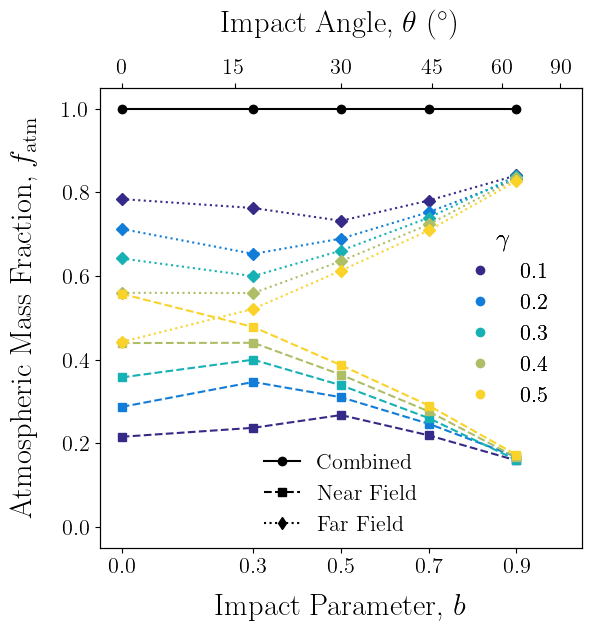

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (6, 6.5))
ax = plt.gca()

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

folder_path = '' # Add path to 'impact' parquet file
data = pd.read_parquet(folder_path + 'impacts')
data = data.sort_values(by = ['gamma', 'v_c_v_esc', 'b'])

colours = cmaps.parula(np.linspace(0, 0.9, len(data.gamma.unique())))
impact_parameters = data.b.unique()

for i, gamma_value in enumerate(data.gamma.unique()):
    data_subset = data[((np.isclose(data['M_t_tot'].astype(float), 1.050265, atol = 1e-8))) & (data.gamma == gamma_value) & (data.v_c_v_esc == 1.0)]
    ax.plot(impact_parameters, data_subset.f_NF, marker = 's', linestyle = '--', color = colours[i], label = 'Near Field')
    ax.plot(impact_parameters, data_subset.f_FF, marker = 'D', linestyle = ':', color = colours[i], label = 'Far Field')

data_subset = data[((np.isclose(data['M_t_tot'].astype(float), 1.050265, atol = 1e-8))) & (data.gamma == 0.1) & (data.v_c_v_esc == 1.0)]
ax.plot(impact_parameters, (data_subset.f_NF + data_subset.f_FF), marker = 'o', linestyle = '-', color = 'k', label = 'Combined')

custom_legend = [
    ax.plot([], [], linestyle = '-', color = 'black', lw = 1.5, marker = 'o', markersize = 6, label = 'Combined')[0],
    ax.plot([], [], linestyle = '--', color = 'black', lw = 1.5, marker = 's', markersize = 6, label = 'Near Field')[0],
    ax.plot([], [], linestyle = ':', color = 'black', lw = 1.5, marker = 'd', markersize = 6, label = 'Far Field')[0]
]

legend1 = ax.legend(custom_legend, ['Combined', 'Near Field', 'Far Field'], fontsize = 16, facecolor = 'white', framealpha = 0.0, handlelength = 1.6, loc = 'best', bbox_to_anchor = (0.7, 0.25))

handles = [plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = colours[i], markersize = 8)
            for i in range(len(data.gamma.unique()))]
labels = [f'{g}' for g in data.gamma.unique()]
legend2 = ax.legend(handles = handles, labels = labels, loc = 'best', bbox_to_anchor = (0.7, 0.5), title = r'$\gamma$', fontsize = 16, title_fontsize = 18, facecolor = 'white', framealpha = 0.0, ncol = 1)

ax.add_artist(legend1)
ax.add_artist(legend2)

ax.set_xticks([0.0, 0.3, 0.5, 0.7, 0.9])
ax.set_xlabel('Impact Parameter, $b$', fontsize = 22)
ax.xaxis.set_label_coords(0.5, -0.1)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.tick_params(axis = 'both', colors = 'k', labelsize = 16)

ax.set_ylabel(r'Atmospheric Mass Fraction, $f_{\rm atm}$', fontsize = 22)
ax.get_yaxis().set_label_coords(-0.13, 0.5)

ax2 = ax.twiny()
theta_ticks = np.array([0, 15, 30, 45, 60, 90])
b_ticks = np.sin(np.radians(theta_ticks))
ax2.set_xticks(b_ticks)
ax2.set_xlim(-0.05, 1.05)
ax2.set_xticklabels([f'{val:.0f}' for val in theta_ticks])
ax2.set_xlabel(r'Impact Angle, $\theta$ ($^{\circ}$)', fontsize = 22)
ax2.xaxis.set_label_coords(0.5, 1.12)
ax2.tick_params(axis = 'x', colors = 'k', labelsize = 16)

plt.tight_layout()
plt.show()

---

## Figure 6: initial pressure vs. radius

In [ ]:
# Load data for the first snapshot:
folder_path = '' # Add path to initial conditions file
IC = '' # Initial conditions file name

(id, mat_id, m, pos, vel, p, rho, u, time) = load_IC(folder_path + IC)

# Index particles from the target and impactor separately based on their material IDs:
ind_tar = np.where(np.logical_or(mat_id == 400, mat_id == 401))[0]

pos_tar = pos[ind_tar]

# Centre the arrays on the centre of mass of the target and impactor, respectively:
pos_com_tar = np.sum(pos_tar * m[ind_tar,np.newaxis], axis = 0) / np.sum(m[ind_tar])
pos_tar -= pos_com_tar

# Calculate the radii of the planets and sort the array:
r_tar = np.sqrt(pos_tar[:,0]**2 + pos_tar[:,1]**2 + pos_tar[:,2]**2)

# Select the top 10% of particles:
tar_shell_0d1 = np.where(r_tar >= np.percentile(r_tar, 90))[0]
id_tar_shell_0d1 = id[ind_tar[tar_shell_0d1]] # Keep these indices constant for each snapshot

# Find the indices of the surface particles from their ID numbers:
tar_shell_from_id_0d1 = np.in1d(id_tar_shell_0d1, id)
ind_tar_0d1 = id.searchsorted(id_tar_shell_0d1)

pos_tar_surface_0d1 = pos[ind_tar_0d1]
pos_tar_surface_0d1[tar_shell_from_id_0d1 == False] = 0
pos_tar_surface_0d1 -= pos_com_tar

# Calculate latitude and longitude:
latitude_tar_0d1 = np.arctan(pos_tar_surface_0d1[:,2]/np.sqrt(pos_tar_surface_0d1[:,0]**2 + pos_tar_surface_0d1[:,1]**2))
longitude_tar_0d1 = np.arccos(pos_tar_surface_0d1[:,0]/np.sqrt(pos_tar_surface_0d1[:,0]**2 + pos_tar_surface_0d1[:,1]**2)) * np.sign(pos_tar_surface_0d1[:,1])

# Order files in the directory numerically regardless of whether they are a snapshot or snipshot:
all_files = os.listdir(folder_path)

# Filter out only files that end in '.hdf5' and start with 'snapshot' or 'snipshot' just to be sure:
filtered_files = [file for file in all_files if file.endswith('.hdf5') and ('snapshot' in file or 'snipshot' in file)]

# Sort them numerically:
snap_and_snip = sorted(filtered_files, key = lambda x: int(''.join(filter(str.isdigit, x)))) # For every file in filtered_files, access the numbers only, stitch them back together
                                                                                            # and convert to an integer, and sort filtered_files based on this

# Access just the snapshots:
snapshots = [file for file in all_files if file.endswith('.hdf5') and 'snapshot' in file]
snapshots = sorted(snapshots, key = lambda x: int(''.join(filter(str.isdigit, x))))

# Plot for subsequent snapshots:
p_tar_surface_time_0d1 = np.ones((len(id_tar_shell_0d1), len(snap_and_snip))) * np.NaN
pot_tar_surface_time_0d1 = np.ones((len(id_tar_shell_0d1), len(snapshots))) * np.NaN
vel_tar_surface_mag_time_0d1 = np.ones((len(id_tar_shell_0d1), len(snapshots))) * np.NaN
t = []

count_snap = 0
  
for i, file in enumerate(snap_and_snip):

    # Load data for the first snapshot:
    data = sw.load(folder_path + file)

    id = data.gas.particle_ids
    npt = 1055173 # Number of particles in the target planet
    id_body = 2e8

    sort = np.argsort(id)
    id = id[sort]

    data.gas.pressures.convert_to_mks()
    p = np.array(data.gas.pressures)
    p = p[sort]

    time = int(data.metadata.t)
    t.append(time)

    # Find the indices of the surface particles from their ID numbers:
    tar_shell_from_id_0d1 = np.in1d(id_tar_shell_0d1, id)
    ind_tar_0d1 = id.searchsorted(id_tar_shell_0d1)

    p_tar_surface_0d1 = p[ind_tar_0d1] 
    p_tar_surface_0d1[tar_shell_from_id_0d1 == False] = 0
    p_tar_surface_time_0d1[:, i] = p_tar_surface_0d1

    # Access the potentials from the snapshots:
    if file.startswith("snapshot"):
        m = np.array(data.gas.masses)
        m = m[sort]

        data.gas.potentials.convert_to_mks()
        pot = np.array(data.gas.potentials)
        pot = pot[sort]

        pot_tar_surface_0d1 = pot[ind_tar_0d1]
        pot_tar_surface_0d1[tar_shell_from_id_0d1 == False] = 0
        pot_tar_surface_time_0d1[:, count_snap] = pot_tar_surface_0d1

        data.gas.velocities.convert_to_mks()
        vel = np.array(data.gas.velocities)
        vel = vel[sort]

        temp = np.where(np.logical_or(mat_id == 400, mat_id == 401))[0]
        vel_tar = vel[temp]
        vel_com_tar = np.sum(vel_tar * m[temp, np.newaxis], axis = 0) / np.sum(m[temp])
        vel_tar -= vel_com_tar

        vel_tar_surface_0d1 = vel[ind_tar_0d1]
        vel_tar_surface_0d1[tar_shell_from_id_0d1 == False] = 0
        vel_tar_surface_0d1 -= vel_com_tar
        vel_tar_surface_mag_0d1 = np.sqrt(vel_tar_surface_0d1[:, 0]**2 + vel_tar_surface_0d1[:, 1]**2 + vel_tar_surface_0d1[:, 2]**2)
        vel_tar_surface_mag_time_0d1[:, count_snap] = vel_tar_surface_mag_0d1

        count_snap += 1

r_tar_surface_0d1 = np.sqrt(pos_tar_surface_0d1[:,0]**2 + pos_tar_surface_0d1[:,1]**2 + pos_tar_surface_0d1[:,2]**2)

idx_outer = np.where(r_tar_surface_0d1 > 6375e3)[0]
idx_middle = np.where(np.logical_and(r_tar_surface_0d1 > 6250e3, r_tar_surface_0d1 < 6350e3))[0]
idx_inner = np.where(r_tar_surface_0d1 < 6250e3)[0]

r_tar_surface_0d1_outer = r_tar_surface_0d1[idx_outer]
r_tar_surface_0d1_middle = r_tar_surface_0d1[idx_middle]
r_tar_surface_0d1_inner = r_tar_surface_0d1[idx_inner]

p_tar_surface_time_0d1_outer = p_tar_surface_time_0d1[idx_outer, 0].flatten()
p_tar_surface_time_0d1_middle = p_tar_surface_time_0d1[idx_middle, 0].flatten()
p_tar_surface_time_0d1_inner = p_tar_surface_time_0d1[idx_inner, 0].flatten()

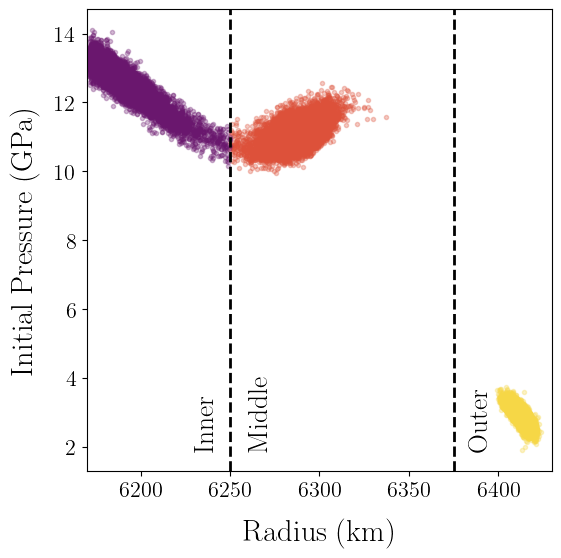

In [ ]:
fig = plt.figure(figsize = (6, 6))
ax = plt.gca()

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

col = plt.cm.inferno(np.linspace(0.3, 0.9, 3))

data_path = '' # Add path to 'Fig6_init_p_vs_r.npz' file
data = np.load(data_path + 'Fig6_init_p_vs_r.npz')

r_tar_surface_0d1_outer = data['r_tar_surface_0d1_outer']
r_tar_surface_0d1_middle = data['r_tar_surface_0d1_middle']
r_tar_surface_0d1_inner = data['r_tar_surface_0d1_inner']

p_tar_surface_time_0d1_outer = data['p_tar_surface_time_0d1_outer']
p_tar_surface_time_0d1_middle = data['p_tar_surface_time_0d1_middle']
p_tar_surface_time_0d1_inner = data['p_tar_surface_time_0d1_inner']

ax.plot(r_tar_surface_0d1_outer/1e3, p_tar_surface_time_0d1_outer/1e9, '.', c = col[2], alpha = 0.3)
ax.plot(r_tar_surface_0d1_middle/1e3, p_tar_surface_time_0d1_middle/1e9, '.', c = col[1], alpha = 0.3)
ax.plot(r_tar_surface_0d1_inner/1e3, p_tar_surface_time_0d1_inner/1e9, '.', c = col[0], alpha = 0.3)

ax.axvline(x = 6375, color = 'black', linestyle = '--', linewidth = 2)
ax.axvline(x = 6250, color = 'black', linestyle = '--', linewidth = 2)

ax.set_xlim([6170, 6430])

ax.text(6230, 2, "Inner", rotation = 90, fontsize = 20)
ax.text(6260, 2, "Middle", rotation = 90, fontsize = 20)
ax.text(6383, 2, "Outer", rotation = 90, fontsize = 20)

ax.set_xlabel('Radius (km)', fontsize = 22)
ax.set_ylabel('Initial Pressure (GPa)', fontsize = 22)
ax.get_xaxis().set_label_coords(0.5, -0.1)
ax.get_yaxis().set_label_coords(-0.1, 0.5)

ax.tick_params(axis = 'x', colors = 'k', labelsize = 16)
ax.tick_params(axis = 'y', colors = 'k', labelsize = 16)

plt.show()

---

## Figure 7: x–t diagram

In [ ]:
# Load data for the first snapshot:
folder_path = ('') # Add path to folder containing output files
IC = '' # Initial conditions file name

(id, mat_id, m, pos, vel, p, rho, u, time) = load_IC(folder_path + IC)

# Index particles from the target and impactor separately based on their material IDs:
ind_tar_with_atmos = np.where(np.logical_or(mat_id == 400, mat_id == 200))[0]
ind_tar_solid = np.where(np.logical_or(mat_id == 401, mat_id == 400))[0]

pos_tar_with_atmos = pos[ind_tar_with_atmos]
pos_tar_solid = pos[ind_tar_solid]

# Centre the arrays on the centre of mass of the target and impactor, respectively:
pos_com_tar_with_atmos = np.sum(pos_tar_with_atmos * m[ind_tar_with_atmos, np.newaxis], axis = 0) / np.sum(m[ind_tar_with_atmos])
pos_tar_with_atmos -= pos_com_tar_with_atmos

pos_com_tar_solid = np.sum(pos_tar_solid * m[ind_tar_solid, np.newaxis], axis = 0) / np.sum(m[ind_tar_solid])
pos_tar_solid -= pos_com_tar_solid

# Calculate the radii of the planets and sort the array:
r_tar = np.sqrt(pos_tar_with_atmos[:, 0]**2 + pos_tar_with_atmos[:, 1]**2 + pos_tar_with_atmos[:, 2]**2)
r_outer_tar = np.mean(np.sort(r_tar)[-100:])

r_tar_solid = np.sqrt(pos_tar_solid[:, 0]**2 + pos_tar_solid[:, 1]**2 + pos_tar_solid[:, 2]**2)
r_outer_tar_solid = np.mean(np.sort(r_tar_solid)[-100:])

# Select particles in an antipodal cuboid:
tar_antipode = np.where(np.logical_and.reduce((pos_tar_with_atmos[:, 0] < 0 * r_outer_tar, 
                                               abs(pos_tar_with_atmos[:, 1]) < 0.02 * r_outer_tar, 
                                               abs(pos_tar_with_atmos[:, 2]) < 0.02 * r_outer_tar)))[0]

id_tar_antipode = id[ind_tar_with_atmos[tar_antipode]] # Keep these indices constant for each snapshot

# Find the indices of the surface particles from their ID numbers:
tar_antipode_from_id = np.in1d(id_tar_antipode, id)
ind_tar_antipode = id.searchsorted(id_tar_antipode)

pos_tar_antipode = pos[ind_tar_antipode]
pos_tar_antipode[tar_antipode_from_id == False] = 0
pos_tar_antipode -= pos_com_tar_with_atmos

r_tar_antipode = np.sqrt(pos_tar_antipode[:,0]**2 + pos_tar_antipode[:,1]**2 + pos_tar_antipode[:,2]**2)

In [ ]:
# Order files in the directory numerically regardless of whether they are a snapshot or snipshot:
all_files = os.listdir(folder_path)

# Filter out only files that end in '.hdf5' and start with 'snapshot' or 'snipshot' just to be sure:
filtered_files = [file for file in all_files if file.endswith('.hdf5') and ('snapshot' in file or 'snipshot' in file)]

# Sort them numerically:
snap_and_snip = sorted(filtered_files, key = lambda x: int(''.join(filter(str.isdigit, x)))) # For every file in filtered_files, access the numbers only, stitch them back together
                                                                                            # and convert to an integer, and sort filtered_files based on this

# Access just the snapshots:
snapshots = [file for file in all_files if file.endswith('.hdf5') and 'snapshot' in file]
snapshots = sorted(snapshots, key = lambda x: int(''.join(filter(str.isdigit, x))))

# Plot for subsequent snapshots:
p_time = np.ones((len(id_tar_antipode), len(snap_and_snip))) * np.NaN
t = []
    
for i, file in enumerate(snap_and_snip):

    # Load data for the first snapshot:
    data = sw.load(folder_path + file)

    id = data.gas.particle_ids
    npt = 1055173 # Number of particles in the target planet
    id_body = 2e8

    sort = np.argsort(id)
    id = id[sort]

    data.gas.pressures.convert_to_mks()
    p = np.array(data.gas.pressures)
    p = p[sort]
    
    time = int(data.metadata.t)
    t.append(time)

    # Find the indices of the surface particles from their ID numbers:
    tar_antipode_from_id = np.in1d(id_tar_antipode, id)
    ind_tar_antipode = id.searchsorted(id_tar_antipode)

    p_tar_antipode = p[ind_tar_antipode] 
    p_tar_antipode[tar_antipode_from_id == False] = 0
    p_time[:, i] = p_tar_antipode

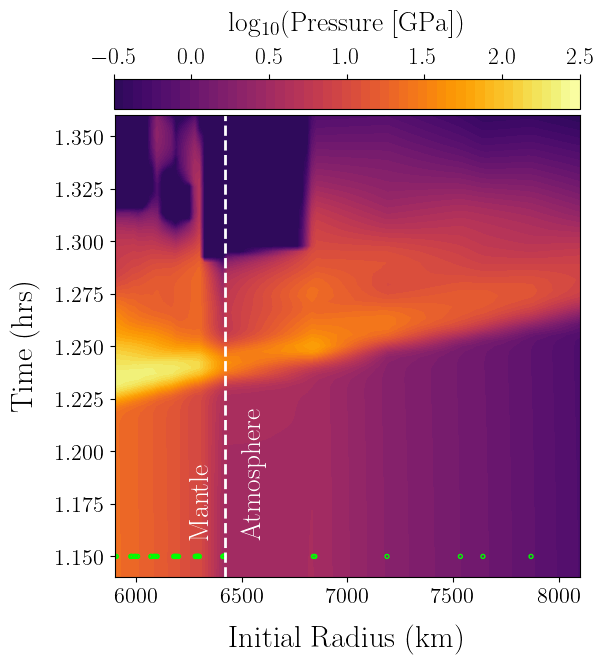

In [ ]:
fig = plt.figure(figsize = (6, 6))
ax = plt.gca()

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

data_path = '' # Add path to 'Fig7_x–t.npz' file. Data for panels a, b, and d are also available
data = np.load(data_path + 'Fig7_x–t.npz')

t = data['t']
pos_tar_antipode = data['pos_tar_antipode']
r_tar_antipode = data['r_tar_antipode']
p_time = data['p_time']
r_outer_tar_solid = data['r_outer_tar_solid']

t_hrs = np.asarray(t)/3600

T_hrs, R_tar_antipode = np.meshgrid(t_hrs, r_tar_antipode)
T_plot, R_plot = np.meshgrid(np.linspace(1.14, 1.4, 100), np.linspace(5900e3, 8100e3, 100))
interp_grid = griddata((R_tar_antipode.flatten()/1e3, T_hrs.flatten()),
                       np.log10(p_time.flatten()/1e9),
                       (R_plot/1e3, T_plot),
                       method = 'linear'
                      )

temp = np.ma.masked_invalid(interp_grid)
temp = np.maximum(temp, -0.5)

antipode = ax.contourf(R_plot/1e3, T_plot, temp, 
                       cmap = mcolors.ListedColormap(plt.get_cmap('inferno')(np.linspace(0.15, 1.0, 256))),
                       levels = np.linspace(-0.5, 2.5, 50),
                      )

ax.scatter(r_tar_antipode/1e3, 
            t_hrs[2357] * np.ones(np.size(pos_tar_antipode[:, 0])), 
            color = 'lime',
            marker = 'o',
            facecolors = 'None',
            s = 8,
            label = 'Particle shell' r'\n' 'locations')

ax.axvline(x = r_outer_tar_solid/1e3, color = 'white', linestyle = '--', linewidth = 2)

ax.set_ylim([1.14, 1.36])
ax.set_xlim([5900, 8100])

ax.set_xlabel('Initial Radius (km)', fontsize = 22)
ax.set_ylabel('Time (hrs)', fontsize = 22)
ax.get_xaxis().set_label_coords(0.5, -0.1)
ax.get_yaxis().set_label_coords(-0.16, 0.5)

ax.tick_params(axis = 'both', colors = 'k', labelsize = 16)

ax.text(6250, 1.16, "Mantle", rotation = 90, fontsize = 20, color = 'white')
ax.text(6500, 1.16, "Atmosphere", rotation = 90, fontsize = 20, color = 'white')

divider = make_axes_locatable(ax)
cax = plt.axes([0.1232, 0.89, 0.7765, 0.05])
cbar = plt.colorbar(antipode, cax = cax, orientation = 'horizontal')
cbar.set_ticks(np.arange(-0.5, 2.6, 0.5))
cbar.set_ticklabels([f'{val:.1f}' for val in np.arange(-0.5, 2.6, 0.5)])
cbar.set_label(r'log$_{10}$(Pressure [GPa])', fontsize = 20, labelpad = 12)
cbar.ax.xaxis.set_ticks_position('top')  
cbar.ax.xaxis.set_label_position('top')  
cbar.ax.tick_params(axis = 'x', direction='out', pad = 5, labelsize = 17)
cbar.update_ticks()

plt.show()

Annotations added in post production.

---

## Figure 8: pressure vs. time traces

In [ ]:
folder_path = ('') # Add path to folder containing output files
IC = '' # Initial conditions file name

# Calculate peak pressures and escape velocities:
(id_tar_shell_0d03,
 latitude_tar_0d03,
 longitude_tar_0d03,
 p_tar_surface_time_0d03,
 t,
 first_peak_pressure,
 time_first_peak_pressure,
 v_esc) = calculate_p_peak_v_esc(folder_path = folder_path,
                                 IC = IC,
                                 npt = npt, # Number of particles in the target planet
                                 b = b, # Impact parameter
                                 vc = v_c_v_esc, # Impact velocity in units of the escape velocity
                                 )

# Define the grid boundaries:
lat_min, lat_max = -90, 90
lon_min, lon_max = -180, 180
d = 10  # side length of grid cells in degrees

# Calculate the number of grid cells in each direction:
n_lat = int(np.ceil((lat_max - lat_min) / d))
n_lon = int(np.ceil((lon_max - lon_min) / d))

# Initialize arrays to store the mean velocity and the lat/lon values of each grid cell:
p_tar_surface_time_0d03_grid = [[[None for x in range(len(t))] for y in range(n_lon)] for z in range(n_lat)]

lat_vals = np.zeros((n_lat, n_lon))
lon_vals = np.zeros((n_lat, n_lon))

count_snap = 0    

for k in range(len(t)):

    # Loop over each grid cell:
    for i in range(n_lat):

        for j in range(n_lon):

            # Calculate the latitude and longitude ranges for this grid cell:
            lat_range = [lat_min + i*d, lat_min + (i+1)*d]
            lon_range = [lon_min + j*d, lon_min + (j+1)*d]

            # Store the first value of lat_range and lon_range for this grid cell:
            lat_vals[i, j] = lat_range[0] + d/2
            lon_vals[i, j] = lon_range[0] + d/2

            # Find the indices of data points within this grid cell:
            mask_tar = (latitude_tar_0d03*180/np.pi >= lat_range[0]) & (latitude_tar_0d03*180/np.pi < lat_range[1]) & (longitude_tar_0d03*180/np.pi >= lon_range[0]) & (longitude_tar_0d03*180/np.pi < lon_range[1])
            idx_tar = np.where(mask_tar)[0]

            # Get the pressures within this grid cell:
            if len(idx_tar) > 0:
                p_tar_surface_time_0d03_grid[i][j][k] = p_tar_surface_time_0d03[idx_tar, k]

            else:
                p_tar_surface_time_0d03_grid[i][j][k] = np.nan

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (6,6 ))
gs = gridspec.GridSpec(1, 1, figure = fig, hspace = 0.015, wspace = 0.2)

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size = 16)

# Define the grid squares to plot and find peaks for:
grid_squares = [(8, x) for x in range(12, 13, 1)]
t_hrs = np.asarray(t) / 3600

col = cmap.PiYG_r(np.linspace(0, 0.5, 5))

(id, mat_id, m, pos, vel, p, rho, u, time) = load_IC(folder_path + IC)

ind_tar = np.where(np.logical_or(mat_id == 400, mat_id == 401))[0]
pos_tar = pos[ind_tar]
pos_com_tar = np.sum(pos_tar * m[ind_tar, np.newaxis], axis = 0) / np.sum(m[ind_tar])
pos_tar -= pos_com_tar
r_tar = np.sqrt(pos_tar[:,0]**2 + pos_tar[:,1]**2 + pos_tar[:,2]**2)

ind_tar_atmos = np.where(mat_id == 200)[0]
pos_tar_atmos = pos[ind_tar_atmos]
pos_tar_atmos -= pos_com_tar

r_tar_atmos = np.mean(np.sort(np.sqrt(pos_tar_atmos[:,0]**2 + pos_tar_atmos[:,1]**2 + pos_tar_atmos[:,2]**2))[-100:]) - np.mean(np.sort(r_tar)[-100:])
r_tar_solid = np.mean(np.sort(r_tar)[-100:])

# Define the height of the atmosphere
if b == 0.0: 
    d = r_tar_atmos
else:
    d = -r_tar_solid * np.cos(np.arcsin(b)) + np.sqrt(r_tar_solid**2 * np.cos(np.arcsin(b))**2 + r_tar_atmos**2 + (2 * r_tar_atmos * r_tar_solid))
        
delta_t = d / v_i # Impact velocity in km/s

# Plot:
for i, (lat, lon) in enumerate(grid_squares):

    ax = fig.add_subplot(gs[0, i])
    
    p_data = np.asarray(p_tar_surface_time_0d03_grid[lat][lon][:]) / 1e9
    
    ax.set_ylabel('Pressure (GPa)' if i == 0 else None, fontsize = 22)
    ax.get_yaxis().set_label_coords(-0.12, 0.5)
    ax.set_xlabel('Time (hrs)', fontsize = 22)
    ax.get_xaxis().set_label_coords(0.5, -0.09)
    ax.tick_params(axis = 'both', labelsize = 16)
    
    for j in range(len(p_data[0,:])):
        ax.plot(t_hrs, p_data[:,j], '-', color = col[3], linewidth = 1.5, alpha = 0.5)
    
    for j in range(len(p_data[0,:1])):
        ax.plot(t_hrs, p_data[:,j], '-', color = col[1], linewidth = 1.5)
        p_peak_idx = peak_finder(p_data[:,j])
        
        ind = np.where(np.logical_and(t_hrs[p_peak_idx] < t_hrs, t_hrs < t_hrs[p_peak_idx] + delta_t))[0]
        p_max = np.max(p_data[ind])
        
        if p_max > 1.05 * p_data[p_peak_idx, j]:
            p_peak_idx_2 = peak_finder(p_data[p_peak_idx+1:, j]) + p_peak_idx + 1
            
            if (p_data[p_peak_idx_2, j] < p_data[p_peak_idx, j]):
                first_peak_pressure[i] = p_data[p_peak_idx, j]
                time_first_peak_pressure[i] = t_hrs[p_peak_idx]
            elif (t_hrs[p_peak_idx_2] - t_hrs[p_peak_idx] > delta_t):
                first_peak_pressure[i] = p_data[p_peak_idx, j]
                time_first_peak_pressure[i] = t_hrs[p_peak_idx]
            else:
                first_peak_pressure[i] = p_data[p_peak_idx_2, j]
                time_first_peak_pressure[i] = t_hrs[p_peak_idx_2]
        else:
            first_peak_pressure[i] = p_data[p_peak_idx, j]
            time_first_peak_pressure[i] = t_hrs[p_peak_idx]
            
        ax.plot(t_hrs[p_peak_idx_2], p_data[p_peak_idx_2, j], 'co')
        ax.plot(t_hrs[p_peak_idx], p_data[p_peak_idx, j], 'ro')
    
    ax.set_xlim([0.985, 1.265])

plt.show()

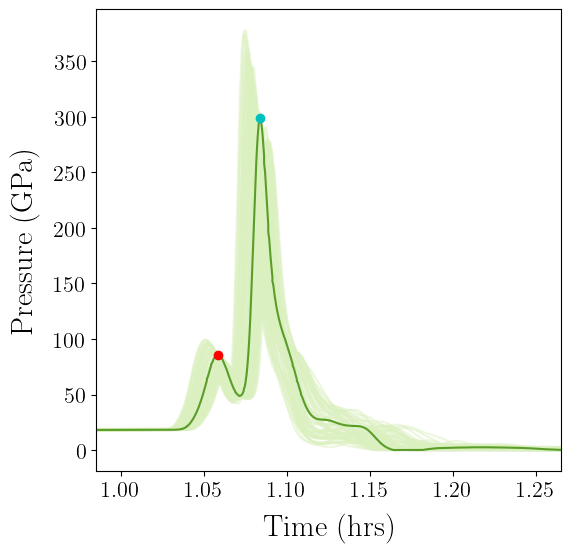

In [ ]:
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1, figure=fig, hspace=0.015, wspace=0.2)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=16)

data_path = '' # Add path to 'Fig8_p_vs_t.npz' file. Data for panels a, b, and d are also available
data = np.load(data_path + 'Fig8_p_vs_t.npz', allow_pickle = True)

t_hrs = data['t_hrs']
grid_squares = data['grid_squares']
first_peak_pressure = data['first_peak_pressure']
time_first_peak_pressure = data['time_first_peak_pressure']
second_peak_pressure = data['second_peak_pressure']
time_second_peak_pressure = data['time_second_peak_pressure']
p_tar_surface_time_0d03_grid = data['p_tar_surface_time_0d03_grid']

col = cmap.PiYG_r(np.linspace(0, 0.5, 5))

for i, (lat, lon) in enumerate(grid_squares):
    ax = fig.add_subplot(gs[0, i])
    
    p_data = np.asarray(p_tar_surface_time_0d03_grid[i]) / 1e9 
    
    ax.set_ylabel('Pressure (GPa)' if i == 0 else None, fontsize=22)
    ax.get_yaxis().set_label_coords(-0.12, 0.5)
    ax.set_xlabel('Time (hrs)', fontsize=22)
    ax.get_xaxis().set_label_coords(0.5, -0.09)
    ax.tick_params(axis='both', labelsize=16)
    
    for j in range(len(p_data[0, :])):
        ax.plot(t_hrs, p_data[:, j], '-', color=col[3], linewidth=1.5, alpha=0.5)

    for j in range(len(p_data[0, :1])):
        ax.plot(t_hrs, p_data[:, j], '-', color=col[1], linewidth=1.5)

    ax.plot(time_first_peak_pressure[i], first_peak_pressure[i], 'ro')

    if not np.isnan(time_second_peak_pressure[i]):
        ax.plot(time_second_peak_pressure[i], second_peak_pressure[i], 'co')
    ax.set_xlim([0.985, 1.265])

plt.show()

---

## Figure 10: $X_{\rm atm}$ vs. $b$

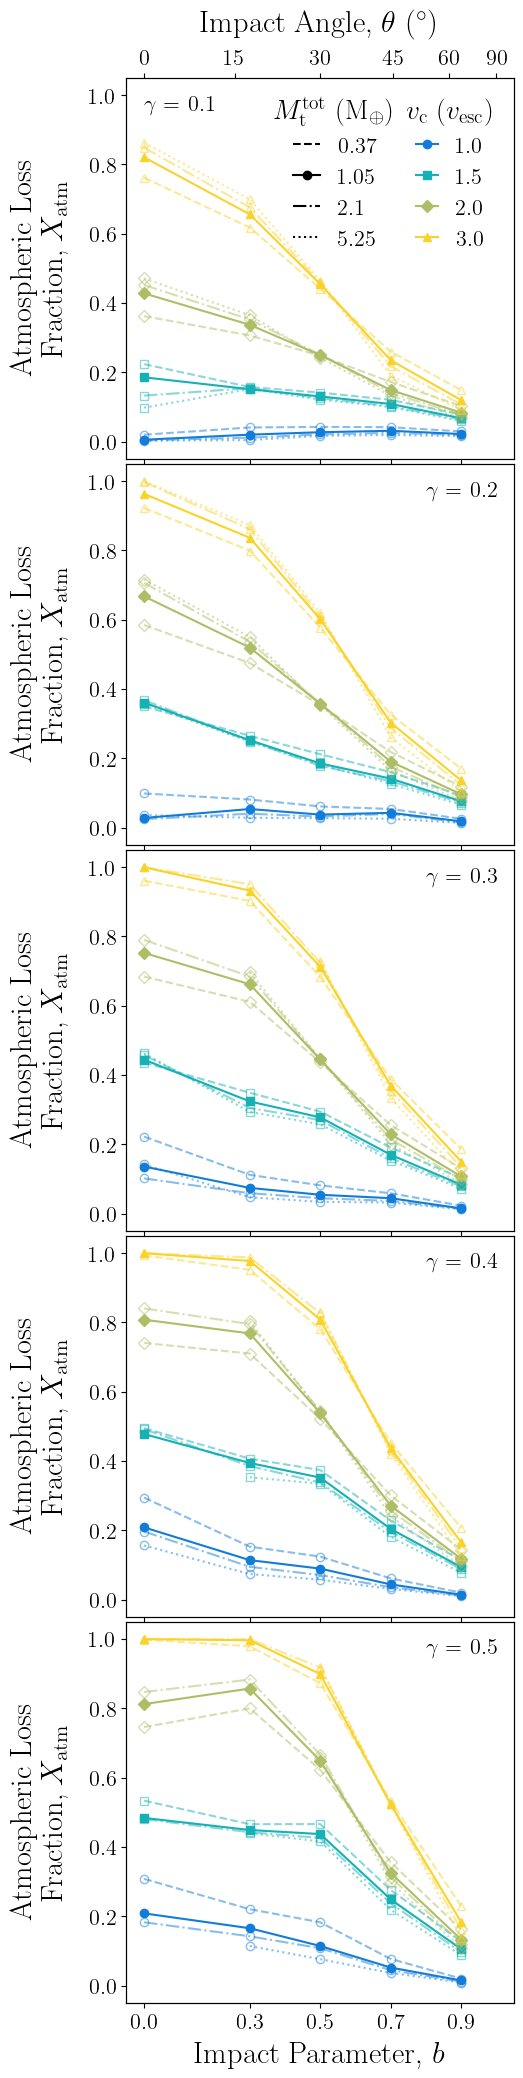

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(5, 25))  
gs = gridspec.GridSpec(5, 1, figure=fig, hspace=0.013, wspace=0.015)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

folder_path = '' # Add path to 'impacts' parquet file
data_impacts_subset_read = pd.read_parquet(folder_path + 'impacts')
data_impacts_subset_read = data_impacts_subset_read.sort_values(by = ['gamma', 'v_c_v_esc', 'b'])

col = cmaps.parula(np.linspace(0, 0.9, 5))  
markers = ['o', 's', 'D', '^']
custom_linestyles = {1.050265: '-',  
                     0.36749: '--', 
                     2.097991: '-.', 
                     5.245433: ':'}
impact_velocities = [1.0, 1.5, 2.0, 3.0]
gamma_values = [0.1, 0.2, 0.3, 0.4, 0.5]  
Mt_values = [0.36749, 1.050265, 2.097991, 5.245433]

for k, g in enumerate(gamma_values):
    ax = fig.add_subplot(gs[k, 0])
    added_labels = set()
    
    for i, Mt in enumerate(Mt_values):
        linestyle = custom_linestyles.get(Mt, '-')
        
        for j, vc in enumerate(impact_velocities):
            
            data = data_impacts_subset_read[(data_impacts_subset_read['tidal_def'] == 'Yes') & 
                                     (np.isclose(data_impacts_subset_read['M_t_tot'].astype(float), Mt, atol = 1e-8)) & 
                                     (data_impacts_subset_read['gamma'] == g) & 
                                     (data_impacts_subset_read['v_c_v_esc'] == vc) & 
                                     ~(
                                         ((np.isclose(data_impacts_subset_read['M_t_tot'].astype(float), 5.245433, atol = 1e-8)) &
                                          (data_impacts_subset_read['gamma'] == 0.3) &
                                          (data_impacts_subset_read['v_c_v_esc'].isin([2.0, 3.0])) &
                                          (data_impacts_subset_read['b'] == 0.0))
                                         |
                                         ((np.isclose(data_impacts_subset_read['M_t_tot'].astype(float), 5.245433, atol = 1e-8)) &
                                          (data_impacts_subset_read['gamma'] == 0.3) &
                                          (data_impacts_subset_read['v_c_v_esc'] == 3.0) &
                                          (data_impacts_subset_read['b'] == 0.3))
                                         |
                                         ((np.isclose(data_impacts_subset_read['M_t_tot'].astype(float), 5.245433, atol = 1e-8)) &
                                          (data_impacts_subset_read['gamma'] == 0.4) &
                                          (data_impacts_subset_read['v_c_v_esc'].isin([1.5, 2.0])) &
                                          (data_impacts_subset_read['b'] == 0.0))
                                         |
                                         ((np.isclose(data_impacts_subset_read['M_t_tot'].astype(float), 5.245433, atol = 1e-8)) &
                                          (data_impacts_subset_read['gamma'] == 0.4) &
                                          (data_impacts_subset_read['v_c_v_esc'] == 3.0) &
                                          (data_impacts_subset_read['b'].isin([0.0, 0.3])))
                                         |
                                         ((np.isclose(data_impacts_subset_read['M_t_tot'].astype(float), 5.245433, atol = 1e-8)) &
                                          (data_impacts_subset_read['gamma'] == 0.5) &
                                          (data_impacts_subset_read['v_c_v_esc'].isin([1.0, 1.5])) &
                                          (data_impacts_subset_read['b'] == 0.0))
                                         |
                                         ((np.isclose(data_impacts_subset_read['M_t_tot'].astype(float), 5.245433, atol = 1e-8)) &
                                          (data_impacts_subset_read['gamma'] == 0.5) &
                                          (data_impacts_subset_read['v_c_v_esc'].isin([2.0, 3.0])) &
                                          (data_impacts_subset_read['b'].isin([0.0, 0.3])))
                                     )].sort_values(by = 'b')
            
            label = f"{vc}" if vc not in added_labels else None
            if label:
                added_labels.add(vc)
            
            ax.plot(data['b'], data['X_atm'], marker=markers[j], markerfacecolor = col[j+1] if np.isclose(Mt, 1.050265, atol=1e-3) else 'none',
                    linestyle=linestyle, color=col[j+1], label=label, alpha = 1.0 if np.isclose(Mt, 1.050265, atol=1e-3) else 0.5)
    
    ax.set_xticks([0.0, 0.3, 0.5, 0.7, 0.9])
    ax.set_xlabel('Impact Parameter, $b$' if k == 4 else None, fontsize=22)
    ax.get_xaxis().set_label_coords(0.5, -0.1)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis='both', colors='k', labelsize=16)
    
    ax.set_ylabel(r'Atmospheric Loss' '\n' r'Fraction, $X_{{\rm atm}}$', fontsize=22)
    ax.get_yaxis().set_label_coords(-0.15, 0.5)
    
    if k == 0:
        ax.text(0.0, 1.0, rf'$\gamma$ = {g}', fontsize=16, va='top')
    else:
        ax.text(0.8, 1.0, rf'$\gamma$ = {g}', fontsize=16, va='top')
    
    if k == 0:
        legend1 = ax.legend(fontsize=16, facecolor='white', framealpha=0.0, handlelength=1, loc='best', 
                     title=r'$v_{\rm c}$ ($v_{{\rm esc}}$)', handles=[
            Line2D([0], [0], linestyle='-', color=col[j+1], marker=markers[j], label=f"{vc}") 
            for j, vc in enumerate(impact_velocities)
        ])
        ax.get_legend().get_title().set_fontsize(20)
        
        linestyle_legend = [
            Line2D([0], [0], linestyle=custom_linestyles[Mt], color='black', marker=markers[0] if np.isclose(Mt, 1.050265, atol=1e-3) else None, 
                   markerfacecolor='black' if np.isclose(Mt, 1.050265, atol=1e-3) else 'none', 
                   markeredgecolor='black', label=f'{Mt:.1f}' if np.isclose(Mt, 2.097991, atol=1e-3) else f'{Mt:.2f}') 
            for Mt in Mt_values
        ]

        legend2 = ax.legend(handles=linestyle_legend, fontsize=16, bbox_to_anchor=(0.33, 0.75), loc='center left', title = r'$M_{\rm t}^{\rm tot}$ (M$_{\oplus}$)', 
                            framealpha=0.0, handlelength=1.2)
        ax.get_legend().get_title().set_fontsize(20)
        ax.add_artist(legend1)
    
    ax2 = ax.twiny()
    theta_ticks = np.array([0, 15, 30, 45, 60, 90])
    b_ticks = np.sin(np.radians(theta_ticks))
    ax2.set_xticks(b_ticks)
    ax2.set_xlim(-0.05, 1.05)
    ax2.set_xticklabels([] if k != 0 else [f'{val:.0f}' for val in theta_ticks])
    ax2.tick_params(axis='x', which='both', bottom=False, top=(k == 0))
    ax2.set_xlabel(r'Impact Angle, $\theta$ ($^{\circ}$)' if k == 0 else None, fontsize=22)
    ax2.xaxis.set_label_coords(0.5, 1.12)
    ax2.tick_params(axis='x', colors='k', labelsize=16)

plt.tight_layout()
plt.show()

---

## Figure 11: $X_{\rm atm}$ vs. peak shock pressure maps

In [ ]:
# Load data for the first snapshot:
folder_path = '' # Add path to initial conditions file
IC = '' # Initial conditions file name

(id, mat_id, m, pos, vel, p, rho, u, time) = load_IC(folder_path + IC)

# Index particles from the target and impactor separately based on their material IDs:
ind_tar = np.where(np.logical_or(mat_id == 400, mat_id == 401))[0]

pos_tar = pos[ind_tar]

# Centre the arrays on the centre of mass of the target and impactor, respectively:
pos_com_tar = np.sum(pos_tar * m[ind_tar,np.newaxis], axis = 0) / np.sum(m[ind_tar])
pos_tar -= pos_com_tar

# Calculate the radii of the planets and sort the array:
r_tar = np.sqrt(pos_tar[:,0]**2 + pos_tar[:,1]**2 + pos_tar[:,2]**2)

# Select the top 20% of particles:
tar_shell_0d2 = np.where(r_tar >= np.percentile(r_tar, 80))[0]
id_tar_shell_0d2 = id[ind_tar[tar_shell_0d2]] # Keep these indices constant for each snapshot

# Find the indices of the surface particles from their ID numbers:
tar_shell_from_id_0d2 = np.in1d(id_tar_shell_0d2, id)
ind_tar_0d2 = id.searchsorted(id_tar_shell_0d2)

pos_tar_surface_0d2 = pos[ind_tar_0d2]
pos_tar_surface_0d2[tar_shell_from_id_0d2 == False] = 0
pos_tar_surface_0d2 -= pos_com_tar

r_tar_surface_0d2 = np.sqrt(pos_tar_surface_0d2[:,0]**2 + pos_tar_surface_0d2[:,1]**2 + pos_tar_surface_0d2[:,2]**2)

p_tar_surface_0d2 = p[ind_tar_0d2] 
p_tar_surface_0d2[tar_shell_from_id_0d2 == False] = 0

# Calculate latitude and longitude:
latitude_tar_0d2 = np.arctan(pos_tar_surface_0d2[:,2]/np.sqrt(pos_tar_surface_0d2[:,0]**2 + pos_tar_surface_0d2[:,1]**2))
longitude_tar_0d2 = np.arccos(pos_tar_surface_0d2[:,0]/np.sqrt(pos_tar_surface_0d2[:,0]**2 + pos_tar_surface_0d2[:,1]**2)) * np.sign(pos_tar_surface_0d2[:,1])

data = list(zip(r_tar_surface_0d2, p_tar_surface_0d2)) 

# Fit KMeans and get labels:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(data)
labels = kmeans.labels_

# Calculate the mean radius and mean pressure for each cluster:
mean_radii = []
mean_pressures = []
for i in range(3):  
    mean_radii.append(np.mean(r_tar_surface_0d1[labels == i]))
    mean_pressures.append(np.mean(p_tar_surface_0d1[labels == i]))

# Determine the correct cluster labels based on mean radius and pressure:
# Sort by mean radius ascending (smallest to largest):
sorted_by_radius = np.argsort(mean_radii)

# To distinguish between middle and inner clusters, consider the mean pressure:
if mean_pressures[sorted_by_radius[0]] > mean_pressures[sorted_by_radius[1]]:
    idx_inner = np.where(labels == sorted_by_radius[0])[0]
    idx_middle = np.where(labels == sorted_by_radius[1])[0]
else:
    idx_inner = np.where(labels == sorted_by_radius[1])[0]
    idx_middle = np.where(labels == sorted_by_radius[0])[0]

idx_outer = np.where(labels == sorted_by_radius[2])[0]

# Now discard the outer particles and take 3% of the upper mantle to define as the surface:
ind_tar_reduced = np.setdiff1d(ind_tar, ind_tar_0d1[idx_outer])
pos_tar = pos[ind_tar_reduced]

# Centre the arrays on the centre of mass of the target and impactor, respectively:
pos_com_tar = np.sum(pos_tar * m[ind_tar_reduced, np.newaxis], axis = 0) / np.sum(m[ind_tar_reduced])
pos_tar -= pos_com_tar

# Calculate the radii of the planets and sort the array:
r_tar = np.sqrt(pos_tar[:,0]**2 + pos_tar[:,1]**2 + pos_tar[:,2]**2)

tar_shell_0d03 = np.where(r_tar >= np.percentile(r_tar, 97))[0] # 96.88
id_tar_shell_0d03 = id[ind_tar_reduced[tar_shell_0d03]] # Keep these indices constant for each snapshot

# Find the indices of the surface particles from their ID numbers:
tar_shell_from_id_0d03 = np.in1d(id_tar_shell_0d03, id)
ind_tar_0d03 = id.searchsorted(id_tar_shell_0d03)

pos_tar_surface_0d03 = pos[ind_tar_0d03]
pos_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0
pos_tar_surface_0d03 -= pos_com_tar

r_tar_surface_0d03 = np.sqrt(pos_tar_surface_0d03[:,0]**2 + pos_tar_surface_0d03[:,1]**2 + pos_tar_surface_0d03[:,2]**2)

p_tar_surface_0d03 = p[ind_tar_0d03] 
p_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0

# Calculate latitude and longitude:
latitude_tar_0d03 = np.arctan(pos_tar_surface_0d03[:,2]/np.sqrt(pos_tar_surface_0d03[:,0]**2 + pos_tar_surface_0d03[:,1]**2))
longitude_tar_0d03 = np.arccos(pos_tar_surface_0d03[:,0]/np.sqrt(pos_tar_surface_0d03[:,0]**2 + pos_tar_surface_0d03[:,1]**2)) * np.sign(pos_tar_surface_0d03[:,1])

In [ ]:
# Order files in the directory numerically regardless of whether they are a snapshot or snipshot:
all_files = os.listdir(folder_path)

# Filter out only files that end in '.hdf5' and start with 'snapshot' or 'snipshot' just to be sure:
filtered_files = [file for file in all_files if file.endswith('.hdf5') and ('snapshot' in file or 'snipshot' in file)]

# Sort them numerically:
snap_and_snip = sorted(filtered_files, key = lambda x: int(''.join(filter(str.isdigit, x)))) # For every file in filtered_files, access the numbers only, stitch them back together
                                                                                             # and convert to an integer, and sort filtered_files based on this

# Access just the snapshots, and select those for a subset between 0.5 and 2.5 hrs:
snapshots = [file for file in all_files if file.endswith('.hdf5') and 'snapshot' in file]
snapshots = sorted(snapshots, key = lambda x: int(''.join(filter(str.isdigit, x))))
snapshots_subset = snapshots[18:7218]

# Select a subset of only between 0.0 and 2.5 hrs:
snap_and_snip_subset = snap_and_snip[0:7218]

# Plot for subsequent snapshots:
p_tar_surface_time_0d03 = np.ones((len(id_tar_shell_0d03), len(snap_and_snip_subset))) * np.NaN
t = []
    
for i, file in enumerate(snap_and_snip_subset):

    # Load data for the first snapshot:
    data = sw.load(folder_path + file)

    id = data.gas.particle_ids
    npt = 1055173 # Number of particles in the target planet
    id_body = 2e8

    sort = np.argsort(id)
    id = id[sort]

    data.gas.pressures.convert_to_mks()
    p = np.array(data.gas.pressures)
    p = p[sort]

    time = int(data.metadata.t)
    t.append(time)

    # Find the indices of the surface particles from their ID numbers:
    tar_shell_from_id_0d03 = np.in1d(id_tar_shell_0d03, id)
    ind_tar_0d03 = id.searchsorted(id_tar_shell_0d03)

    p_tar_surface_0d03 = p[ind_tar_0d03] 
    p_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0
    p_tar_surface_time_0d03[:, i] = p_tar_surface_0d03

In [ ]:
# Initialize arrays to store the peak pressures and times for each grid cell:
t_hrs = np.asarray(t)/3600
first_peak_pressure = np.zeros(len(id_tar_shell_0d03))
time_first_peak_pressure = np.zeros(len(id_tar_shell_0d03))

first_peak_pressure_2 = np.zeros(len(id_tar_shell_0d03))
time_first_peak_pressure_2 = np.zeros(len(id_tar_shell_0d03))

ind_tar_atmos = np.where(mat_id == 200)[0]
pos_tar_atmos = pos[ind_tar_atmos]
pos_tar_atmos -= pos_com_tar
r_tar_atmos = np.mean(np.sort(np.sqrt(pos_tar_atmos[:,0]**2 + pos_tar_atmos[:,1]**2 + pos_tar_atmos[:,2]**2))[-100:]) - np.mean(np.sort(r_tar)[-100:])
r_tar_solid = np.mean(np.sort(r_tar)[-100:])

v_i = 2 * np.sqrt(2*G*(1.05027*M_earth + 0.11069*M_earth)/(1.05027**0.25*R_earth + 0.11069**0.25*R_earth))
d = -r_tar_solid * np.cos(np.arcsin(0.3)) + np.sqrt(r_tar_solid**2 * np.cos(np.arcsin(0.3))**2 + r_tar_atmos**2 + (2 * r_tar_atmos * r_tar_solid))

delta_t = d / v_i

# Loop over each particle:
for i in range(len(id_tar_shell_0d03)):

    # Extract pressure data for the current particle:
    p = p_tar_surface_time_0d03[i, :] / 1e9

    # Find the index of the first peak:
    peak_idx = peak_finder(p) # Run peak_finder function first in Extra functions section
    
    ind = np.where(np.logical_and(t_hrs[peak_idx] < t_hrs, t_hrs < t_hrs[peak_idx] + delta_t))[0]
    p_max = np.max(p[ind])
    
    if p_max > 1.05 * p[peak_idx]:
        peak_idx_2 = peak_finder(p[peak_idx+1:]) + peak_idx + 1
        
        if (p[peak_idx_2] < p[peak_idx]) | (t_hrs[peak_idx_2] - t_hrs[peak_idx] > delta_t):
            first_peak_pressure[i] = p[peak_idx]
            time_first_peak_pressure[i] = t_hrs[peak_idx]
        else:
            first_peak_pressure[i] = p[peak_idx_2]
            time_first_peak_pressure[i] = t_hrs[peak_idx_2]
    else:
        first_peak_pressure[i] = p[peak_idx]
        time_first_peak_pressure[i] = t_hrs[peak_idx]

first_peak_pressure = first_peak_pressure * 1e9

In [ ]:
# Define the grid boundaries:
lat_min, lat_max = -90, 90
lon_min, lon_max = -180, 180
d = 10  # side length of grid cells in degrees

# Calculate the number of grid cells in each direction:
n_lat = int(np.ceil((lat_max - lat_min) / d))
n_lon = int(np.ceil((lon_max - lon_min) / d))

lat_vals = np.zeros((n_lat, n_lon))
lon_vals = np.zeros((n_lat, n_lon))

id_grid = [[None for x in range(n_lon)] for y in range(n_lat)]
first_peak_pressure_grid_median = [[None for x in range(n_lon)] for y in range(n_lat)]
time_first_peak_pressure_grid_median = [[None for x in range(n_lon)] for y in range(n_lat)]

# Loop over each grid cell:
for i in range(n_lat):

    for j in range(n_lon):

        # Calculate the latitude and longitude ranges for this grid cell:
        lat_range = [lat_min + i*d, lat_min + (i+1)*d]
        lon_range = [lon_min + j*d, lon_min + (j+1)*d]

        # Store the first value of lat_range and lon_range for this grid cell:
        lat_vals[i, j] = lat_range[0] + d/2
        lon_vals[i, j] = lon_range[0] + d/2

        # Find the indices of data points within this grid cell:
        mask_tar = (latitude_tar_0d03*180/np.pi >= lat_range[0]) & (latitude_tar_0d03*180/np.pi < lat_range[1]) & (longitude_tar_0d03*180/np.pi >= lon_range[0]) & (longitude_tar_0d03*180/np.pi < lon_range[1])
        idx_tar = np.where(mask_tar)[0]
        
        if len(idx_tar) > 0:
            id_grid[i][j] = idx_tar
            first_peak_pressure_grid_median[i][j] = np.nanmedian(first_peak_pressure[idx_tar])
            time_first_peak_pressure_grid_median[i][j] = np.nanmedian(time_first_peak_pressure[idx_tar])
        else:
            id_grid[i][j] = []
            first_peak_pressure_grid_median[i][j] = np.nan
            time_first_peak_pressure_grid_median[i][j] = np.nan
            
first_peak_pressure_grid_median = np.asarray(first_peak_pressure_grid_median)
time_first_peak_pressure_grid_median = np.asarray(time_first_peak_pressure_grid_median)

In [ ]:
(lat_vals, 
 lon_vals, 
 initial_cell_atmos_mass, 
 _,
 _,
 bound_cell_atmos_mass_time,
 _,
 _) = calculate_global_loss_near_far(folder_path,
                                    max_remnant = 1,
                                    npt = 1055173, # Number of particles in the target planet
                                    m_tot = 1.16096, # Total system mass
                                    output_id = 1,
                                    atmos_id = 200
)

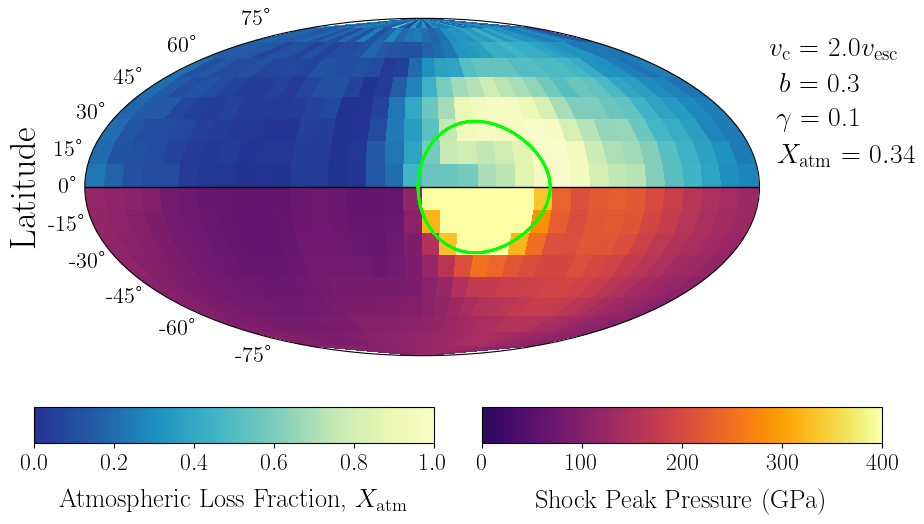

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (16, 20))
ax = fig.add_subplot(221, projection = 'mollweide')

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

data_path = '' # Add path to 'Fig11c_loss_vs_p_peak_map.npz' file. Data for panels a, b, and d are also available
data = np.load(data_path + 'Fig11c_loss_vs_p_peak_map.npz')

lon_vals = data['lon_vals']
lat_vals = data['lat_vals']
initial_cell_atmos_mass = data['initial_cell_atmos_mass']
bound_cell_atmos_mass_time = data['bound_cell_atmos_mass_time']
first_peak_pressure_grid_median = data['first_peak_pressure_grid_median']

atmos_loss_1D_middle = ax.pcolormesh(np.deg2rad(lon_vals[9:, :]), np.deg2rad(lat_vals[9:, :]), 1-bound_cell_atmos_mass_time[9:, :, 1], cmap = mcolors.ListedColormap(plt.get_cmap('YlGnBu').reversed()(np.linspace(0.12, 0.95, 256))), vmax = 1.0, vmin = 0, rasterized = True)
peak_pressure_middle = ax.pcolormesh(np.deg2rad(lon_vals[:9, :]), np.deg2rad(lat_vals[:9, :]), first_peak_pressure_grid_median[:9, :]/1e9, cmap = mcolors.ListedColormap(plt.get_cmap('inferno')(np.linspace(0.15, 1.0, 256))), vmax = 400, vmin = 0, rasterized = True)
ax.axhline(0, color = 'black', linestyle = '-', linewidth = 1)

ax.text(1.205, 0.95, r"$v_{\rm c}$ = 2.0$v_{{\rm esc}}$", transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.15, 0.84, "$b$ = 0.3", transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.15, 0.74, "$\gamma$ = 0.1", transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.23, 0.63, r"$X_{{\rm atm}}$ = ${0:.2f}$".format(1-(np.sum(initial_cell_atmos_mass[:, :]*bound_cell_atmos_mass_time[:, :, 1])/np.sum(initial_cell_atmos_mass[:, :]))), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)

ax.set_xticklabels([])
ax.set_ylabel('Latitude', fontsize = 26)
ax.yaxis.set_tick_params(labelsize = 16)

# Run plot_impactor_radius function first in Extra functions section
plot_impactor_radius(folder_path = '', # Add path to 'PLANETimpact_0d0h_target_1d05027Earth_500K_HM80_HHe_atmosphere_0d05_npt1055173_impactor_0d11069Earth_npt119232_14d63kms_0d3b_0d1gamma_pX_EiEf_100box_snap1.hdf5' file
                           first_snapshot = 'PLANETimpact_0d0h_target_1d05027Earth_500K_HM80_HHe_atmosphere_0d05_npt1055173_impactor_0d11069Earth_npt119232_14d63kms_0d3b_0d1gamma_pX_EiEf_100box_snap1.hdf5',
                           npt = 1055173,
                           lon_vals = lon_vals,
                           lat_vals = lat_vals,
                           d = 10,
                           b_imp = 0.3, # Change this to the impact parameter of the map you wish to plot
                           ax = ax)

##########################################################################################################

# Colourbars:
divider = make_axes_locatable(ax)
cax = plt.axes([0.025, 0.62, 0.25, 0.018])
cbar = plt.colorbar(atmos_loss_1D_middle, cax = cax, orientation = 'horizontal')
cbar.set_label(r'Atmospheric Loss Fraction, $X_{{\rm atm}}$', fontsize = 19)
cbar.ax.get_xaxis().labelpad = 10
cbar.ax.yaxis.set_offset_position('left') 
cbar.ax.yaxis.offsetText.set_fontsize(18)
cbar.ax.tick_params(labelsize = 17) 
cbar.update_ticks()

divider = make_axes_locatable(ax)
cax = plt.axes([0.305, 0.62, 0.25, 0.018])
cbar = plt.colorbar(peak_pressure_middle, cax = cax, orientation = 'horizontal')
cbar.set_label('Shock Peak Pressure (GPa)', fontsize = 19)
cbar.ax.get_xaxis().labelpad = 10
cbar.ax.yaxis.set_offset_position('left') 
cbar.ax.yaxis.offsetText.set_fontsize(18)
cbar.ax.tick_params(labelsize = 17) 
cbar.update_ticks()

plt.tight_layout()
plt.show()

---

## Figure 12: $X_{\rm NF}$ vs. $b$

/var/folders/kj/59sk5mrx6214shnd0_nt_2z80000gq/T/ipykernel_33429/816526063.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


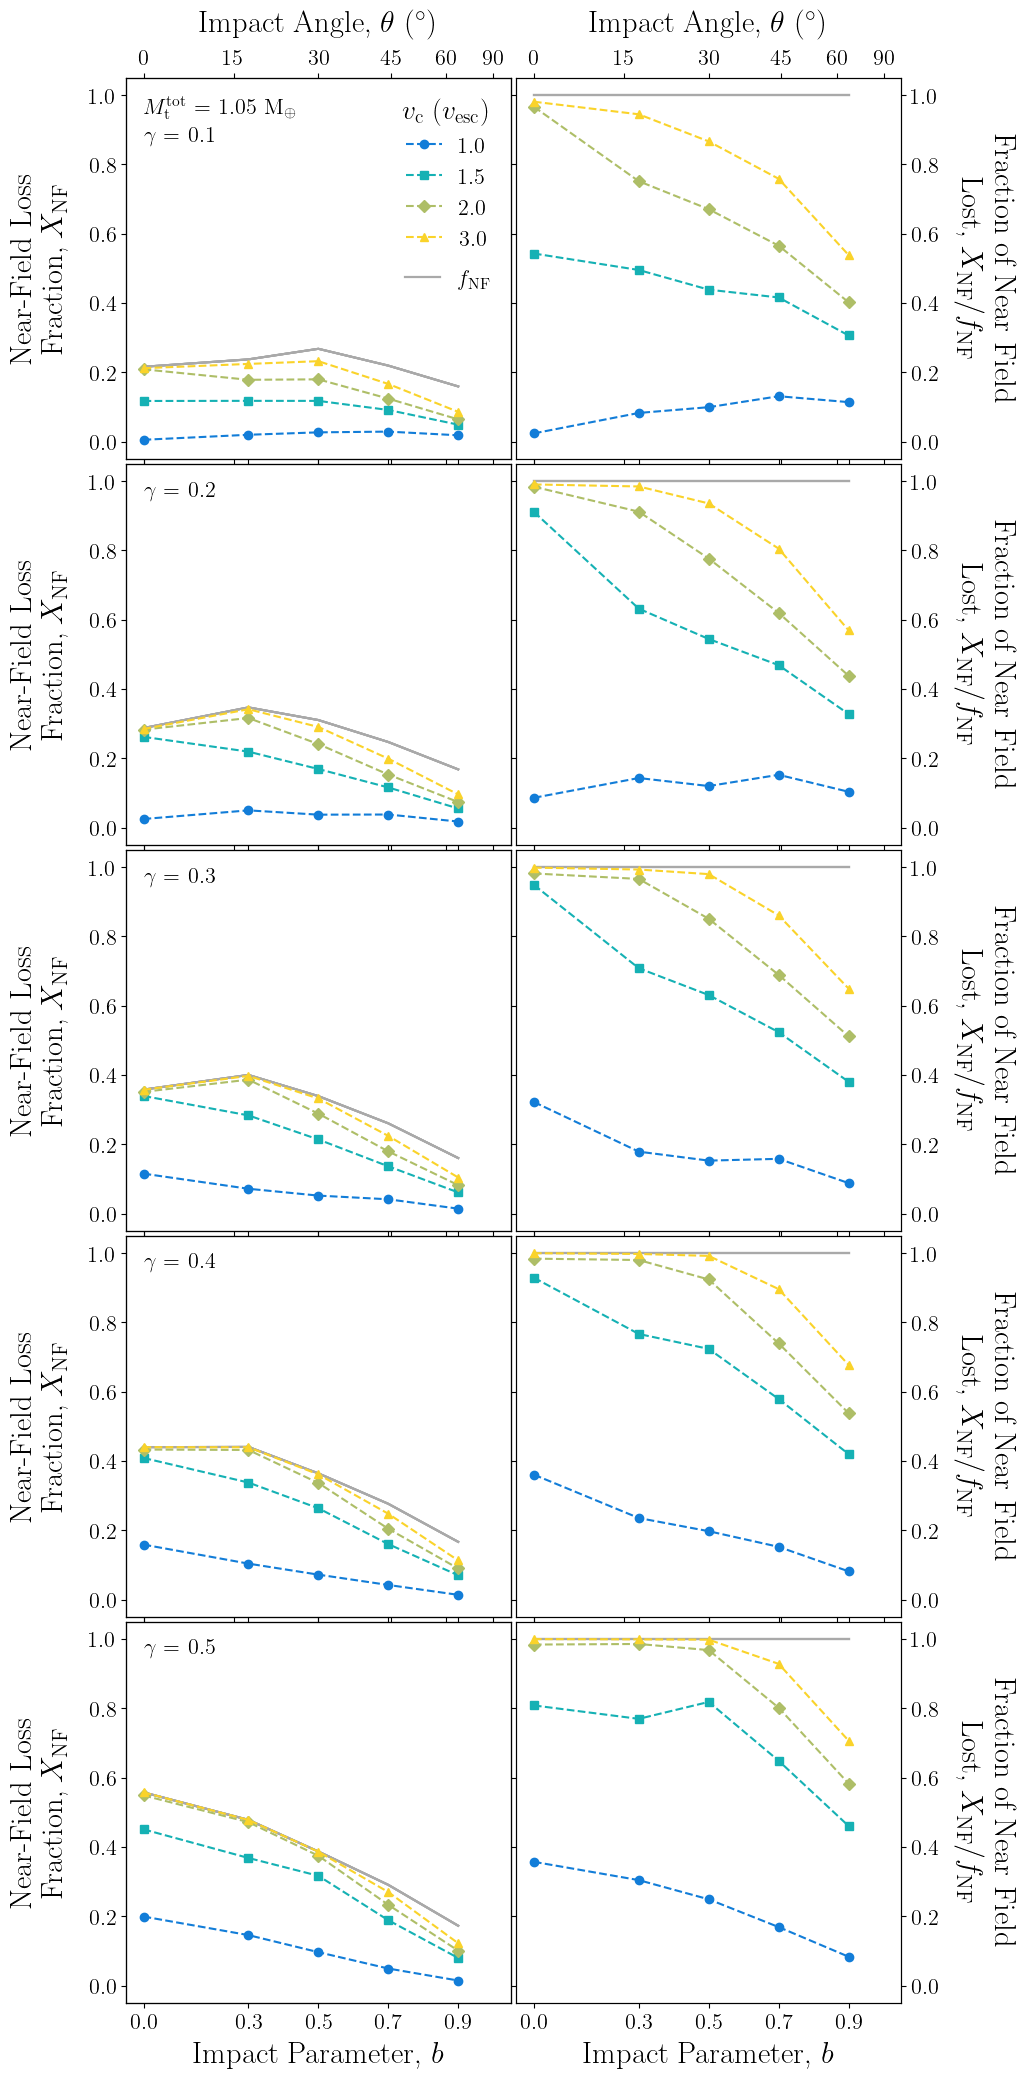

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(5, 2, figure=fig, hspace=0.013, wspace=0.015)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

folder_path = '' # Add path to 'impacts' parquet file
data_impacts_subset_read = pd.read_parquet(folder_path + 'impacts')
data_impacts_subset_read = data_impacts_subset_read.sort_values(by = ['gamma', 'v_c_v_esc', 'b'])

col = cmaps.parula(np.linspace(0, 0.9, 5))
markers = ['o', 's', 'D', '^']
impact_velocities = [1.0, 1.5, 2.0, 3.0]
gamma_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # Include all gamma values
Mt_values = [1.050265, 1.050265]

custom_legend = [
    plt.Line2D([], [], linestyle='-', color='darkgrey', lw=1.6, marker='none', label=r'$f_{\rm NF}$')
]

for k, g in enumerate(gamma_values):
    for i, Mt in enumerate(Mt_values):
        ax = fig.add_subplot(gs[k, i])
        
        for j, vc in enumerate(impact_velocities):
            data = data_impacts_subset_read[
                (np.isclose(data_impacts_subset_read['M_t_tot'].astype(float), Mt, atol=1e-8)) &
                (data_impacts_subset_read['gamma'] == g) &
                (data_impacts_subset_read['v_c_v_esc'] == vc)
            ].sort_values(by='b')

            if i == 0:
                # First column: plot 'f_NF' and 'X_NF'
                ax.plot(data['b'], data['f_NF'], linestyle='-', color='darkgrey')
                ax.plot(data['b'], data['X_NF'], marker=markers[j], linestyle='--', color=col[j + 1], label=r"${0}$".format(vc))
            elif i == 1:
                # Second column: plot 'X_NF/f_NF'
                ax.plot(data['b'], data['f_NF'] / data['f_NF'], linestyle='-', color='darkgrey')
                ax.plot(data['b'], data['X_NF'] / data['f_NF'], marker=markers[j], linestyle='--', color=col[j + 1], label=r"${0}$".format(vc))
        
        ax.set_xticks([0.0, 0.3, 0.5, 0.7, 0.9])
        ax.set_xlabel('Impact Parameter, $b$' if k == 4 else None, fontsize=22)
        ax.get_xaxis().set_label_coords(0.5, -0.1)
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.tick_params(axis='both', colors='k', labelsize=16)

        if i == 0:
            ax.set_ylabel(r'Near-Field Loss' '\n' r'Fraction, $X_{{\rm NF}}$', fontsize=22)
            ax.get_yaxis().set_label_coords(-0.15, 0.5)
            
            # Add right-side y-ticks (no labels)
            ax_right = ax.twinx()
            ax_right.tick_params(axis='y', which='both', length=4, color='k', labelleft=False, labelright=False)
            ax_right.set_yticks(ax.get_yticks())  # Match ticks to the left y-axis
            ax_right.set_ylim(ax.get_ylim())  # Ensure limits match

            if k == 0:
                legend1 = ax.legend(fontsize=16, facecolor='white', framealpha=0.0, handlelength=1.6, loc='best', title=r'$v_{\rm c}$ ($v_{{\rm esc}}$)')
                ax.get_legend().get_title().set_fontsize(20)

                ax.text(0.0, 1.0, r'$M_{{\rm t}}^{{\rm tot}}$ = {0:.2f} M$_{{\oplus}}$'.format(Mt), fontsize=16, va='top')
                ax.text(0.0, 0.91, r'$\gamma$ = {0}'.format(g), fontsize=16, va='top')
                
                legend2 = ax.legend(custom_legend, [r'$f_{\rm NF}$'], fontsize=16, facecolor='white', framealpha=0.0, handlelength=1.6, bbox_to_anchor = (1.0, 0.55))
                
                ax.add_artist(legend1)

            else:
                ax.text(0.0, 1.0, r'$\gamma$ = {0}'.format(g), fontsize=16, va='top')
                
        if i == 1:
            # Right-side ticks and label for second column
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(r'Fraction of Near Field' '\n' r'Lost, $X_{{\rm NF}} / f_{{\rm NF}}$', fontsize=22, rotation=-90)
            ax.get_yaxis().set_label_coords(1.3, 0.5)

        ax2 = ax.twiny()
        theta_ticks = np.array([0, 15, 30, 45, 60, 90])
        b_ticks = np.sin(np.radians(theta_ticks))
        ax2.set_xticks(b_ticks)
        ax2.set_xlim(-0.05, 1.05)
        ax2.set_xticklabels([] if k != 0 else [f'{val:.0f}' for val in theta_ticks])
        ax2.set_xlabel(r'Impact Angle, $\theta$ ($^{\circ}$)' if k == 0 else None, fontsize=22)
        ax2.xaxis.set_label_coords(0.5, 1.12)
        ax2.tick_params(axis='x', colors='k', labelsize=16)

plt.tight_layout()
plt.show()

---

## Figure 13: $X_{\rm FF}$ vs. $b$

/var/folders/kj/59sk5mrx6214shnd0_nt_2z80000gq/T/ipykernel_33429/2882591130.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


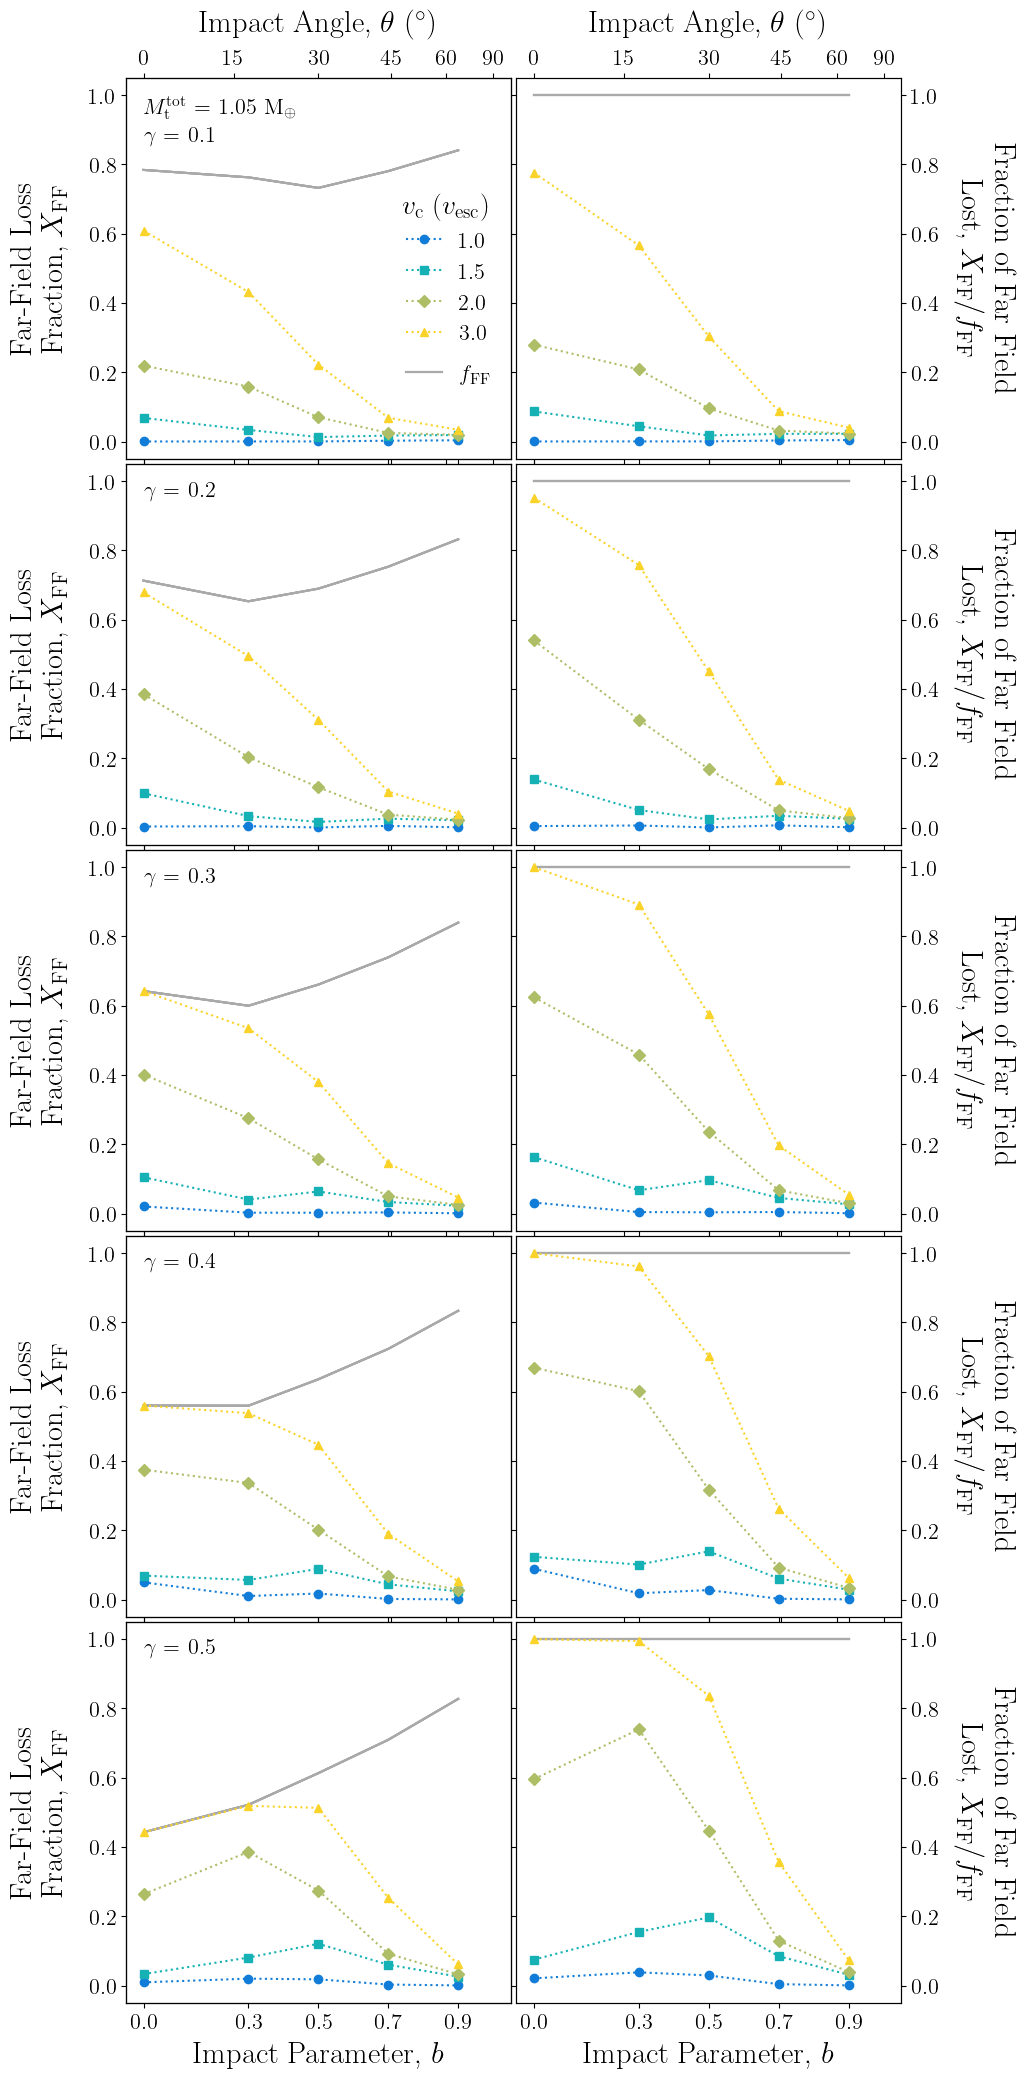

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(5, 2, figure=fig, hspace=0.013, wspace=0.015)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

folder_path = '' # Add path to 'impacts' parquet file
data_impacts_subset_read = pd.read_parquet(folder_path + 'impacts')
data_impacts_subset_read = data_impacts_subset_read.sort_values(by = ['gamma', 'v_c_v_esc', 'b'])

col = cmaps.parula(np.linspace(0, 0.9, 5))
markers = ['o', 's', 'D', '^']
impact_velocities = [1.0, 1.5, 2.0, 3.0]
gamma_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # Include all gamma values
Mt_values = [1.050265, 1.050265]

custom_legend = [
    plt.Line2D([], [], linestyle='-', color='darkgrey', lw=1.6, marker='none', label=r'$f_{\rm FF}$')
]

for k, g in enumerate(gamma_values):
    for i, Mt in enumerate(Mt_values):
        ax = fig.add_subplot(gs[k, i])
        
        for j, vc in enumerate(impact_velocities):
            data = data_impacts_subset_read[
                (np.isclose(data_impacts_subset_read['M_t_tot'].astype(float), Mt, atol=1e-8)) &
                (data_impacts_subset_read['gamma'] == g) &
                (data_impacts_subset_read['v_c_v_esc'] == vc)
            ].sort_values(by='b')

            if i == 0:
                # First column: plot 'f_NF' and 'X_NF'
                ax.plot(data['b'], data['f_FF'], linestyle='-', color='darkgrey')
                ax.plot(data['b'], data['X_FF'], marker=markers[j], linestyle=':', color=col[j + 1], label=r"${0}$".format(vc))
            elif i == 1:
                # Second column: plot 'X_NF/f_NF'
                ax.plot(data['b'], data['f_FF'] / data['f_FF'], linestyle='-', color='darkgrey')
                ax.plot(data['b'], data['X_FF'] / data['f_FF'], marker=markers[j], linestyle=':', color=col[j + 1], label=r"${0}$".format(vc))
        
        ax.set_xticks([0.0, 0.3, 0.5, 0.7, 0.9])
        ax.set_xlabel('Impact Parameter, $b$' if k == 4 else None, fontsize=22)
        ax.get_xaxis().set_label_coords(0.5, -0.1)
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.tick_params(axis='both', colors='k', labelsize=16)

        if i == 0:
            ax.set_ylabel(r'Far-Field Loss' '\n' r'Fraction, $X_{{\rm FF}}$', fontsize=22)
            ax.get_yaxis().set_label_coords(-0.15, 0.5)
            
            ax_right = ax.twinx()
            ax_right.tick_params(axis='y', which='both', length=4, color='k', labelleft=False, labelright=False)
            ax_right.set_yticks(ax.get_yticks())  # Match ticks to the left y-axis
            ax_right.set_ylim(ax.get_ylim())  # Ensure limits match

            if k == 0:
                ax.text(0.0, 1.0, r'$M_{{\rm t}}^{{\rm tot}}$ = {0:.2f} M$_{{\oplus}}$'.format(Mt), fontsize=16, va='top')
                ax.text(0.0, 0.91, r'$\gamma$ = {0}'.format(g), fontsize=16, va='top')
                
                legend1 = ax.legend(fontsize=16, facecolor='white', framealpha=0.0, handlelength=1.6, loc='best', title=r'$v_{\rm c}$ ($v_{{\rm esc}}$)')
                ax.get_legend().get_title().set_fontsize(20)
                
                legend2 = ax.legend(custom_legend, [r'$f_{\rm FF}$'], fontsize=16, facecolor='white', framealpha=0.0, handlelength=1.6, bbox_to_anchor = (1.0, 0.3))
                
                ax.add_artist(legend1)
                    
            else:
                ax.text(0.0, 1.0, r'$\gamma$ = {0}'.format(g), fontsize=16, va='top')    

        if i == 1:
            # Right-side ticks and label for second column
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
            ax.set_ylabel(r'Fraction of Far Field' '\n' r'Lost, $X_{{\rm FF}} / f_{{\rm FF}}$', fontsize=22, rotation=-90)
            ax.get_yaxis().set_label_coords(1.3, 0.5)

        ax2 = ax.twiny()
        theta_ticks = np.array([0, 15, 30, 45, 60, 90])
        b_ticks = np.sin(np.radians(theta_ticks))
        ax2.set_xticks(b_ticks)
        ax2.set_xlim(-0.05, 1.05)
        ax2.set_xticklabels([] if k != 0 else [f'{val:.0f}' for val in theta_ticks])
        ax2.set_xlabel(r'Impact Angle, $\theta$ ($^{\circ}$)' if k == 0 else None, fontsize=22)
        ax2.xaxis.set_label_coords(0.5, 1.12)
        ax2.tick_params(axis='x', colors='k', labelsize=16)

plt.tight_layout()
plt.show()

---

## Figure 14: $X_{\rm NF}$ vs. $X_{\rm FF}$ maps

In [ ]:
(lat_vals, 
 lon_vals, 
 initial_cell_atmos_mass, 
 initial_cell_atmos_mass_near,
 initial_cell_atmos_mass_far,
 bound_cell_atmos_mass_time,
 bound_cell_atmos_mass_time_near,
 bound_cell_atmos_mass_time_far) = calculate_global_loss_near_far(folder_path,
                                    max_remnant = 1,
                                    npt = 1055173, # Number of particles in the target planet
                                    m_tot = 1.16096, # Total system mass
                                    output_id = 1,
                                    atmos_id = 200
)

/var/folders/kj/59sk5mrx6214shnd0_nt_2z80000gq/T/ipykernel_33429/2809778520.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


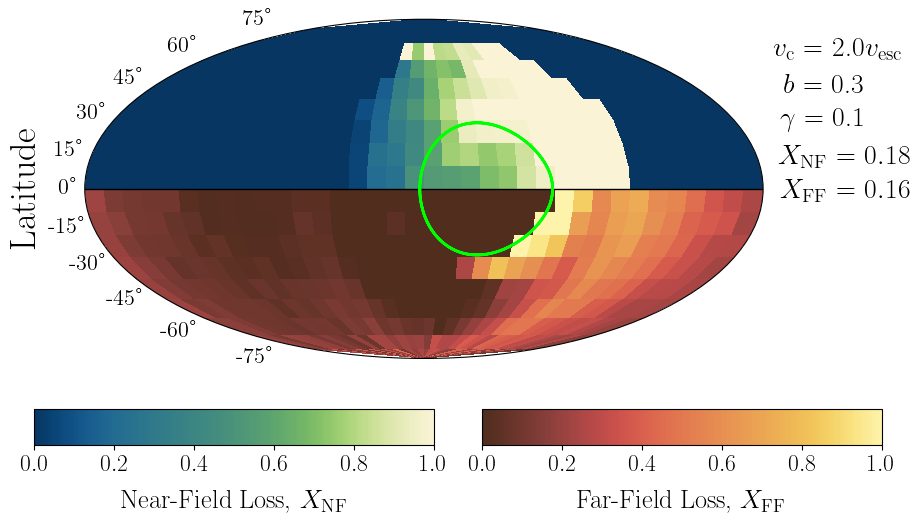

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (16, 20))
ax = fig.add_subplot(221, projection = 'mollweide')

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

data_path = '' # Add path to 'Fig14c_NF_vs_FF_map.npz' file. Data for panels a, b, and d are also available
data = np.load(data_path + 'Fig14c_NF_vs_FF_map.npz')

lon_vals = data['lon_vals']
lat_vals = data['lat_vals']
initial_cell_atmos_mass = data['initial_cell_atmos_mass']
bound_cell_atmos_mass_time = data['bound_cell_atmos_mass_time']
initial_cell_atmos_mass_near = data['initial_cell_atmos_mass_near']
bound_cell_atmos_mass_time_near = data['bound_cell_atmos_mass_time_near']
initial_cell_atmos_mass_far = data['initial_cell_atmos_mass_far']
bound_cell_atmos_mass_time_far = data['bound_cell_atmos_mass_time_far']

total_loss = 1 - (np.sum(initial_cell_atmos_mass[:, :] * bound_cell_atmos_mass_time[:, :, 1]) / np.sum(initial_cell_atmos_mass[:, :]))
near_field_loss = (1 - (np.nansum(initial_cell_atmos_mass_near[:, :] * bound_cell_atmos_mass_time_near[:, :, 1]) / np.nansum(initial_cell_atmos_mass_near[:, :]))) \
                     * (np.nansum(initial_cell_atmos_mass_near[:, :]) / np.sum(initial_cell_atmos_mass[:, :]))
far_field_loss = (1 - (np.nansum(initial_cell_atmos_mass_far[:, :] * bound_cell_atmos_mass_time_far[:, :, 1]) / np.nansum(initial_cell_atmos_mass_far[:, :]))) \
                     * (np.nansum(initial_cell_atmos_mass_far[:, :]) / np.sum(initial_cell_atmos_mass[:, :]))

# Near-field and far-field:
atmos_loss_near = ax.pcolormesh(np.deg2rad(lon_vals[9:, :]), np.deg2rad(lat_vals[9:, :]), 1-bound_cell_atmos_mass_time_near[9:, :, 1], cmap = mcolors.ListedColormap(plt.get_cmap(cm.navia)(np.linspace(0.12, 0.99, 256))), vmax = 1.0, vmin = 0, rasterized = True)
atmos_loss_far = ax.pcolormesh(np.deg2rad(lon_vals[:9, :]), np.deg2rad(lat_vals[:9, :]), 1-bound_cell_atmos_mass_time_far[:9, :, 1], cmap = mcolors.ListedColormap(plt.get_cmap(cm.lajolla)(np.linspace(0.2, 0.95, 256))), vmax = 1.0, vmin = 0, rasterized = True)
ax.axhline(0, color = 'black', linestyle = '-', linewidth = 1)

ax.text(1.204, 0.95, r"$v_{\rm c}$ = 2.0$v_{{\rm esc}}$", transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.15, 0.84, "$b$ = 0.3", transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.15, 0.74, "$\gamma$ = 0.1", transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.217, 0.63, r'$X_{{\rm NF}}$ = ${0:.2f}$'.format(near_field_loss), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.217, 0.53, r'$X_{{\rm FF}}$ = ${0:.2f}$'.format(far_field_loss), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)

ax.set_xticklabels([])
ax.set_ylabel('Latitude', fontsize = 26)
ax.yaxis.set_tick_params(labelsize = 16)

# Run plot_impactor_radius function first in Extra functions section
plot_impactor_radius(folder_path = '', # Add path to 'PLANETimpact_0d0h_target_1d05027Earth_500K_HM80_HHe_atmosphere_0d05_npt1055173_impactor_0d11069Earth_npt119232_14d63kms_0d3b_0d1gamma_pX_EiEf_100box_snap1.hdf5' file
                           first_snapshot = 'PLANETimpact_0d0h_target_1d05027Earth_500K_HM80_HHe_atmosphere_0d05_npt1055173_impactor_0d11069Earth_npt119232_14d63kms_0d3b_0d1gamma_pX_EiEf_100box_snap1.hdf5',
                           npt = 1055173,
                           lon_vals = lon_vals,
                           lat_vals = lat_vals,
                           d = 10,
                           b_imp = 0.3, # Change this to the impact parameter of the map you wish to plot
                           ax = ax)

##########################################################################################################

divider = make_axes_locatable(ax)
cax = plt.axes([0.025, 0.62, 0.25, 0.018])
cbar = plt.colorbar(atmos_loss_near, cax = cax, orientation = 'horizontal')
cbar.set_label(r'Near-Field Loss, $X_{{\rm NF}}$', fontsize = 19)
cbar.ax.get_xaxis().labelpad = 10
cbar.ax.yaxis.set_offset_position('left') 
cbar.ax.yaxis.offsetText.set_fontsize(18)
cbar.ax.tick_params(labelsize = 17) 
cbar.update_ticks()

divider = make_axes_locatable(ax)
cax = plt.axes([0.305, 0.62, 0.25, 0.018])
cbar = plt.colorbar(atmos_loss_far, cax = cax, orientation = 'horizontal')
cbar.set_label(r'Far-Field Loss, $X_{{\rm FF}}$', fontsize = 19)
cbar.ax.get_xaxis().labelpad = 10
cbar.ax.yaxis.set_offset_position('left') 
cbar.ax.yaxis.offsetText.set_fontsize(18)
cbar.ax.tick_params(labelsize = 17) 
cbar.update_ticks()

plt.tight_layout()
plt.show()

---

## Figure 15: $X_{\rm NF}$ vs. whole unbound mantle vapour fraction maps

In [ ]:
folder_path = '' # Add path to initial conditions file
IC = '' # Initial conditions file name

# Run calculate_mantle_vap function first in Extra functions section
(lat_vals,
 lon_vals,
 initial_cell_mantle_mass,
 unbound_mantle_vap_frac) = calculate_mantle_vap(folder_path,
                                         'fors_curve.txt', # Add path to 'fors_curve.txt' file
                                         npt = npt,
                                         m_tot = M_t + M_i # Total system mass in Earth masses
                                        )

# Calculate 3D near-field loss:
(lat_vals, 
 lon_vals, 
 initial_cell_atmos_mass, 
 initial_cell_atmos_mass_near, 
 _, 
 bound_cell_atmos_mass_time, 
 bound_cell_atmos_mass_time_near, 
 _) = calculate_global_loss_near_far(folder_path,
                                      max_remnant = 1,
                                      npt = npt,
                                      m_tot = M_t + M_i,
                                      output_id = 1,
                                      atmos_id = 200,
                                      near_far_idx = ('') # Add path to 'near_far_idx.npz' file (see Figure 5 for reference)
                                     )

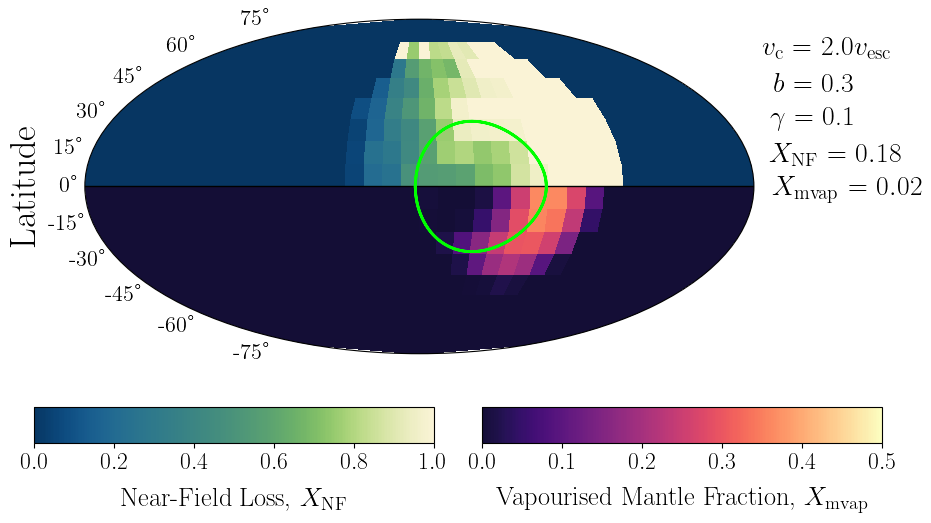

In [ ]:
fig = plt.figure(figsize = (16, 20))
ax = fig.add_subplot(221, projection = 'mollweide')

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

data_path = '' # Add path to 'Fig15c_NF_vs_mantle_vap_map.npz' file. Data for panels a, b, and d are also available
data = np.load(data_path + 'Fig15c_NF_vs_mantle_vap_map.npz')

lon_vals = data['lon_vals']
lat_vals = data['lat_vals']
initial_cell_mantle_mass = data['initial_cell_mantle_mass']
initial_cell_atmos_mass_near = data['initial_cell_atmos_mass_near']
bound_cell_atmos_mass_time_near = data['bound_cell_atmos_mass_time_near']
unbound_mantle_vap_frac = data['unbound_mantle_vap_frac']

near_field_loss = (1 - (np.nansum(initial_cell_atmos_mass_near[:, :] * bound_cell_atmos_mass_time_near[:, :, 1]) / np.nansum(initial_cell_atmos_mass_near[:, :]))) \
                     * (np.nansum(initial_cell_atmos_mass_near[:, :]) / np.sum(initial_cell_atmos_mass[:, :]))

X_mvap = (np.nansum(initial_cell_mantle_mass[:, :] * unbound_mantle_vap_frac[:, :]) / np.nansum(initial_cell_mantle_mass[:, :]))

atmos_loss_near = ax.pcolormesh(np.deg2rad(lon_vals[9:, :]), np.deg2rad(lat_vals[9:, :]), 1-bound_cell_atmos_mass_time_near[9:, :, 1], cmap = mcolors.ListedColormap(plt.get_cmap(cm.navia)(np.linspace(0.12, 0.99, 256))), vmax = 1.0, vmin = 0, rasterized = True)
mantle_vap = ax.pcolormesh(np.deg2rad(lon_vals[:9, :]), np.deg2rad(lat_vals[:9, :]), unbound_mantle_vap_frac[:9, :], cmap = mcolors.ListedColormap(plt.get_cmap('magma')(np.linspace(0.1, 1.0, 256))), vmax = 0.5, vmin = 0, rasterized = True)
ax.axhline(0, color = 'black', linestyle = '-', linewidth = 1)

ax.text(1.205, 0.95, r"$v_{\rm c}$ = 2.0$v_{{\rm esc}}$", transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.15, 0.84, "$b$ = 0.3", transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.15, 0.74, "$\gamma$ = 0.1", transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.22, 0.63, r'$X_{{\rm NF}}$ = ${0:.2f}$'.format(near_field_loss), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.25, 0.53, r'$X_{{\rm mvap}}$ = ${0:.2f}$'.format(X_mvap), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)

ax.set_xticklabels([])
ax.set_ylabel('Latitude', fontsize = 26)
ax.yaxis.set_tick_params(labelsize = 16)

plot_impactor_radius(folder_path = '', # Add path to 'PLANETimpact_0d0h_target_1d05027Earth_500K_HM80_HHe_atmosphere_0d05_npt1055173_impactor_0d11069Earth_npt119232_14d63kms_0d3b_0d1gamma_pX_EiEf_100box_snap1.hdf5' file
                           first_snapshot = 'PLANETimpact_0d0h_target_1d05027Earth_500K_HM80_HHe_atmosphere_0d05_npt1055173_impactor_0d11069Earth_npt119232_14d63kms_0d3b_0d1gamma_pX_EiEf_100box_snap1.hdf5',
                           npt = 1055173,
                           lon_vals = lon_vals,
                           lat_vals = lat_vals,
                           d = 10,
                           b_imp = 0.3, # Change this to the impact parameter of the map you wish to plot
                           ax = ax)

##########################################################################################################

divider = make_axes_locatable(ax)
cax = plt.axes([0.025, 0.62, 0.25, 0.018])
cbar = plt.colorbar(atmos_loss_near, cax = cax, orientation = 'horizontal')
cbar.set_label(r'Near-Field Loss, $X_{{\rm NF}}$', fontsize = 19)
cbar.ax.get_xaxis().labelpad = 10
cbar.ax.yaxis.set_offset_position('left') 
cbar.ax.yaxis.offsetText.set_fontsize(18)
cbar.ax.tick_params(labelsize = 17) 
cbar.update_ticks()

divider = make_axes_locatable(ax)
cax = plt.axes([0.305, 0.62, 0.25, 0.018])
cbar = plt.colorbar(mantle_vap, cax = cax, orientation = 'horizontal')
cbar.set_label(r'Vapourised Mantle Fraction, $X_{{\rm mvap}}$', fontsize = 19)
cbar.ax.get_xaxis().labelpad = 10
cbar.ax.yaxis.set_offset_position('left') 
cbar.ax.yaxis.offsetText.set_fontsize(18)
cbar.ax.tick_params(labelsize = 17) 
cbar.update_ticks()

plt.tight_layout()
plt.show()

---

## Figure 16: $X_{\rm NF}$ vs. mantle shell vapour fraction

See calculate_Xmvap_bound-unbound_shell.py file for how vapour fractions for each impact were calculated.

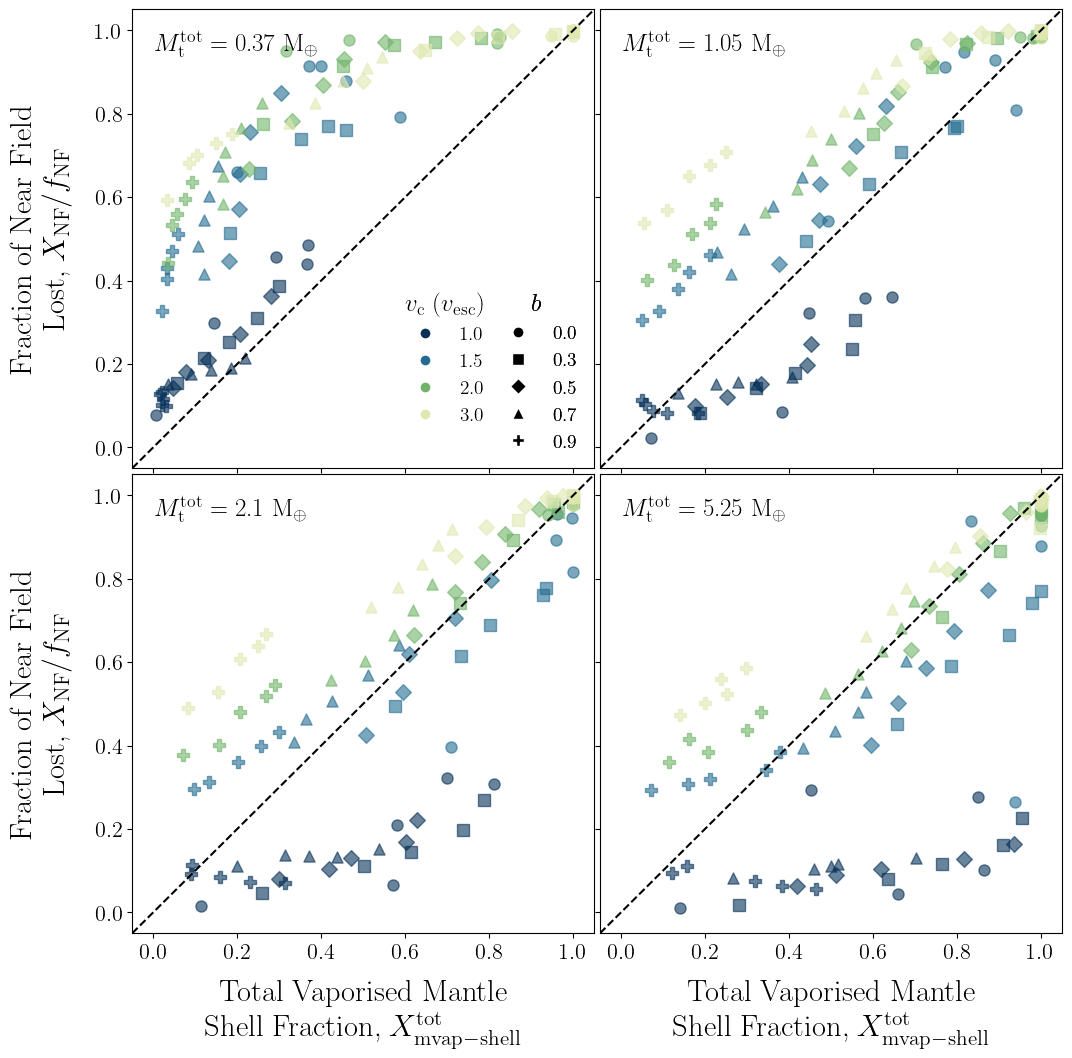

In [ ]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.013, wspace=0.012)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

folder_path = 'data_files/' # Add path to 'Fig16_mantle_vap_frac' parquet file
data = pd.read_parquet(folder_path + 'Fig16_mantle_vap_frac')
data = data.sort_values(by=['v_c_v_esc', 'b'])

# Define color mapping for v_c_v_esc
custom_spacing = [0.1, 0.3, 0.7, 0.91]
vc_to_colour = dict(zip(sorted(data.v_c_v_esc.unique()), cm.navia(custom_spacing)))

# Define marker mapping for b
b_to_marker = dict(zip(sorted(data.b.unique()), ['o', 's', 'D', '^', 'P']))

marker_size = 64  # Single size for all markers

# Loop through panels of target mass:
for k in range(4):
    ax = fig.add_subplot(gs[k])
    
    # Select target mass for this panel
    target_masses = [0.36749, 1.050265, 2.097991, 5.245433]
    M_t_current = target_masses[k]
    
    # Filter data for the current target mass
    for i, v_c_v_esc in enumerate(data.v_c_v_esc.unique()):
        for j, b_value in enumerate(data.b.unique()):
            sub_data = data[
                (data.v_c_v_esc == v_c_v_esc) & 
                (data.b == b_value) & 
                (np.isclose(data['M_t_tot'].astype(float), M_t_current, atol=1e-8))
            ]
            
            ax.scatter(
                sub_data.X_mvap,
                sub_data.X_NF / sub_data.f_NF,
                color=vc_to_colour[v_c_v_esc],  # Color by v_c_v_esc
                marker=b_to_marker[b_value],  # Shape by b
                s=marker_size,  # Fixed size
                label=f"vc: {v_c_v_esc}, b: {b_value}" if k == 0 else None,
                alpha=0.6
            )

    # Add the 1:1 line
    ax.plot([-0.05, 1.05], [-0.05, 1.05], 'k--', linewidth=1.5)

    # X and Y axis labels
    ax.set_xlabel(
        r'Total Vaporised Mantle' '\n' r'Shell Fraction, $X_{\rm mvap-shell}^{\rm tot}$' if k in [2, 3] else None, 
        fontsize=22
    )
    ax.get_xaxis().set_label_coords(0.5, -0.1)

    ax.set_ylabel(
        r'Fraction of Near Field' '\n' r'Lost, $X_{\rm NF}/f_{\rm NF}$' if k in [0, 2] else None, 
        fontsize=22
    )
    ax.get_yaxis().set_label_coords(-0.13, 0.5)

    # Add legends and labels for panel k = 0
    if k == 3:
        
        ax.tick_params(axis='y', labelleft=False)
        ax.text(0.05, 0.955, r'$M_{\rm t}^{\rm tot}$ = 5.25 M$_{\oplus}$', fontsize=18, va='top', ha='left', transform=ax.transAxes)

    elif k == 0:
        ax.text(0.05, 0.955, r'$M_{\rm t}^{\rm tot}$ = 0.37 M$_{\oplus}$', fontsize=18, va='top', ha='left', transform=ax.transAxes)
        ax.tick_params(axis='x', labelleft=False)
        
        # Velocity legend (now in colors)
        handles_vc = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=vc_to_colour[vc], markersize=8)
                      for vc in data.v_c_v_esc.unique()]
        labels_vc = [f'{vc}' for vc in data.v_c_v_esc.unique()]
        legend_vc = ax.legend(
            handles=handles_vc, 
            labels=labels_vc, 
            loc='upper right',
            bbox_to_anchor=(0.8, 0.424),
            title=r'$v_{\rm c}$ ($v_{\rm esc}$)', 
            fontsize=14, 
            title_fontsize=18, 
            facecolor='white', 
            framealpha=0.0
        )

        # Impact parameter legend (now in shapes)
        handles_b = [plt.Line2D([0], [0], marker=b_to_marker[b], color='w', markerfacecolor = 'black', markersize=8, linestyle='None')
                     for b in data.b.unique()]
        labels_b = [f'{b}' for b in data.b.unique()]
        legend_b = ax.legend(
            handles=handles_b, 
            labels=labels_b, 
            loc='lower right', 
            title='$b$', 
            fontsize=14, 
            title_fontsize=18, 
            facecolor='white', 
            framealpha=0.0
        )
        
        ax.add_artist(legend_vc)
        ax.add_artist(legend_b)
        
    elif k == 1:
        ax.text(0.05, 0.955, r'$M_{\rm t}^{\rm tot}$ = 1.05 M$_{\oplus}$', fontsize=18, va='top', ha='left', transform=ax.transAxes)
        ax.tick_params(axis='x', labelleft=False)
        ax.tick_params(axis='y', labelleft=False)
        
    elif k == 2:
        ax.text(0.05, 0.955, r'$M_{\rm t}^{\rm tot}$ = 2.1 M$_{\oplus}$', fontsize=18, va='top', ha='left', transform=ax.transAxes)

    # Set axis limits
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.tick_params(axis='both', colors='k', labelsize=16)
    
plt.tight_layout()
plt.show()

---

## Figure 17: scaling law-predicted loss vs. SPH-simulated loss

/var/folders/kj/59sk5mrx6214shnd0_nt_2z80000gq/T/ipykernel_23011/1867997418.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


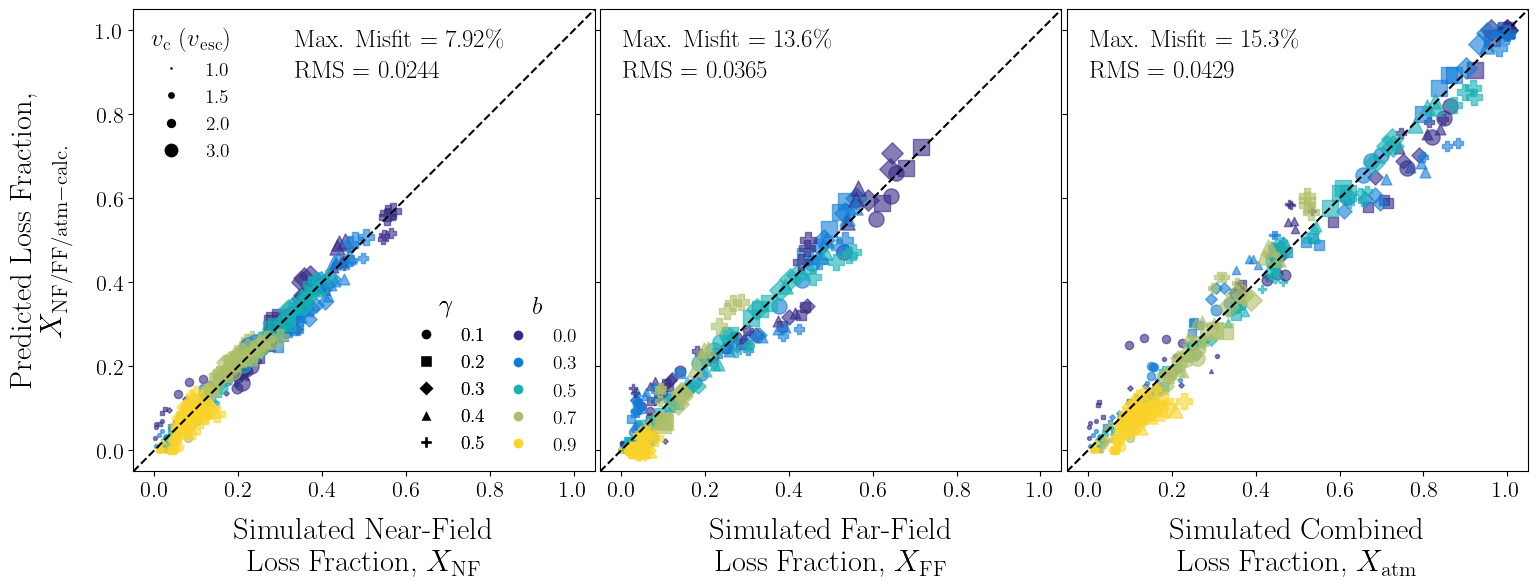

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (18, 6))
gs = gridspec.GridSpec(1, 3, figure = fig, hspace = 0.013, wspace = 0.012)

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

markers_vc = ['o', 's', 'D', '^']
markers_gamma = ['o', 's', 'D', '^', 'P']
colours = cmaps.parula(np.linspace(0, 0.9, len(data.b.unique())))
vc_to_size = dict(zip(data.v_c_v_esc.unique(), [8, 35, 60, 120]))

folder_path = '' # Add path to 'Fig17_scaling_law' parquet file
data = pd.read_parquet(folder_path + 'Fig17_scaling_law')
data = data.sort_values(by = ['gamma', 'v_c_v_esc', 'b'])

# Plot with different markers for velocity and colours for impact parameter, and panels of target mass:
for k in range(0, 3):
    
    ax = fig.add_subplot(gs[k])
    
    if k == 0:
        
        for i, (v_c_v_esc, gamma) in enumerate(data.groupby(['v_c_v_esc', 'gamma']).groups.keys()):
            for j, b_value in enumerate(data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma)].b.unique()):
                sub_data = data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma) & (data.b == b_value)]
                ax.scatter(sub_data.X_NF_data,
                        sub_data.X_NF_calc,
                        color = colours[j % len(colours)],
                        marker = markers_gamma[i % len(markers_gamma)], 
                        s = vc_to_size[v_c_v_esc],  
                        label = f"vc: {v_c_v_esc}, b: {b_value}, γ: {gamma}",
                        alpha = 0.6
                        )
        
    elif k == 1:
        
        for i, (v_c_v_esc, gamma) in enumerate(data.groupby(['v_c_v_esc', 'gamma']).groups.keys()):
            for j, b_value in enumerate(data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma)].b.unique()):
                sub_data = data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma) & (data.b == b_value)]
                ax.scatter(sub_data.X_FF_data,
                        sub_data.X_FF_calc,
                        color = colours[j % len(colours)],
                        marker = markers_gamma[i % len(markers_gamma)], 
                        s = vc_to_size[v_c_v_esc],  
                        label = f"vc: {v_c_v_esc}, b: {b_value}, γ: {gamma}",
                        alpha = 0.6
                        )
                
    elif k == 2:

        for i, (v_c_v_esc, gamma) in enumerate(data.groupby(['v_c_v_esc', 'gamma']).groups.keys()):
            for j, b_value in enumerate(data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma)].b.unique()):
                sub_data = data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma) & (data.b == b_value)]
                ax.scatter(sub_data.X_atm_data,
                        sub_data.X_atm_calc,
                        color = colours[j % len(colours)],
                        marker = markers_gamma[i % len(markers_gamma)], 
                        s = vc_to_size[v_c_v_esc],  
                        label = f"vc: {v_c_v_esc}, b: {b_value}, γ: {gamma}",
                        alpha = 0.6
                        )
    
    # Add the 1:1 line:
    ax.plot([-0.05, 1.05], [-0.05, 1.05], 'k--', linewidth = 1.5)

    if k == 0:

        # Velocity legend:
        handles_vc = [plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'black', markersize = np.sqrt(s))
                    for s in [8, 35, 60, 120]]
        labels_vc = [f'{v_c_v_esc}' for v_c_v_esc in data.v_c_v_esc.unique()]
        legend_vc = ax.legend(handles = handles_vc, labels = labels_vc, loc = 'upper left',
                            title = r'$v_{\rm c}$ ($v$\textsubscript{esc})', fontsize = 14, title_fontsize = 18, 
                            facecolor = 'white', framealpha = 0.0)
        
        # Impact parameter legend:
        handles_b = [plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = colours[i], markersize = 8)
                    for i in range(len(data.b.unique()))]
        labels_b = [f'{b}' for b in data.b.unique()]
        legend_b = ax.legend(handles = handles_b, labels = labels_b, loc = 'lower right', title = '$b$', fontsize = 14, 
                            title_fontsize = 18, facecolor = 'white', framealpha = 0.0)

        # Gamma legend:
        handles_gamma = [plt.Line2D([0], [0], marker = markers_gamma[i], color = 'w', markerfacecolor = 'black', markersize = 8)
                        for i in range(len(data.gamma.unique()))]
        labels_gamma = [f'{gamma}' for gamma in data.gamma.unique()]
        legend_gamma = ax.legend(handles = handles_gamma, labels = labels_gamma, loc = 'upper right', bbox_to_anchor = (0.8, 0.42), title = r'$\gamma$', 
                                fontsize = 14, title_fontsize = 18, facecolor = 'white', framealpha = 0.0)
        
        ax.add_artist(legend_vc)
        ax.add_artist(legend_b)
        ax.add_artist(legend_gamma)

        ax.set_ylabel(r'Predicted Loss Fraction,' '\n' r'$X_{\rm NF/FF/atm-calc.}$', fontsize = 22)
        ax.get_yaxis().set_label_coords(-0.13, 0.5)

        ax.set_xlabel(r'Simulated Near-Field' '\n' r'Loss Fraction, $X_{\rm NF}$', fontsize = 22)
        ax.get_xaxis().set_label_coords(0.5, -0.1)

        ax.text(0.35, 0.955, r'Max. Misfit = 7.92\%', fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
        ax.text(0.35, 0.89, 'RMS = 0.0244', fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
    
        
    elif k == 1:

        ax.set_xlabel(r'Simulated Far-Field' '\n' r'Loss Fraction, $X_{\rm FF}$', fontsize = 22)
        ax.get_xaxis().set_label_coords(0.5, -0.1)

        ax.tick_params(axis = 'y', labelleft = False)

        ax.text(0.05, 0.955, r'Max. Misfit = 13.6\%', fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
        ax.text(0.05, 0.89, 'RMS = 0.0365', fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)

    elif k == 2:

        ax.set_xlabel(r'Simulated Combined' '\n' r'Loss Fraction, $X_{\rm atm}$', fontsize = 22)
        ax.get_xaxis().set_label_coords(0.5, -0.1)

        ax.tick_params(axis = 'y', labelleft = False)

        ax.text(0.05, 0.955, r'Max. Misfit = 15.3\%', fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
        ax.text(0.05, 0.89, 'RMS = 0.0429', fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
        
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)

    ax.tick_params(axis = 'both', colors = 'k', labelsize = 16)
    
plt.tight_layout()
plt.show()

---

## Figure 18: $X_{\rm FF}$ vs. $X_{\rm 1D}$

/var/folders/kj/59sk5mrx6214shnd0_nt_2z80000gq/T/ipykernel_23011/713553369.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


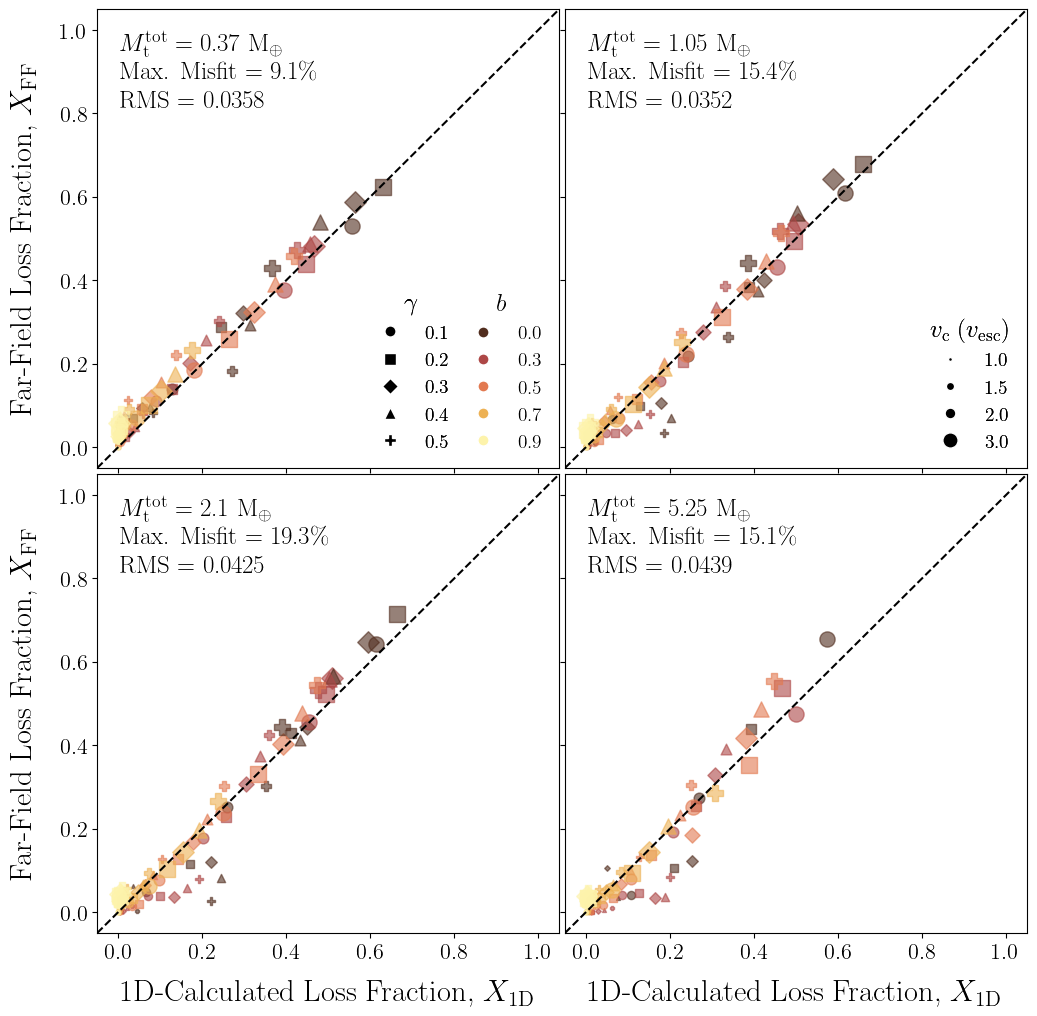

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (12, 12))
gs = gridspec.GridSpec(2, 2, figure = fig, hspace = 0.013, wspace = 0.012)

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

folder_path = '' # Add path to 'impact' parquet file
data = pd.read_parquet(folder_path + 'impacts')
data = data.sort_values(by = ['gamma', 'v_c_v_esc', 'b'])

markers_vc = ['o', 's', 'D', '^']
markers_gamma = ['o', 's', 'D', '^', 'P']
colours = cm.lajolla(np.linspace(0.2, 0.95, len(data.b.unique())))
vc_to_size = dict(zip(data.v_c_v_esc.unique(), [8, 35, 60, 120]))

# Plot with different markers for velocity and colours for impact parameter, and panels of target mass:
for k in range(0, 4):
    
    ax = fig.add_subplot(gs[k])
    
    if k == 0:
        
        for i, (v_c_v_esc, gamma) in enumerate(data.groupby(['v_c_v_esc', 'gamma']).groups.keys()):
            for j, b_value in enumerate(data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma)].b.unique()):
                sub_data = data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma) & (data.b == b_value) & (np.isclose(data['M_t_tot'].astype(float), 0.36749, atol = 1e-8))]
                ax.scatter(sub_data.X_1D,
                        sub_data.X_FF,
                        color = colours[j % len(colours)],
                        marker = markers_gamma[i % len(markers_gamma)], 
                        s = vc_to_size[v_c_v_esc],  
                        label = f"vc: {v_c_v_esc}, b: {b_value}, γ: {gamma}",
                        alpha = 0.6
                        )
        
    elif k == 1:
        
        for i, (v_c_v_esc, gamma) in enumerate(data.groupby(['v_c_v_esc', 'gamma']).groups.keys()):
            for j, b_value in enumerate(data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma)].b.unique()):
                sub_data = data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma) & (data.b == b_value) & (np.isclose(data['M_t_tot'].astype(float), 1.050265, atol = 1e-8))]
                ax.scatter(sub_data.X_1D,
                        sub_data.X_FF,
                        color = colours[j % len(colours)],
                        marker = markers_gamma[i % len(markers_gamma)], 
                        s = vc_to_size[v_c_v_esc],  
                        label = f"vc: {v_c_v_esc}, b: {b_value}, γ: {gamma}",
                        alpha = 0.6
                        )
                
    elif k == 2:

        for i, (v_c_v_esc, gamma) in enumerate(data.groupby(['v_c_v_esc', 'gamma']).groups.keys()):
            for j, b_value in enumerate(data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma)].b.unique()):
                sub_data = data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma) & (data.b == b_value) & (np.isclose(data['M_t_tot'].astype(float), 2.097991, atol = 1e-8))]
                ax.scatter(sub_data.X_1D,
                        sub_data.X_FF,
                        color = colours[j % len(colours)],
                        marker = markers_gamma[i % len(markers_gamma)], 
                        s = vc_to_size[v_c_v_esc],  
                        label = f"vc: {v_c_v_esc}, b: {b_value}, γ: {gamma}",
                        alpha = 0.6
                        )
                
    elif k == 3:

        for i, (v_c_v_esc, gamma) in enumerate(data.groupby(['v_c_v_esc', 'gamma']).groups.keys()):
            for j, b_value in enumerate(data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma)].b.unique()):
                sub_data = data[(data.v_c_v_esc == v_c_v_esc) & (data.gamma == gamma) & (data.b == b_value) & (np.isclose(data['M_t_tot'].astype(float), 5.245433, atol = 1e-8))]
                
                if (gamma == 0.4 and v_c_v_esc == 1.5 and b_value == 0) or \
                   (gamma == 0.4 and v_c_v_esc == 2.0 and b_value == 0) or \
                   (gamma == 0.4 and v_c_v_esc == 3.0 and b_value == 0.3):
                    continue
                
                ax.scatter(sub_data.X_1D,
                        sub_data.X_FF,
                        color = colours[j % len(colours)],
                        marker = markers_gamma[i % len(markers_gamma)], 
                        s = vc_to_size[v_c_v_esc],  
                        label = f"vc: {v_c_v_esc}, b: {b_value}, γ: {gamma}",
                        alpha = 0.6
                        )
    
    # Add the 1:1 line:
    ax.plot([-0.05, 1.05], [-0.05, 1.05], 'k--', linewidth = 1.5)
    
    ax.set_xlabel(r'1D-Calculated Loss Fraction, $X_{\rm 1D}$' if k == 2 or k == 3 else None, fontsize = 22)
    ax.get_xaxis().set_label_coords(0.5, -0.1)
    
    ax.set_ylabel(r'Far-Field Loss Fraction, $X_{\rm FF}$' if k == 0 or k == 2 else None, fontsize = 22)
    ax.get_yaxis().set_label_coords(-0.13, 0.5)

    if k == 0:
        
        # Impact parameter legend:
        handles_b = [plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = colours[i], markersize = 8)
                    for i in range(len(data.b.unique()))]
        labels_b = [f'{b}' for b in data.b.unique()]
        legend_b = ax.legend(handles = handles_b, labels = labels_b, loc = 'lower right', title = '$b$', fontsize = 14, 
                            title_fontsize = 18, facecolor = 'white', framealpha = 0.0)

        # Gamma legend:
        handles_gamma = [plt.Line2D([0], [0], marker = markers_gamma[i], color = 'w', markerfacecolor = 'black', markersize = 8)
                        for i in range(len(data.gamma.unique()))]
        labels_gamma = [f'{gamma}' for gamma in data.gamma.unique()]
        legend_gamma = ax.legend(handles = handles_gamma, labels = labels_gamma, loc = 'upper right', bbox_to_anchor = (0.8, 0.42), title = r'$\gamma$', 
                                fontsize = 14, title_fontsize = 18, facecolor = 'white', framealpha = 0.0)
    
        ax.add_artist(legend_b)
        ax.add_artist(legend_gamma)

        ax.text(0.05, 0.955, r'$M_{\rm t}^{\rm tot}$ = 0.37 M$_{\oplus}$', fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
        temp = data[(np.isclose(data['M_t_tot'].astype(float), 0.36749, atol = 1e-8))]
        ax.text(0.05, 0.885, r'Max. Misfit = {0:.1f}\%'.format(np.max(abs(temp["misfit"])) * 100), fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
        ax.text(0.05, 0.825, 'RMS = {0:.4f}'.format(np.sqrt(np.mean(abs(temp["misfit"]**2)))), fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
    
        ax.tick_params(axis = 'x', labelleft = False)
        
    elif k == 1:
        
        # Velocity legend:
        handles_vc = [plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'black', markersize = np.sqrt(s))
                    for s in [8, 35, 60, 120]]
        labels_vc = [f'{v_c_v_esc}' for v_c_v_esc in data.v_c_v_esc.unique()]
        legend_vc = ax.legend(handles = handles_vc, labels = labels_vc, loc = 'lower right',
                            title = r'$v_{\rm c}$ ($v_{\rm esc}$)', fontsize = 14, title_fontsize = 18, 
                            facecolor = 'white', framealpha = 0.0)
        ax.add_artist(legend_vc)

        ax.tick_params(axis = 'x', labelleft = False)
        ax.tick_params(axis = 'y', labelleft = False)

        ax.text(0.05, 0.955, r'$M_{\rm t}^{\rm tot}$ = 1.05 M$_{\oplus}$', fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
        temp = data[(np.isclose(data['M_t_tot'].astype(float), 1.050265, atol = 1e-8))]
        ax.text(0.05, 0.885, r'Max. Misfit = {0:.1f}\%'.format(np.max(abs(temp["misfit"])) * 100), fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
        ax.text(0.05, 0.825, 'RMS = {0:.4f}'.format(np.sqrt(np.mean(abs(temp["misfit"]**2)))), fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)

    elif k == 2:

        ax.text(0.05, 0.955, r'$M_{\rm t}^{\rm tot}$ = 2.1 M$_{\oplus}$', fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
        temp = data[(np.isclose(data['M_t_tot'].astype(float), 2.097991, atol = 1e-8))]
        ax.text(0.05, 0.885, r'Max. Misfit = {0:.1f}\%'.format(np.max(abs(temp["misfit"])) * 100), fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
        ax.text(0.05, 0.825, 'RMS = {0:.4f}'.format(np.sqrt(np.mean(abs(temp["misfit"]**2)))), fontsize = 18, va = 'top', ha = 'left', transform = ax.transAxes)
        
    elif k == 3:

        ax.tick_params(axis = 'y', labelleft = False)

        temp = data[np.isclose(data['M_t_tot'].astype(float), 5.24543, atol=1e-8)]
        temp = temp[~(
            ((temp['gamma'] == 0.4) & (temp['v_c_v_esc'] == 1.5) & (temp['b'] == 0)) |
            ((temp['gamma'] == 0.4) & (temp['v_c_v_esc'] == 2.0) & (temp['b'] == 0)) |
            ((temp['gamma'] == 0.4) & (temp['v_c_v_esc'] == 3.0) & (temp['b'] == 0.3))
        )]
        
        ax.text(0.05, 0.955, r'$M_{\rm t}^{\rm tot}$ = 5.25 M$_{\oplus}$', fontsize=18, va='top', ha='left', transform=ax.transAxes)
        ax.text(0.05, 0.885, r'Max. Misfit = {0:.1f}\%'.format(np.max(abs(temp["misfit"])) * 100), fontsize=18, va='top', ha='left', transform=ax.transAxes)
        ax.text(0.05, 0.825, 'RMS = {0:.4f}'.format(np.sqrt(np.mean(abs(temp["misfit"]**2)))), fontsize=18, va='top', ha='left', transform=ax.transAxes)
        
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)

    ax.tick_params(axis = 'both', colors = 'k', labelsize = 16)
    
plt.tight_layout()
plt.show()

---

## Figure 19: $X_{\rm FF}$ vs. $X_{\rm 1D}$ maps

In [ ]:
def calculate_atmos_loss_1D(folder_path = None,
                            IC = None,
                            npt = 1e9,
                            interp_hull_path = None,
                            b = 0.0,
                            vc = 1.0,
                            gamma = 0.1,
                            m_tot = 1,
                            NF_idx_path = None
                            
):
    
    """ Calculates 1D far-field atmospheric loss and plots a map of far-field loss vs. the 1D prediction.
    
    Args:
        folder_path: path to simulation output files
        IC: initial conditions file name
        npt: number of particles in the target
        interp_hull_path: path to the interpolation hull .npz file used in calculating the impedance match between the 'true' planet's surface and the atmosphere. For the 1.05 M_Earth
            planet this file is IM_loss_calc_interp_1d0503Earth_500K_HM80_HHe_atmosphere_0d05_p0_1d9GPa.npz.
        b: impact parameter
        vc: impact velocity in units of the mutual escape velocity
        gamma: impactor-to-total system mass ratio
        m_tot: total system mass in Earth masses
        NF_idx_path: path to the near/far field particle indices file (see example in Figure 5)
    """
    
    id_body = 2e8
    
    # Load the IC file:
    (id, mat_id, m, pos, vel, p, rho, u, time) = load_IC(folder_path + IC)

    # Index particles from the target and impactor separately based on their material IDs:
    ind_tar = np.where(np.logical_or(mat_id == 400, mat_id == 401))[0]
    ind_tar_all = np.where(np.logical_or(np.logical_or(mat_id == 400, mat_id == 401), mat_id == 200))[0]
    ind_imp = np.where(np.logical_or(mat_id == 400 + id_body, mat_id == 401 + id_body))[0]

    pos_tar = pos[ind_tar]
    
    m_tar = np.sum(m[ind_tar_all])
    m_imp = np.sum(m[ind_imp])
    
    # Centre the arrays on the centre of mass of the target and impactor, respectively:
    pos_com_tar = np.sum(pos_tar * m[ind_tar,np.newaxis], axis = 0) / np.sum(m[ind_tar])
    pos_tar -= pos_com_tar

    # Calculate the radii of the planets and sort the array:
    r_tar = np.sqrt(pos_tar[:,0]**2 + pos_tar[:,1]**2 + pos_tar[:,2]**2)

    # Select the top 10% of particles:
    tar_shell_0d2 = np.where(r_tar >= np.percentile(r_tar, 80))[0]
    id_tar_shell_0d2 = id[ind_tar[tar_shell_0d2]] # Keep these indices constant for each snapshot

    # Find the indices of the surface particles from their ID numbers:
    tar_shell_from_id_0d2 = np.in1d(id_tar_shell_0d2, id)
    ind_tar_0d2 = id.searchsorted(id_tar_shell_0d2)

    pos_tar_surface_0d2 = pos[ind_tar_0d2]
    pos_tar_surface_0d2[tar_shell_from_id_0d2 == False] = 0
    pos_tar_surface_0d2 -= pos_com_tar

    r_tar_surface_0d2 = np.sqrt(pos_tar_surface_0d2[:,0]**2 + pos_tar_surface_0d2[:,1]**2 + pos_tar_surface_0d2[:,2]**2)

    p_tar_surface_0d2 = p[ind_tar_0d2] 
    p_tar_surface_0d2[tar_shell_from_id_0d2 == False] = 0

    # Calculate latitude and longitude:
    latitude_tar_0d2 = np.arctan(pos_tar_surface_0d2[:,2]/np.sqrt(pos_tar_surface_0d2[:,0]**2 + pos_tar_surface_0d2[:,1]**2))
    longitude_tar_0d2 = np.arccos(pos_tar_surface_0d2[:,0]/np.sqrt(pos_tar_surface_0d2[:,0]**2 + pos_tar_surface_0d2[:,1]**2)) * np.sign(pos_tar_surface_0d2[:,1])
    
    ##############################################################################
    # Use k-means clustering to define the surface:
    data = list(zip(r_tar_surface_0d2, p_tar_surface_0d2))
    
    # Fit KMeans and get labels:
    kmeans = KMeans(n_clusters = 3)
    kmeans.fit(data)
    labels = kmeans.labels_

    # Calculate the mean radius and mean pressure for each cluster:
    mean_radii = []
    mean_pressures = []
    for i in range(3): 
        mean_radii.append(np.mean(r_tar_surface_0d2[labels == i]))
        mean_pressures.append(np.mean(p_tar_surface_0d2[labels == i]))

    # Determine the correct cluster labels based on mean radius and pressure:
    # Sort by mean radius ascending (smallest to largest):
    sorted_by_radius = np.argsort(mean_radii)

    # To distinguish between middle and inner clusters, consider the mean pressure:
    if mean_pressures[sorted_by_radius[0]] > mean_pressures[sorted_by_radius[1]]:
        idx_inner = np.where(labels == sorted_by_radius[0])[0]
        idx_middle = np.where(labels == sorted_by_radius[1])[0]
    else:
        idx_inner = np.where(labels == sorted_by_radius[1])[0]
        idx_middle = np.where(labels == sorted_by_radius[0])[0]

    idx_outer = np.where(labels == sorted_by_radius[2])[0]
    
    ##############################################################################
    # Now discard the outer particles and take 5% of the upper mantle to define as the surface:
    ind_tar_reduced = np.setdiff1d(ind_tar, ind_tar_0d2[idx_outer])
    pos_tar = pos[ind_tar_reduced]

    # Centre the arrays on the centre of mass of the target and impactor, respectively:
    pos_com_tar = np.sum(pos_tar * m[ind_tar_reduced, np.newaxis], axis = 0) / np.sum(m[ind_tar_reduced])
    pos_tar -= pos_com_tar

    # Calculate the radii of the planets and sort the array:
    r_tar = np.sqrt(pos_tar[:,0]**2 + pos_tar[:,1]**2 + pos_tar[:,2]**2)

    tar_shell_0d03 = np.where(r_tar >= np.percentile(r_tar, 97))[0] # 96.88
    id_tar_shell_0d03 = id[ind_tar_reduced[tar_shell_0d03]] # Keep these indices constant for each snapshot

    # Find the indices of the surface particles from their ID numbers:
    tar_shell_from_id_0d03 = np.in1d(id_tar_shell_0d03, id)
    ind_tar_0d03 = id.searchsorted(id_tar_shell_0d03)

    pos_tar_surface_0d03 = pos[ind_tar_0d03]
    pos_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0
    pos_tar_surface_0d03 -= pos_com_tar

    r_tar_surface_0d03 = np.sqrt(pos_tar_surface_0d03[:,0]**2 + pos_tar_surface_0d03[:,1]**2 + pos_tar_surface_0d03[:,2]**2)

    p_tar_surface_0d03 = p[ind_tar_0d03] 
    p_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0

    # Calculate latitude and longitude:
    latitude_tar_0d03 = np.arctan(pos_tar_surface_0d03[:,2]/np.sqrt(pos_tar_surface_0d03[:,0]**2 + pos_tar_surface_0d03[:,1]**2))
    longitude_tar_0d03 = np.arccos(pos_tar_surface_0d03[:,0]/np.sqrt(pos_tar_surface_0d03[:,0]**2 + pos_tar_surface_0d03[:,1]**2)) * np.sign(pos_tar_surface_0d03[:,1])
    
    ##############################################################################
    # Order files in the directory numerically regardless of whether they are a snapshot or snipshot:
    all_files = os.listdir(folder_path)

    # Filter out only files that end in '.hdf5' and start with 'snapshot' or 'snipshot' just to be sure:
    filtered_files = [file for file in all_files if file.endswith('.hdf5') and ('snapshot' in file or 'snipshot' in file)]

    # Sort them numerically:
    snap_and_snip = sorted(filtered_files, key = lambda x: int(''.join(filter(str.isdigit, x)))) # For every file in filtered_files, access the numbers only, stitch them back together
                                                                                                 # and convert to an integer, and sort filtered_files based on this

    # Access just the snapshots, and select those for a subset between 0.5 and 2.5 hrs:
    snapshots = [file for file in all_files if file.endswith('.hdf5') and 'snapshot' in file]
    snapshots = sorted(snapshots, key = lambda x: int(''.join(filter(str.isdigit, x))))
    snapshots_subset = snapshots[18:7218]

    # Select a subset of only between 0.0 and 2.5 hrs:
    snap_and_snip_subset = snap_and_snip[0:7218]
    
    ##############################################################################
    # Read for subsequent snapshots:
    p_tar_surface_time_0d03 = np.ones((len(id_tar_shell_0d03), len(snap_and_snip_subset))) * np.NaN
    pot_tar_surface_time_0d03 = np.ones((len(id_tar_shell_0d03), len(snapshots_subset))) * np.NaN
    vel_tar_surface_mag_time_0d03 = np.ones((len(id_tar_shell_0d03), len(snapshots_subset))) * np.NaN
    t = []

    count_snap = 0
    
    for i, file in enumerate(snap_and_snip_subset):

        # Load data for the first snapshot:
        data = sw.load(folder_path + file)

        id = data.gas.particle_ids
        npt = npt
        id_body = 2e8

        sort = np.argsort(id)
        id = id[sort]

        data.gas.pressures.convert_to_mks()
        p = np.array(data.gas.pressures)
        p = p[sort]

        time = int(data.metadata.t)
        t.append(time)

        # Find the indices of the surface particles from their ID numbers:
        tar_shell_from_id_0d03 = np.in1d(id_tar_shell_0d03, id)
        ind_tar_0d03 = id.searchsorted(id_tar_shell_0d03)

        p_tar_surface_0d03 = p[ind_tar_0d03] 
        p_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0
        p_tar_surface_time_0d03[:, i] = p_tar_surface_0d03

        # Access the potentials from the snapshots:
        if file.startswith("snapshot"):
            m = np.array(data.gas.masses)
            m = m[sort]

            data.gas.potentials.convert_to_mks()
            pot = np.array(data.gas.potentials)
            pot = pot[sort]

            pot_tar_surface_0d03 = pot[ind_tar_0d03]
            pot_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0
            pot_tar_surface_time_0d03[:, count_snap] = pot_tar_surface_0d03

            data.gas.velocities.convert_to_mks()
            vel = np.array(data.gas.velocities)
            vel = vel[sort]

            temp = np.where(np.logical_or(mat_id == 400, mat_id == 401))[0]
            vel_tar = vel[temp]
            vel_com_tar = np.sum(vel_tar * m[temp, np.newaxis], axis = 0) / np.sum(m[temp])
            vel_tar -= vel_com_tar

            vel_tar_surface_0d03 = vel[ind_tar_0d03]
            vel_tar_surface_0d03[tar_shell_from_id_0d03 == False] = 0
            vel_tar_surface_0d03 -= vel_com_tar
            vel_tar_surface_mag_0d03 = np.sqrt(vel_tar_surface_0d03[:, 0]**2 + vel_tar_surface_0d03[:, 1]**2 + vel_tar_surface_0d03[:, 2]**2)
            vel_tar_surface_mag_time_0d03[:, count_snap] = vel_tar_surface_mag_0d03

            count_snap += 1
            
    ##############################################################################
    # Initialize arrays to store the peak pressures and times for each grid cell:
    t_hrs = np.asarray(t)/3600
    first_peak_pressure = np.zeros(len(id_tar_shell_0d03))
    time_first_peak_pressure = np.zeros(len(id_tar_shell_0d03))

    ind_tar_atmos = np.where(mat_id == 200)[0]
    pos_tar_atmos = pos[ind_tar_atmos]
    pos_tar_atmos -= pos_com_tar
    r_tar_atmos = np.mean(np.sort(np.sqrt(pos_tar_atmos[:,0]**2 + pos_tar_atmos[:,1]**2 + pos_tar_atmos[:,2]**2))[-100:]) - np.mean(np.sort(r_tar)[-100:])
    r_tar_solid = np.mean(np.sort(r_tar)[-100:])

    v_i = float(vc) * np.sqrt(2*G*(m_tar*M_earth + m_imp*M_earth)/(m_tar**0.25*R_earth + m_imp**0.25*R_earth))
    
    if b == 0.0:
        h = r_tar_atmos
    else:
        h = -r_tar_solid * np.cos(np.arcsin(b)) + np.sqrt(r_tar_solid**2 * np.cos(np.arcsin(b))**2 + r_tar_atmos**2 + (2 * r_tar_atmos * r_tar_solid))

    delta_t = h / v_i

    # Loop over each particle:
    for i in range(len(id_tar_shell_0d03)):

        # Extract pressure data for the current particle:
        p = p_tar_surface_time_0d03[i, :] / 1e9

        # Find the index of the first peak:
        peak_idx = peak_finder(p)

        ind = np.where(np.logical_and(t_hrs[peak_idx] < t_hrs, t_hrs < t_hrs[peak_idx] + delta_t))[0]
        p_max = np.max(p[ind])

        if p_max > 1.05 * p[peak_idx]:
            peak_idx_2 = peak_finder(p[peak_idx+1:]) + peak_idx + 1

            if (p[peak_idx_2] < p[peak_idx]) | (t_hrs[peak_idx_2] - t_hrs[peak_idx] > delta_t):
                first_peak_pressure[i] = p[peak_idx]
                time_first_peak_pressure[i] = t_hrs[peak_idx]
            else:
                first_peak_pressure[i] = p[peak_idx_2]
                time_first_peak_pressure[i] = t_hrs[peak_idx_2]
        else:
            first_peak_pressure[i] = p[peak_idx]
            time_first_peak_pressure[i] = t_hrs[peak_idx]

    first_peak_pressure = first_peak_pressure * 1e9

    ##############################################################################
    # Calculate the escape velocity above each grid cell from the potentials:
    ind_snap_from_all = np.concatenate((np.arange(0, 18), np.arange(18, 7218, 100)))

    v_esc = np.zeros(len(id_tar_shell_0d03))

    for i in range(len(id_tar_shell_0d03)):
        idx = (np.abs(t_hrs[ind_snap_from_all] - time_first_peak_pressure[i])).argmin()

        # Interpolate to find the actual time:
        if idx == len(ind_snap_from_all) - 1:
            # Handle the case where idx is at the last element
            v_esc[i] = np.sqrt(2 * abs(pot_tar_surface_time_0d03[i, idx]))
        elif t_hrs[ind_snap_from_all[idx]] < time_first_peak_pressure[i]:
            v_esc[i] = ((t_hrs[ind_snap_from_all[idx + 1]] - time_first_peak_pressure[i]) * np.sqrt(2 * abs(pot_tar_surface_time_0d03[i, idx])) \
            - (t_hrs[ind_snap_from_all[idx]] - time_first_peak_pressure[i]) * np.sqrt(2 * abs(pot_tar_surface_time_0d03[i, idx + 1]))) \
            / (t_hrs[ind_snap_from_all[idx + 1]] - t_hrs[ind_snap_from_all[idx]])
        else:
            v_esc[i] = ((t_hrs[ind_snap_from_all[idx]] - time_first_peak_pressure[i]) * np.sqrt(2 * abs(pot_tar_surface_time_0d03[i, idx - 1])) \
            - (t_hrs[ind_snap_from_all[idx - 1]] - time_first_peak_pressure[i]) * np.sqrt(2 * abs(pot_tar_surface_time_0d03[i, idx]))) \
            / (t_hrs[ind_snap_from_all[idx]] - t_hrs[ind_snap_from_all[idx - 1]])
            
    ##############################################################################
    # Calculate 1D loss:
    interp_hull = np.load(interp_hull_path)
    interp_ug_load = sp.interpolate.RegularGridInterpolator((interp_hull['ppeak_mantle'], 
                                                             interp_hull['p0_mantle']),
                                                             interp_hull['ug'],
                                                             bounds_error = False,
                                                             fill_value = None)

    loss_calc = np.ones(len(id_tar_shell_0d03)) * np.nan
    ind = np.where((first_peak_pressure > p_tar_surface_time_0d03[:, 0].flatten()) & (p_tar_surface_time_0d03[:, 0].flatten() > 0e9) & (first_peak_pressure < 3e12))
    loss_calc[ind] = calc_loss_interp(first_peak_pressure[ind], p_tar_surface_time_0d03[ind, 0].flatten(), v_esc[ind], interp_ug_load) # See 1D_loss_functions.py
    
    ##############################################################################
    # Calculate 3D far-field loss:
    (lat_vals, 
     lon_vals, 
     initial_cell_atmos_mass, 
     initial_cell_atmos_mass_near_MC, 
     initial_cell_atmos_mass_far_MC, 
     bound_cell_atmos_mass_time, 
     bound_cell_atmos_mass_time_near_MC, 
     bound_cell_atmos_mass_time_far_MC) = calculate_global_loss_near_far(folder_path = folder_path,
                                                                         max_remnant = 1,
                                                                         npt = npt,
                                                                         m_tot = m_tot,
                                                                         output_id = 1,
                                                                         atmos_id = 200,
                                                                         near_far_idx = NF_idx_path)
    
    ##############################################################################
    # Define the grid boundaries:
    lat_min, lat_max = -90, 90
    lon_min, lon_max = -180, 180
    d = 10  # side length of grid cells in degrees

    # Calculate the number of grid cells in each direction:
    n_lat = int(np.ceil((lat_max - lat_min) / d))
    n_lon = int(np.ceil((lon_max - lon_min) / d))

    loss_calc_grid_median = [[None for x in range(n_lon)] for y in range(n_lat)]
    loss_calc_grid_median_far = [[None for x in range(n_lon)] for y in range(n_lat)]
    id_grid = [[None for x in range(n_lon)] for y in range(n_lat)]
    lat_vals = np.zeros((n_lat, n_lon))
    lon_vals = np.zeros((n_lat, n_lon))

    # Loop over each grid cell:
    for i in range(n_lat):

        for j in range(n_lon):

            # Calculate the latitude and longitude ranges for this grid cell:
            lat_range = [lat_min + i*d, lat_min + (i+1)*d]
            lon_range = [lon_min + j*d, lon_min + (j+1)*d]

            # Store the first value of lat_range and lon_range for this grid cell:
            lat_vals[i, j] = lat_range[0] + d/2
            lon_vals[i, j] = lon_range[0] + d/2

            # Find the indices of data points within this grid cell:
            mask_tar = (latitude_tar_0d03*180/np.pi >= lat_range[0]) & (latitude_tar_0d03*180/np.pi < lat_range[1]) & (longitude_tar_0d03*180/np.pi >= lon_range[0]) & (longitude_tar_0d03*180/np.pi < lon_range[1])
            idx_tar = np.where(mask_tar)[0]

            if len(idx_tar) > 0:
                loss_calc_grid_median[i][j] = np.nanmedian(loss_calc[idx_tar])
                loss_calc_grid_median_far[i][j] = np.nanmedian(loss_calc[idx_tar]) * initial_cell_atmos_mass_far_MC[i, j]/initial_cell_atmos_mass[i, j]
                id_grid[i][j] = idx_tar
            else:
                loss_calc_grid_median[i][j] = np.nan
                loss_calc_grid_median_far[i][j] = np.nan
                id_grid[i][j] = []

    loss_calc_grid_median = np.asarray(loss_calc_grid_median)
    loss_calc_grid_median_far = np.asarray(loss_calc_grid_median_far)
    
    far_field_loss_3D = (1 - (np.nansum(initial_cell_atmos_mass_far_MC[:, :] * bound_cell_atmos_mass_time_far_MC[:, :, 1]) / np.nansum(initial_cell_atmos_mass_far_MC[:, :]))) \
                         * (np.nansum(initial_cell_atmos_mass_far_MC[:, :]) / np.sum(initial_cell_atmos_mass[:, :]))
    
    far_field_loss_1D = (np.sum(initial_cell_atmos_mass_far_MC[:, :]*loss_calc_grid_median_far) / np.sum(initial_cell_atmos_mass_far_MC[:, :])) \
                     * (np.nansum(initial_cell_atmos_mass_far_MC[:, :]) / np.sum(initial_cell_atmos_mass[:, :]))
    
    ##############################################################################
    # Find the near-field only grid cells from the 3D and mask those grid cells to plot only the far-field in the 1D/lower-hemisphere:
    NF_mask = np.zeros_like(bound_cell_atmos_mass_time_far_MC[:, :, 1], dtype = bool)
    NF_mask[:np.isnan(bound_cell_atmos_mass_time_far_MC[:, :, 1]).shape[0], :] = np.isnan(bound_cell_atmos_mass_time_far_MC[:, :, 1])

    # Apply the mask to the 1D data:
    loss_calc_grid_median = np.ma.masked_where(NF_mask, loss_calc_grid_median[:, :])
    
    # Plot a map:
    fig = plt.figure(figsize = (16, 20))
    ax = fig.add_subplot(221, projection = 'mollweide')

    plt.rc('text', usetex = True)
    plt.rc('font', family = 'serif')
    
    atmos_loss_3D = ax.pcolormesh(np.deg2rad(lon_vals[9:, :]), np.deg2rad(lat_vals[9:, :]), 1-bound_cell_atmos_mass_time_far_MC[9:, :, 1], cmap = mcolors.ListedColormap(plt.get_cmap(cm.lajolla)(np.linspace(0.2, 0.95, 256))), vmax = 1.0, vmin = 0, rasterized = True)
    atmos_loss_1D = ax.pcolormesh(np.deg2rad(lon_vals[:9, :]), np.deg2rad(lat_vals[:9, :]), loss_calc_grid_median[:9, :], cmap = mcolors.ListedColormap(plt.get_cmap(cm.lajolla)(np.linspace(0.2, 0.95, 256))), vmax = 1.0, vmin = 0, rasterized = True)

    ax.axhline(0, color = 'black', linestyle = '-', linewidth = 1)

    if vc == 1.0:
        ax.text(1.158, 0.95, r"$v_{{\rm c}}$ = $v_{{\rm esc}}$".format(vc), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
    else:
        ax.text(1.2075, 0.95, r"$v_{{\rm c}}$ = ${0}v_{{\rm esc}}$".format(vc), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
    ax.text(1.155, 0.84,"$b$ = ${0}$".format(b), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
    ax.text(1.155, 0.74,"$\gamma$ = ${0}$".format(gamma), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
    ax.text(1.22, 0.63, r'$X_{{\rm FF}}$ = ${0:.2f}$'.format(far_field_loss_3D), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
    ax.text(1.22, 0.53, r'$X_{{\rm 1D}}$ = ${0:.2f}$'.format(far_field_loss_1D), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)

    ax.set_xticklabels([])
    ax.set_ylabel('Latitude', fontsize = 26)
    ax.yaxis.set_tick_params(labelsize = 16)

    plot_impactor_radius(folder_path = folder_path,
                               first_snapshot = 'snapshot_1.hdf5',
                               npt = npt,
                               lon_vals = lon_vals,
                               lat_vals = lat_vals,
                               d = 10,
                               b_imp = b,
                               ax = ax)

    ##########################################################################################################

    divider = make_axes_locatable(ax)
    cax = plt.axes([0.13, 0.62, 0.25, 0.018])
    cbar = plt.colorbar(atmos_loss_3D, cax = cax, orientation = 'horizontal')
    cbar.set_label(r'Far-Field/1D Loss Fraction, $X_{{\rm FF/1D}}$', fontsize = 19)
    cbar.ax.get_xaxis().labelpad = 10
    cbar.ax.yaxis.set_offset_position('left') 
    cbar.ax.yaxis.offsetText.set_fontsize(18)
    cbar.ax.tick_params(labelsize = 17) 
    cbar.update_ticks()

    plt.tight_layout()

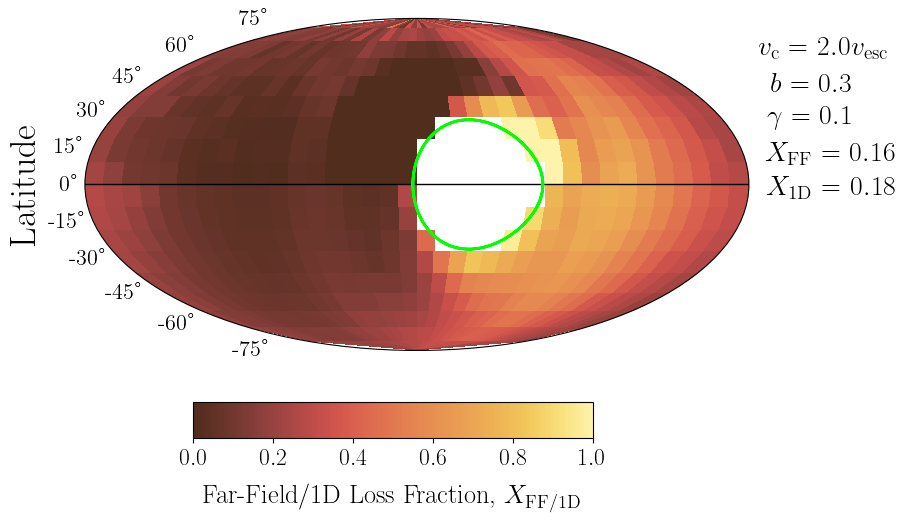

In [ ]:
data_path = '' # Add path to 'Fig19c_FF_vs_1D_map.npz' file. Data for panels a, b, and d are also available
data = np.load(data_path + 'Fig19c_FF_vs_1D_map.npz')

lon_vals = data['lon_vals']
lat_vals = data['lat_vals']
initial_cell_atmos_mass = data['initial_cell_atmos_mass']
initial_cell_atmos_mass_far = data['initial_cell_atmos_mass_far']
bound_cell_atmos_mass_time_far = data['bound_cell_atmos_mass_time_far']
loss_calc_grid_median = data['loss_calc_grid_median']
far_field_loss_1D = data['far_field_loss_1D']

# Find the near-field only grid cells from the 3D and mask those grid cells to plot only the far-field in the 1D/lower-hemisphere:
NF_mask = np.zeros_like(bound_cell_atmos_mass_time_far[:, :, 1], dtype = bool)
NF_mask[:np.isnan(bound_cell_atmos_mass_time_far[:, :, 1]).shape[0], :] = np.isnan(bound_cell_atmos_mass_time_far[:, :, 1])

# Apply the mask to the 1D data:
loss_calc_grid_median = np.ma.masked_where(NF_mask, loss_calc_grid_median[:, :])

# Plot a map:
%matplotlib inline
fig = plt.figure(figsize = (16, 20))
ax = fig.add_subplot(221, projection = 'mollweide')

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

# Atmospheric loss over time:
far_field_loss_3D = (1 - (np.nansum(initial_cell_atmos_mass_far[:, :] * bound_cell_atmos_mass_time_far[:, :, 1]) / np.nansum(initial_cell_atmos_mass_far[:, :]))) \
                         * (np.nansum(initial_cell_atmos_mass_far[:, :]) / np.sum(initial_cell_atmos_mass[:, :]))

atmos_loss_3D = ax.pcolormesh(np.deg2rad(lon_vals[9:, :]), np.deg2rad(lat_vals[9:, :]), 1-bound_cell_atmos_mass_time_far[9:, :, 1], cmap = mcolors.ListedColormap(plt.get_cmap(cm.lajolla)(np.linspace(0.2, 0.95, 256))), vmax = 1.0, vmin = 0, rasterized = True)
atmos_loss_1D = ax.pcolormesh(np.deg2rad(lon_vals[:9, :]), np.deg2rad(lat_vals[:9, :]), loss_calc_grid_median[:9, :], cmap = mcolors.ListedColormap(plt.get_cmap(cm.lajolla)(np.linspace(0.2, 0.95, 256))), vmax = 1.0, vmin = 0, rasterized = True) 

ax.axhline(0, color = 'black', linestyle = '-', linewidth = 1)

ax.text(1.208, 0.95, r"$v_{{\rm c}}$ = ${0}v_{{\rm esc}}$".format(2.0), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.155, 0.84,"$b$ = ${0}$".format(0.3), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.155, 0.74,"$\gamma$ = ${0}$".format(0.1), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.22, 0.63, r'$X_{{\rm FF}}$ = ${0:.2f}$'.format(far_field_loss_3D), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)
ax.text(1.22, 0.53, r'$X_{{\rm 1D}}$ = ${0:.2f}$'.format(far_field_loss_1D), transform = ax.transAxes, ha = 'right', va = 'top', fontsize = 20)

ax.set_xticklabels([])
ax.set_ylabel('Latitude', fontsize = 26)
ax.yaxis.set_tick_params(labelsize = 16)

# Run plot_impactor_radius function first in Extra functions section
plot_impactor_radius(folder_path = '', # Add path to 'PLANETimpact_0d0h_target_1d05027Earth_500K_HM80_HHe_atmosphere_0d05_npt1055173_impactor_0d11069Earth_npt119232_14d63kms_0d3b_0d1gamma_pX_EiEf_100box_snap1.hdf5' file
                           first_snapshot = 'PLANETimpact_0d0h_target_1d05027Earth_500K_HM80_HHe_atmosphere_0d05_npt1055173_impactor_0d11069Earth_npt119232_14d63kms_0d3b_0d1gamma_pX_EiEf_100box_snap1.hdf5',
                           npt = 1055173,
                           lon_vals = lon_vals,
                           lat_vals = lat_vals,
                           d = 10,
                           b_imp = 0.3, # Change this to the impact parameter of the map you wish to plot
                           ax = ax)

##########################################################################################################

divider = make_axes_locatable(ax)
cax = plt.axes([0.13, 0.62, 0.25, 0.018])
cbar = plt.colorbar(atmos_loss_3D, cax = cax, orientation = 'horizontal')
cbar.set_label(r'Far-Field/1D Loss Fraction, $X_{{\rm FF/1D}}$', fontsize = 19)
cbar.ax.get_xaxis().labelpad = 10
cbar.ax.yaxis.set_offset_position('left') 
cbar.ax.yaxis.offsetText.set_fontsize(18)
cbar.ax.tick_params(labelsize = 17) 
cbar.update_ticks()

plt.tight_layout()
plt.show()

---

## Figure 20: K20b scaling law comparison

In [ ]:
def Q_S_calc(R_t = None,
            R_i = None,
            M_t = None,
            M_i = None,
            b = None,
            v_c = None
            ):
    
    B = (R_t + R_i) * b

    condition = B + R_i <= R_t
    l = np.where(condition, 2 * R_i, R_t + R_i - B) # Projected length of the projectile overlapping the target
    alpha = np.where(condition, 1.0, (3 * R_i * l**2 - l**3) / (4 * R_i**3))
    
    M_tot = M_t + M_i # Total system mass
    mu = (M_t * M_i) / M_tot # Reduced mass
    mu_alpha = (alpha * M_t * M_i) / ((alpha * M_i) + M_t) # Reduced mass for the overlapping region
    Q_R = (mu * v_c**2) / (2 * M_tot) # Unmodified centre of mass specific impact energy
    Q_R_prime = (mu_alpha * Q_R) / mu
    Q_S = Q_R_prime * (1 + (M_i / M_t)) * (1 - b)

    return Q_S

In [ ]:
def X_atm_calc_K20b(M_t,
                    M_i,
                    b,
                    v_c_v_esc):

    gamma = M_i / (M_i + M_t)

    R_t = M_t**0.25 * R_earth
    R_i = M_i**0.25 * R_earth

    V_t = (4./3) * np.pi * (R_t)**3
    V_i = (4./3) * np.pi * (R_i)**3
        
    d = (R_t + R_i) * (1 - b)
    V_t_cap = (np.pi/3) * d**2 * (3 * R_t - d)
    V_i_cap = (np.pi/3) * d**2 * (3 * R_i - d)

    rho_t = M_t / V_t
    rho_i = M_i / V_i

    f_M = ((rho_t * V_t_cap) + (rho_i * V_i_cap)) / ((rho_t * V_t) + (rho_i * V_i))

    X_atm = 0.64 * ((v_c_v_esc)**2 * (gamma)**0.5 * (rho_i/rho_t)**0.5 * f_M)**0.65
    X_atm = np.clip(X_atm, 0, 1)

    return X_atm

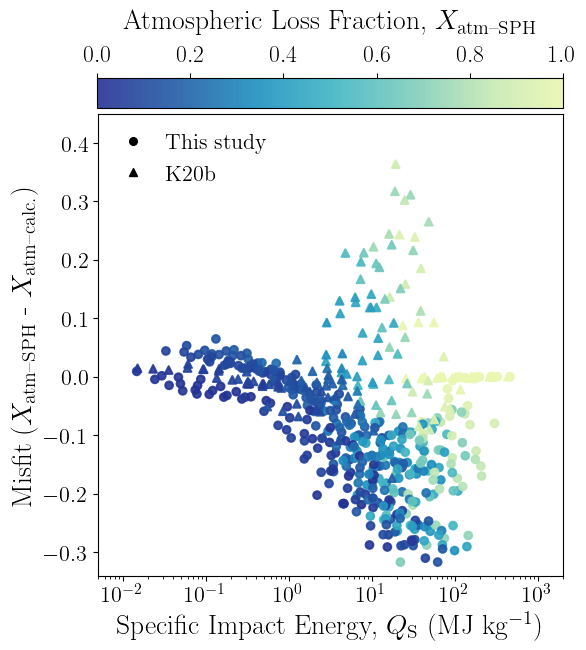

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (6, 6))
gs = gridspec.GridSpec(1, 1, figure = fig, hspace = 0.02, wspace = 0.015)

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

folder_path = '' # Add path to 'impacts' parquet file
data = pd.read_parquet(folder_path + 'impacts')

# Ignore simulations which didn't run to completion:
data = data[~(
    (data['M_t'] == 5.245433) & 
    ((data['gamma'] == 0.2) & (data['b'] == 0.0) & (data['v_c_v_esc'] == 3.0)) |
    ((data['gamma'] == 0.3) & (data['b'] == 0.0) & (data['v_c_v_esc'] == 2.0)) |
    ((data['gamma'] == 0.3) & (data['b'] == 0.0) & (data['v_c_v_esc'] == 3.0)) |
    ((data['gamma'] == 0.4) & (data['b'] == 0.0) & (data['v_c_v_esc'] == 1.5)) |
    ((data['gamma'] == 0.4) & (data['b'] == 0.0) & (data['v_c_v_esc'] == 2.0)) |
    ((data['gamma'] == 0.4) & (data['b'] == 0.3) & (data['v_c_v_esc'] == 3.0)) |
    ((data['gamma'] == 0.5) & (data['b'] == 0.0) & (data['v_c_v_esc'] == 1.0)) |
    ((data['gamma'] == 0.5) & (data['b'] == 0.0) & (data['v_c_v_esc'] == 1.5)) |
    ((data['gamma'] == 0.5) & (data['b'] == 0.3) & (data['v_c_v_esc'] == 2.0))
)]

folder_path = '' # Add path to 'Fig20_data_K20b' parquet file
data_K20b = pd.read_parquet(folder_path + 'Fig20_data_K20b')

custom_legend = [
    ax.plot([], [], linestyle = '', color = 'black', lw = 1.5, marker = 'o', markersize = 5.5, label = 'This study')[0],
    ax.plot([], [], linestyle = '', color = 'black', lw = 1.5, marker = '^', markersize = 5.5, label = 'K20b')[0]
]

ax = fig.add_subplot(gs[0])

R24 = ax.scatter(Q_S_calc(data['R_t'] * R_earth,
                            data['R_i'] * R_earth,
                            data['M_t_tot'] * M_earth,
                            data['M_i'] * M_earth,
                            data['b'],
                            data['v_c'] * 1e3) / 1e6,
                            data['X_atm'] - X_atm_calc_K20b(data['M_t_tot'] * M_earth, 
                                                                        data['M_i'] * M_earth,
                                                                        data['b'],
                                                                        data['v_c_v_esc']),
                       c = data['X_atm'],
                       cmap = mcolors.ListedColormap(plt.get_cmap('YlGnBu').reversed()(np.linspace(0.12, 0.86, 256))),  
                       marker = 'o',  
                       s = 30,
                       linewidths = 1.5,
                       vmin = 0,
                       vmax = 1,
                       alpha = 0.9
                       )

K20b = ax.scatter(Q_S_calc(data_K20b['M_t']**0.25 * R_earth,
                                data_K20b['M_i']**0.25 * R_earth,
                                data_K20b['M_t'] * M_earth,
                                data_K20b['M_i'] * M_earth,
                                data_K20b['b'],
                                data_K20b['v_c'] * (np.sqrt(2 * G * ((data_K20b['M_t']*M_earth + data_K20b['M_i']*M_earth) / 
                                                                     (data_K20b['M_t']**0.25*R_earth + data_K20b['M_i']**0.25*R_earth))))) / 1e6,
                       data_K20b['X_atm'] - X_atm_calc_K20b(data_K20b['M_t'] * M_earth, 
                                                            data_K20b['M_i'] * M_earth,
                                                            data_K20b['b'],
                                                            data_K20b['v_c']),
                       c = data_K20b['X_atm'],
                       cmap = mcolors.ListedColormap(plt.get_cmap('YlGnBu').reversed()(np.linspace(0.12, 0.86, 256))),  
                       marker = '^',  
                       s = 30,
                       linewidths = 1.5,
                       vmin = 0,
                       vmax = 1,
                       alpha = 0.9
                       )

ax.set_ylabel(r'Misfit ($X_{{\rm atm–SPH}}$ - $X_{{\rm atm–calc.}}$)', fontsize = 20)
ax.get_yaxis().set_label_coords(-0.13, 0.5)
ax.set_xlabel(r'Specific Impact Energy, $Q_{\rm S}$ (MJ kg$^{-1}$)', fontsize = 20)

ax.tick_params(axis = 'both', colors = 'k', labelsize = 16)
ax.set_xlim(0.5e-2, 2e3)
ax.set_ylim(-0.34, 0.45)
ax.set_xscale('log')

divider = make_axes_locatable(ax)
cax = plt.axes([0.1232, 0.89, 0.7765, 0.05])
cbar = plt.colorbar(R24, cax = cax, orientation = 'horizontal')
cbar.set_label(r'Atmospheric Loss Fraction, $X_{{\rm atm–SPH}}$', fontsize = 20, labelpad = 12)
cbar.ax.xaxis.set_ticks_position('top')  # Move ticks to the top
cbar.ax.xaxis.set_label_position('top')  # Move label to the top
cbar.ax.tick_params(axis='x', direction='out', pad=5, labelsize=17)
cbar.update_ticks()

ax.legend(custom_legend, ['This study', 'K20b'], fontsize = 16, facecolor = 'white', framealpha = 0.0, handlelength = 1.3, loc = 'best', ncol = 1)
plt.show()

---

## Figure 21: $N$-body applications

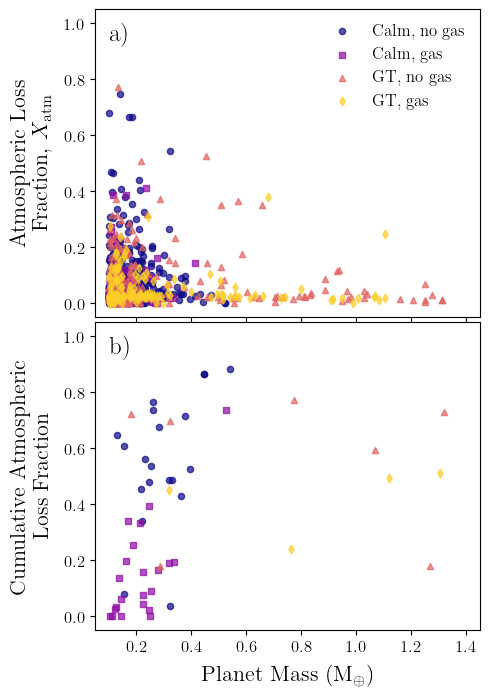

In [ ]:
data_path = '' # Add path to 'Fig21_Nbody_data.npz' file
data = np.load(data_path + 'Fig21_Nbody_data.npz')

# Extract variables
mt_calm = data["mt_calm"]
mt_calm_gas = data["mt_calm_gas"]
mt_GT = data["mt_GT"]
mt_GT_gas = data["mt_GT_gas"]

Xatmo_calm = data["Xatmo_calm"]
Xatmo_calm_gas = data["Xatmo_calm_gas"]
Xatmo_GT = data["Xatmo_GT"]
Xatmo_GT_gas = data["Xatmo_GT_gas"]

pl_mass_calm = data["pl_mass_calm"]
pl_mass_calm_gas = data["pl_mass_calm_gas"]
pl_mass_GT = data["pl_mass_GT"]
pl_mass_GT_gas = data["pl_mass_GT_gas"]

cum_ero_calm = data["cum_ero_calm"]
cum_ero_calm_gas = data["cum_ero_calm_gas"]
cum_ero_GT = data["cum_ero_GT"]
cum_ero_GT_gas = data["cum_ero_GT_gas"]

col = cmaps.plasma(np.linspace(0.0, 0.9, 4))

plt.figure(figsize=(5,7))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.subplot(211)
plt.scatter(mt_calm, Xatmo_calm, label='Calm, no gas', marker='o', s=20, color=col[0], alpha=0.7)
plt.scatter(mt_calm_gas, Xatmo_calm_gas, label='Calm, gas', marker='s', s=20, color=col[1], alpha=0.7)
plt.scatter(mt_GT, Xatmo_GT, label='GT, no gas', marker='^', s=20, color=col[2], alpha=0.7)
plt.scatter(mt_GT_gas, Xatmo_GT_gas, label='GT, gas', marker='d', s=20, color=col[3], alpha=0.7)
plt.ylabel(r'Atmospheric Loss' '\n' r'Fraction, $X_{\rm atm}$', fontsize=16)
plt.ylim(-0.05, 1.05)
plt.xlim(0.05, 1.45)
plt.legend(framealpha=0.0, fontsize=12)
plt.tick_params(axis='y', colors='k', labelsize=12)
plt.gca().set_xticklabels([])
plt.gca().get_yaxis().set_label_coords(-0.11, 0.5)
plt.gca().text(0.1, 0.94, 'a)', fontsize=18)

plt.subplot(212)
plt.scatter(pl_mass_calm, cum_ero_calm, marker='o', s=20, color=col[0], alpha=0.7)
plt.scatter(pl_mass_calm_gas, cum_ero_calm_gas, marker='s', s=20, color=col[1], alpha=0.7)
plt.scatter(pl_mass_GT, cum_ero_GT, marker='^', s=20, color=col[2], alpha=0.7)
plt.scatter(pl_mass_GT_gas, cum_ero_GT_gas, marker='d', s=20, color=col[3], alpha=0.7)
plt.xlabel(r'Planet Mass (M$_\oplus$)', fontsize=16)
plt.ylabel(r'Cumulative Atmospheric' '\n' r'Loss Fraction', fontsize=16)
plt.ylim(-0.05, 1.05)
plt.xlim(0.05, 1.45)
plt.tick_params(axis='both', colors='k', labelsize=12)
plt.gca().get_xaxis().set_label_coords(0.5, -0.11)
plt.gca().get_yaxis().set_label_coords(-0.11, 0.5)
plt.gca().text(0.1, 0.94, 'b)', fontsize=18)

plt.tight_layout()
plt.subplots_adjust(hspace=.015)
plt.show()

---

## Figure 22: near/far field determination

In [ ]:
#function to calculate the tangent at an arbitary point
def calc_tangent(phi,t,Rp,offset,b,zsign,flag_theta0=0):
    # print('passed to tangent',phi,t,Rp,offset,b,zsign,flag_theta0)
    # zsign=1
    if flag_theta0==0:
        # print('doing it right')
        (xg0,yg0,zg0)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), zsign*np.sqrt(2*offset*(b+Rp*np.cos(phi))))
    else:
        # print('like, etf')
        (xg0,yg0,zg0)=(-b-offset,np.sign(flag_theta0)*np.sqrt(Rp**2-b**2),0.0)
        # print('xg0',flag_theta0,xg0,yg0,zg0)
        # ax.plot(xg0, yg0, zg0, 'm+', ms=5)
    # print(xg0,yg0,zg0)
    # print(np.sin(phi))
    
    # if (np.abs(2*np.sqrt((b+Rp*np.cos(phi))))<1E-14)|(flag_theta0!=0):
    if (flag_theta0!=0):
        xg=0.0*t +xg0
        yg=0.0*t +yg0
        zg=-1.*zsign*Rp*np.sin(phi)*np.sqrt(2*offset)*t+zg0
        # print('we were too close')
        # print(np.sin(phi),np.cos(phi),b+Rp*np.cos(phi),np.sqrt((b+Rp*np.cos(phi))))
    else:
        xg=-Rp*np.sin(phi)*(2*np.sqrt((b+Rp*np.cos(phi))))*t +xg0
        yg=Rp*np.cos(phi)*(2*np.sqrt((b+Rp*np.cos(phi))))*t +yg0
        zg=-1.*zsign*Rp*np.sin(phi)*np.sqrt(2*offset)*t+zg0
        # xg=-Rp*np.sin(phi)*t +xg0xx
        # yg=Rp*np.cos(phi)*t +yg0
        # zg=-1.*zsign*Rp*np.sin(phi)*np.sqrt(2*offset)/(2*np.sqrt((b+Rp*np.cos(phi))))*t +zg0
    
    # ax.plot(xg, yg, zg, 'm', lw=1)
    # print(xg,yg,zg)
    # print('tangent',phi,xg,yg,zg)

    #find the normal to both the positipon and perpendicular vector
    xpl=yg0*zg-zg0*yg + xg0
    ypl=zg0*xg-xg0*zg +yg0
    zpl=xg0*yg-yg0*xg +zg0

    return xpl, ypl, zpl

/var/folders/kj/59sk5mrx6214shnd0_nt_2z80000gq/T/ipykernel_33429/167709811.py:202: RuntimeWarning: invalid value encountered in arccos
  phi_limit=np.arccos(Rp/offset)
/var/folders/kj/59sk5mrx6214shnd0_nt_2z80000gq/T/ipykernel_33429/645169312.py:10: RuntimeWarning: invalid value encountered in sqrt
  (xg0,yg0,zg0)=(-b-offset,np.sign(flag_theta0)*np.sqrt(Rp**2-b**2),0.0)
/var/folders/kj/59sk5mrx6214shnd0_nt_2z80000gq/T/ipykernel_33429/167709811.py:296: RuntimeWarning: invalid value encountered in arccos
  phi_limit=np.arccos(Rp/offset)
/var/folders/kj/59sk5mrx6214shnd0_nt_2z80000gq/T/ipykernel_33429/645169312.py:10: RuntimeWarning: invalid value encountered in sqrt
  (xg0,yg0,zg0)=(-b-offset,np.sign(flag_theta0)*np.sqrt(Rp**2-b**2),0.0)
/var/folders/kj/59sk5mrx6214shnd0_nt_2z80000gq/T/ipykernel_33429/167709811.py:421: RuntimeWarning: divide by zero encountered in divide
  tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
/var/folde

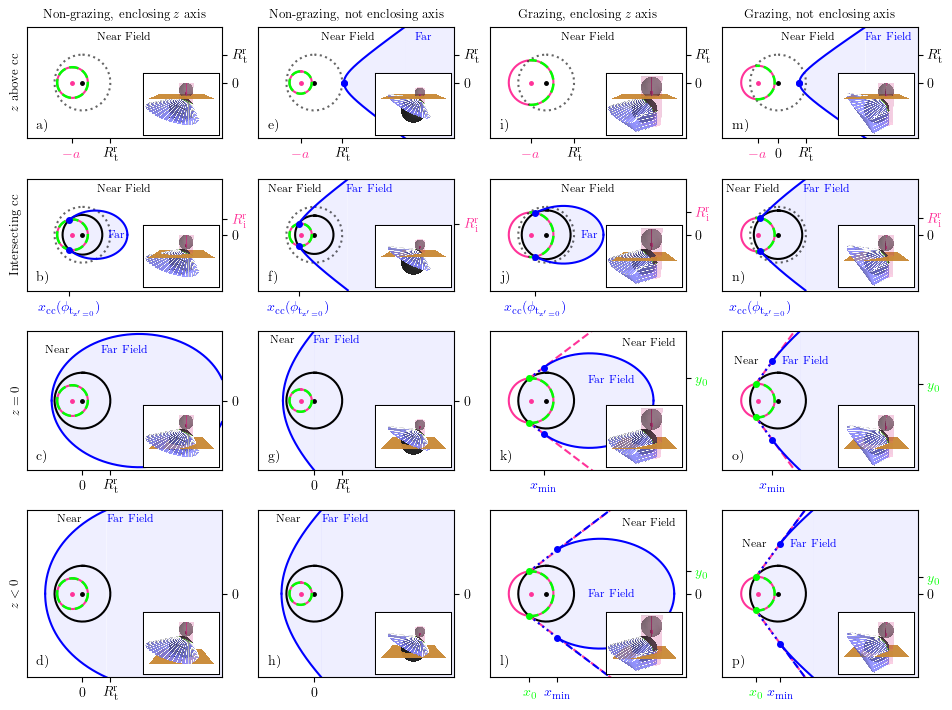

In [6]:
fig = plt.figure(figsize=(9.6,7.3))
gs = gridspec.GridSpec(4,4,
#                        wspace=0.05,
                       width_ratios=[1,1,1,1],
                       height_ratios=[1,1,1.2,1.4]
)

ax = [[None]*4 for j in range(4)]
for i in np.arange(0,4):
    for j in np.arange(4):
        if (i==0)&(j==0):
            ax[i][j]=plt.subplot(gs[i*4+j])
        else:
            ax[i][j]=plt.subplot(gs[i*4+j])
            

xrange=[-2,5]
yrange=[-2,2]
yrange2=[-2.5,2.5]
yrange3=[-3,3]

######################################################################################
######################################################################################
######################################################################################
######################################################################################
## Non-grazing but enclosing pole

bimp=0.23
Rt=1.0
Rp=0.55#0.9018332728407688
offset=(Rt+Rp)*bimp
Rp=Rp/Rt
offset=offset/Rt
Rt=1.



b=(Rt**2-Rp**2-offset**2)/(2*offset)

#set the range of phi depending on the regime we are in    
if Rt>=(Rp+offset):
    theta0=np.pi
    flag_regime=0
elif Rt<(Rp+offset):
    theta0=np.arccos(-b/Rp)
    flag_regime=1


######################################################################################
### z above planet
zint=1.1

# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100

ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[0][0].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[0][0].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),
            'k', alpha=0.6, lw=1.5, ls=':')

ax[0][0].plot([0],[0],'k.',ms=5)
ax[0][0].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)

#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[0][0].plot(x, y, '--', color='lime', lw=1.8)

ax[0][0].set_xlim(xrange)
ax[0][0].set_ylim(yrange)
ax[0][0].set_aspect('equal')

ax[0][0].set_xticks([-offset,Rt],["$-a$",r"$R_{\rm t}^{\rm r}$"],minor=False)
ax[0][0].set_yticks([0,Rt],["$0$",r"$R_{\rm t}^{\rm r}$"],minor=False)

xticks = ax[0][0].get_xticklabels()
xticks[0].set_color((col[0]/255, col[1]/255, col[2]/255))
# xticks[1].set_alpha(0.4)

ax[0][0].text(0.5,0.95,\
        r"Near Field", horizontalalignment='center',verticalalignment='top', fontsize=8,transform=ax[0][0].transAxes, color='k')


######################################################################################
### z intersecting cc
zint=(np.sqrt(2*offset*(b+Rp))+np.sqrt(2*offset*(b-Rp)))/2

# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100

ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[1][0].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[1][0].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),
            'k', alpha=0.6, lw=1.5, ls=':')


ax[1][0].plot(np.sqrt(Rt**2-zint**2)*np.sin(theta)*np.cos(phi), np.sqrt(Rt**2-zint**2)*np.cos(theta)*np.cos(phi),
            'k', alpha=1., lw=1.5)

# ax[1][0].plot([-offset,-offset],[-2,2],'k--')
ax[1][0].plot([0],[0],'k.',ms=5)
ax[1][0].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)

#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[1][0].plot(x, y, '--', color='lime', lw=1.8)

Nplot=1000
phi=np.concatenate((np.linspace(0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)

ind=np.arange(np.size(xint_plot))
ind=np.where((tint<=0)&(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange[0])&(yint_plot<=yrange[1]))[0]

Nplot=100
ax[1][0].fill_between(xint_plot[ind], yint_plot[ind],-yint_plot[ind],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
Rtz=np.sqrt(Rt**2-zint**2)
xtemp=np.linspace(-Rtz,xint_plot[ind[-1]],Nplot)
ytemp=np.sqrt(Rtz**2-(xtemp)**2)
ax[1][0].fill_between(xtemp, ytemp,-ytemp,color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[1][0].fill_between([xint_plot[ind[0]],xrange[1]], yint_plot[ind[0]]*np.ones(2),\
                -yint_plot[ind[0]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)

ax[1][0].plot(xint_plot[ind],yint_plot[ind],'b-', lw=1.5)
ax[1][0].plot(xint_plot[ind[-1]],yint_plot[ind[-1]],'b.',ms=8)
ax[1][0].plot(xint_plot[ind],-yint_plot[ind],'b-', lw=1.5)
ax[1][0].plot(xint_plot[ind[-1]],-yint_plot[ind[-1]],'b.',ms=8)

ax[1][0].set_xlim(xrange)
ax[1][0].set_ylim(yrange)
ax[1][0].set_aspect('equal')

ax[1][0].set_xticks([xint_plot[ind[-1]]],[r"$x_{\rm cc}(\phi_{\rm t_{z'=0}})$"],minor=False)
ax[1][0].set_yticks([0,Rp],["$0$",r"$R_{\rm i}^{\rm r}$"],minor=False)

xticks = ax[1][0].get_xticklabels()
xticks[0].set_color('b')

yticks = ax[1][0].get_yticklabels()
yticks[0].set_color((col[0]/255, col[1]/255, col[2]/255))


ax[1][0].text((xint_plot[ind[0]]-0.09-xrange[0])/(xrange[1]-xrange[0]), 0.5, r"Far", horizontalalignment='right',verticalalignment='center', fontsize=8,transform=ax[1][0].transAxes, color='b')
# ax[1][0].text((xint_plot[ind[0]]+0.2-xrange[0])/(xrange[1]-xrange[0]), 0.5, r"Near field", horizontalalignment='left',verticalalignment='center', fontsize=8,transform=ax[1][0].transAxes, color='k')
ax[1][0].text(0.5,0.95,\
        r"Near Field", horizontalalignment='center',verticalalignment='top', fontsize=8,transform=ax[1][0].transAxes, color='k')


######################################################################################
### z=0

zint=0.0

# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100

ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[2][0].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[2][0].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),
            'k', alpha=1.0, lw=1.5, ls='-')

ax[2][0].plot([0],[0],'k.',ms=5)
ax[2][0].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)


#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[2][0].plot(x, y, '--', color='lime', lw=1.8)

Nplot=10000
phi_limit=np.arccos(Rp/offset)
phi=np.linspace(phi_limit*(1+1E-13), (1-1E-13)*theta0, Nplot)
phi=np.concatenate((np.linspace(0, 0.9*theta0, Nplot),\
                    np.linspace(0.9*theta0, theta0, Nplot)))

tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)


# ind=np.arange(np.size(xint_plot))
ind=np.where((np.isnan(xint_plot)==False)&(np.isinf(xint_plot)==False)&(tint<=0)\
             &(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange2[0])&(yint_plot<=yrange2[1]))[0]
ind_min=np.argmin(xint_plot[ind])
ind_ymax=np.argmax(yint_plot[ind])


Nplot=100
t0=np.linspace(0,-5,Nplot)
(x0,y0,z0)=calc_tangent(theta0,t0,Rp,offset,b,1,flag_theta0=1)

Nplot=100
x_join=np.linspace(x0[0],xint_plot[ind[ind_min]],Nplot)
y_join=np.linspace(y0[0],yint_plot[ind[ind_min]],Nplot)


Nplot=100
ax[2][0].fill_between(xint_plot[ind[0:ind_min+1]], yint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
xtemp=np.linspace(-Rt,x0[0],Nplot)
ytemp=np.sqrt(Rt**2-(xtemp)**2)
ax[2][0].fill_between(xtemp, ytemp,-ytemp,color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[2][0].fill_between([xint_plot[ind[0]],xrange[1]], yint_plot[ind[0]]*np.ones(2),\
                -yint_plot[ind[0]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)

ax[2][0].fill_between(x_join,y_join,-y_join,color=(0.5,0.5,1.0),alpha=0.12,ec=None)

ax[2][0].plot(x_join,y_join,'b:')
ax[2][0].plot(x_join,-y_join,'b:')

ax[2][0].plot(xint_plot[ind[0:ind_min+1]],yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[2][0].plot(xint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)

col=[255.,51.,153.]
ax[2][0].plot(x0,y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0)
ax[2][0].plot(x0,-y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0)

ax[2][0].plot([x0[0]],[y0[0]], '.', ms=5, color='lime')
ax[2][0].plot([x0[0]],[-y0[0]], '.', ms=5, color='lime')

ax[2][0].set_xlim(xrange)
ax[2][0].set_ylim(yrange2)
ax[2][0].set_aspect('equal')

ax[2][0].set_xticks([0,Rt],["$0$",r"$R_{\rm t}^{\rm r}$"],minor=False)
ax[2][0].set_yticks([0],["0"],minor=False)


ax[2][0].text(0.38,0.9,\
        r"Far Field", horizontalalignment='left',verticalalignment='top', fontsize=8,transform=ax[2][0].transAxes, color='b')
ax[2][0].text(0.22,0.9,\
        r"Near", horizontalalignment='right',verticalalignment='top', fontsize=8,transform=ax[2][0].transAxes, color='k')


######################################################################################
### z<0

zint=-0.5

# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100

ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[3][0].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[3][0].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),
            'k', alpha=1.0, lw=1.5, ls='-')

ax[3][0].plot([0],[0],'k.',ms=5)
ax[3][0].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)

#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[3][0].plot(x, y, '--', color='lime', lw=1.8)

Nplot=10000
phi_limit=np.arccos(Rp/offset)
phi=np.linspace(phi_limit*(1+1E-13), (1-1E-13)*theta0, Nplot)
phi=np.concatenate((np.linspace(0, 0.9*theta0, Nplot),\
                    np.linspace(0.9*theta0, theta0, Nplot)))

tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)

ind=np.where((np.isnan(xint_plot)==False)&(np.isinf(xint_plot)==False)&(tint<=0)\
             &(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange3[0])&(yint_plot<=yrange3[1]))[0]
ind_min=np.argmin(xint_plot[ind])
ind_ymax=np.argmax(yint_plot[ind])


Nplot=100
t0=np.linspace(0,-5,Nplot)
(x0,y0,z0)=calc_tangent(theta0,t0,Rp,offset,b,1,flag_theta0=1)

Nplot=100
x_join=np.linspace(x0[0],xint_plot[ind[ind_min]],Nplot)
y_join=np.linspace(y0[0],yint_plot[ind[ind_min]],Nplot)


Nplot=100
ax[3][0].fill_between(xint_plot[ind[0:ind_min+1]], yint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
xtemp=np.linspace(-Rt,x0[0],Nplot)
ytemp=np.sqrt(Rt**2-(xtemp)**2)
ax[3][0].fill_between(xtemp, ytemp,-ytemp,color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[3][0].fill_between([xint_plot[ind[0]],xrange[1]], yint_plot[ind[0]]*np.ones(2),\
                -yint_plot[ind[0]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)

ax[3][0].fill_between(x_join,y_join,-y_join,color=(0.5,0.5,1.0),alpha=0.12,ec=None)

ax[3][0].plot(x_join,y_join,'b:')
ax[3][0].plot(x_join,-y_join,'b:')

ax[3][0].plot(xint_plot[ind[0:ind_min+1]],yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[3][0].plot(xint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],'b-',lw=1.5)

col=[255.,51.,153.]
ax[3][0].plot(x0,y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0)
ax[3][0].plot(x0,-y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0)

ax[3][0].plot([x0[0]],[y0[0]], '.', ms=5, color='lime')
ax[3][0].plot([x0[0]],[-y0[0]], '.', ms=5, color='lime')

ax[3][0].set_xlim(xrange)
ax[3][0].set_ylim(yrange3)
ax[3][0].set_aspect('equal')

ax[3][0].set_xticks([0,Rt],["$0$",r"$R_{\rm t}^{\rm r}$"],minor=False)

ax[3][0].set_yticks([0],["0"],minor=False)


ax[3][0].text((xint_plot[ind[ind_ymax]]-0.-xrange[0])/(xrange[1]-xrange[0]),\
        (yint_plot[ind[ind_ymax]]-0.15-yrange3[0])/(yrange3[1]-yrange3[0]),\
        r"Far Field", horizontalalignment='left',verticalalignment='top', fontsize=8,transform=ax[3][0].transAxes, color='b')
ax[3][0].text((xint_plot[ind[ind_ymax]]-0.91-xrange[0])/(xrange[1]-xrange[0]),\
        (yint_plot[ind[ind_ymax]]-0.15-yrange3[0])/(yrange3[1]-yrange3[0]),\
        r"Near", horizontalalignment='right',verticalalignment='top', fontsize=8,transform=ax[3][0].transAxes, color='k')


######################################################################################
######################################################################################
######################################################################################
######################################################################################
## Non-grazing not enclosing pole

bimp=0.35
Rt=1.0
Rp=0.4#0.9018332728407688
offset=(Rt+Rp)*bimp
Rp=Rp/Rt
offset=offset/Rt
Rt=1.



b=(Rt**2-Rp**2-offset**2)/(2*offset)

#set the range of phi depending on the regime we are in    
if Rt>=(Rp+offset):
    theta0=np.pi
    flag_regime=0
elif Rt<(Rp+offset):
    theta0=np.arccos(-b/Rp)
    flag_regime=1

######################################################################################
### z above planet

zint=1.1

# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100

ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[0][1].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[0][1].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),
            'k', alpha=0.6, lw=1.5, ls=':')


ax[0][1].plot([0],[0],'k.',ms=5)
ax[0][1].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)

#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[0][1].plot(x, y, '--', color='lime', lw=1.8)


Nplot=1000
phi_limit=np.arccos(Rp/offset)
phi=np.concatenate((np.linspace(0, 0.9*phi_limit, Nplot),np.linspace(0.9*phi_limit, phi_limit, Nplot)))
tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)

ind=np.arange(np.size(xint_plot))
ind=np.where((tint<=0)&(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange[0])&(yint_plot<=yrange[1]))[0]


ax[0][1].fill_between(xint_plot[ind], yint_plot[ind],-yint_plot[ind],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[0][1].fill_between([xint_plot[ind[-1]],xrange[1]], yint_plot[ind[-1]]*np.ones(2),\
                -yint_plot[ind[-1]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)


ax[0][1].plot(xint_plot[ind],yint_plot[ind],'b-', lw=1.5)
ax[0][1].plot(xint_plot[ind[0]],yint_plot[ind[0]],'b.',ms=8)
ax[0][1].plot(xint_plot[ind],-yint_plot[ind],'b-', lw=1.5)
ax[0][1].plot(xint_plot[ind[0]],-yint_plot[ind[0]],'b.',ms=8)


ax[0][1].set_xlim(xrange)
ax[0][1].set_ylim(yrange)
ax[0][1].set_aspect('equal')


ax[0][1].set_xticks([-offset,Rt],["$-a$",r"$R_{\rm t}^{\rm r}$"],minor=False)

ax[0][1].set_yticks([0,Rt],["$0$",r"$R_{\rm t}^{\rm r}$"],minor=False)

xticks = ax[0][1].get_xticklabels()
xticks[0].set_color((col[0]/255, col[1]/255, col[2]/255))


ax[0][1].text(0.8,0.95,\
        r"Far", horizontalalignment='left',verticalalignment='top', fontsize=8,transform=ax[0][1].transAxes, color='b')
ax[0][1].text(0.6,0.95,\
        r"Near Field", horizontalalignment='right',verticalalignment='top', fontsize=8,transform=ax[0][1].transAxes, color='k')

######################################################################################
### z intersecting cc

zint=(np.sqrt(2*offset*(b-Rp))+np.sqrt(2*offset*(b+Rp)))/2

# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100


ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[1][1].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[1][1].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),
            'k', alpha=0.6, lw=1.5, ls=':')


ax[1][1].plot(np.sqrt(Rt**2-zint**2)*np.sin(theta)*np.cos(phi), np.sqrt(Rt**2-zint**2)*np.cos(theta)*np.cos(phi),
            'k', alpha=1., lw=1.5)

ax[1][1].plot([0],[0],'k.',ms=5)
ax[1][1].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)

#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[1][1].plot(x, y, '--', color='lime', lw=1.8)

Nplot=1000
phi=np.concatenate((np.linspace(0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)

ind=np.arange(np.size(xint_plot))
ind=np.where((tint<=0)&(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange[0])&(yint_plot<=yrange[1]))[0]

Nplot=100
ax[1][1].fill_between(xint_plot[ind], yint_plot[ind],-yint_plot[ind],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
Rtz=np.sqrt(Rt**2-zint**2)
xtemp=np.linspace(-Rtz,xint_plot[ind[-1]],Nplot)
ytemp=np.sqrt(Rtz**2-(xtemp)**2)
ax[1][1].fill_between(xtemp, ytemp,-ytemp,color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[1][1].fill_between([xint_plot[ind[0]],xrange[1]], yint_plot[ind[0]]*np.ones(2),\
                -yint_plot[ind[0]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)

ax[1][1].plot(xint_plot[ind],yint_plot[ind],'b-', lw=1.5)
ax[1][1].plot(xint_plot[ind[-1]],yint_plot[ind[-1]],'b.',ms=8)
ax[1][1].plot(xint_plot[ind],-yint_plot[ind],'b-', lw=1.5)
ax[1][1].plot(xint_plot[ind[-1]],-yint_plot[ind[-1]],'b.',ms=8)

ax[1][1].set_xlim(xrange)
ax[1][1].set_ylim(yrange)
ax[1][1].set_aspect('equal')

ax[1][1].set_xticks([xint_plot[ind[-1]]],[r"$x_{\rm cc}(\phi_{\rm t_{z'=0}})$"],minor=False)

ax[1][1].set_yticks([Rp],[r"$R_{\rm i}^{\rm r}$"],minor=False)

xticks = ax[1][1].get_xticklabels()
xticks[0].set_color('b')

yticks = ax[1][1].get_yticklabels()
yticks[0].set_color((col[0]/255, col[1]/255, col[2]/255))


ax[1][1].text((xint_plot[ind[0]]-0.05-xrange[0])/(xrange[1]-xrange[0]), 0.95, r"Far Field", horizontalalignment='left',verticalalignment='top', fontsize=8,transform=ax[1][1].transAxes, color='b')
ax[1][1].text((xint_plot[ind[0]]-0.92-xrange[0])/(xrange[1]-xrange[0]), 0.95, r"Near Field", horizontalalignment='right',verticalalignment='top', fontsize=8,transform=ax[1][1].transAxes, color='k')


######################################################################################
### z=0

zint=0.0

# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100


ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[2][1].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[2][1].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),
            'k', alpha=1.0, lw=1.5, ls='-')


ax[2][1].plot([0],[0],'k.',ms=5)
ax[2][1].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)


#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[2][1].plot(x, y, '--', color='lime', lw=1.8)


Nplot=10000
phi_limit=np.arccos(Rp/offset)

phi=np.linspace(phi_limit*(1+1E-13), (1-1E-13)*theta0, Nplot)


tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)


# ind=np.arange(np.size(xint_plot))
ind=np.where((np.isnan(xint_plot)==False)&(np.isinf(xint_plot)==False)&(tint<=0)\
             &(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange2[0])&(yint_plot<=yrange2[1]))[0]
ind_min=np.argmin(xint_plot[ind])
ind_ymax=np.argmax(yint_plot[ind])


Nplot=100
t0=np.linspace(0,-5,Nplot)
(x0,y0,z0)=calc_tangent(theta0,t0,Rp,offset,b,1,flag_theta0=1)

Nplot=100
x_join=np.linspace(x0[0],xint_plot[ind[ind_min]],Nplot)
y_join=np.linspace(y0[0],yint_plot[ind[ind_min]],Nplot)


Nplot=100
ax[2][1].fill_between(xint_plot[ind[0:ind_min+1]], yint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
xtemp=np.linspace(-Rt,x0[0],Nplot)
ytemp=np.sqrt(Rt**2-(xtemp)**2)
ax[2][1].fill_between(xtemp, ytemp,-ytemp,color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[2][1].fill_between([xint_plot[ind[0]],xrange[1]], yint_plot[ind[0]]*np.ones(2),\
                -yint_plot[ind[0]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)

ax[2][1].fill_between(x_join,y_join,-y_join,color=(0.5,0.5,1.0),alpha=0.12,ec=None)



ax[2][1].plot(x_join,y_join,'b:')
ax[2][1].plot(x_join,-y_join,'b:')

ax[2][1].plot(xint_plot[ind[0:ind_min+1]],yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[2][1].plot(xint_plot[ind[ind_min+1:]],yint_plot[ind[ind_min+1:]],'b--', lw=1.5)

ax[2][1].plot(xint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[2][1].plot(xint_plot[ind[ind_min+1:]],-yint_plot[ind[ind_min+1:]],'b--', lw=1.5)


col=[255.,51.,153.]
ax[2][1].plot(x0,y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0)
ax[2][1].plot(x0,-y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0)

ax[2][1].plot([x0[0]],[y0[0]], '.', ms=5, color='lime')
ax[2][1].plot([x0[0]],[-y0[0]], '.', ms=5, color='lime')


ax[2][1].set_xlim(xrange)
ax[2][1].set_ylim(yrange2)
ax[2][1].set_aspect('equal')


ax[2][1].set_xticks([0,Rt],["$0$",r"$R_{\rm t}^{\rm r}$"],minor=False)

ax[2][1].set_yticks([0],["$0$"],minor=False)


ax[2][1].text((xint_plot[ind[ind_ymax]]-0.04-xrange[0])/(xrange[1]-xrange[0]),\
        (yint_plot[ind[ind_ymax]]-0.15-yrange2[0])/(yrange2[1]-yrange2[0]),\
        r"Far Field", horizontalalignment='left',verticalalignment='top', fontsize=8,transform=ax[2][1].transAxes, color='b')
ax[2][1].text((xint_plot[ind[ind_ymax]]-0.72-xrange[0])/(xrange[1]-xrange[0]),\
        (yint_plot[ind[ind_ymax]]-0.15-yrange2[0])/(yrange2[1]-yrange2[0]),\
        r"Near ", horizontalalignment='right',verticalalignment='top', fontsize=8,transform=ax[2][1].transAxes, color='k')


######################################################################################
### z<0

zint=-0.1

# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100


ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[3][1].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[3][1].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),
            'k', alpha=1.0, lw=1.5, ls='-')

ax[3][1].plot([0],[0],'k.',ms=5)
ax[3][1].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)


#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[3][1].plot(x, y, '--', color='lime', lw=1.8)


Nplot=10000
phi_limit=np.arccos(Rp/offset)

phi=np.linspace(phi_limit*(1+1E-13), (1-1E-13)*theta0, Nplot)


tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)


ind=np.where((np.isnan(xint_plot)==False)&(np.isinf(xint_plot)==False)&(tint<=0)\
             &(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange3[0])&(yint_plot<=yrange3[1]))[0]
ind_min=np.argmin(xint_plot[ind])
ind_ymax=np.argmax(yint_plot[ind])


Nplot=100
t0=np.linspace(0,-5,Nplot)
(x0,y0,z0)=calc_tangent(theta0,t0,Rp,offset,b,1,flag_theta0=1)


Nplot=100
x_join=np.linspace(x0[0],xint_plot[ind[ind_min]],Nplot)
y_join=np.linspace(y0[0],yint_plot[ind[ind_min]],Nplot)


Nplot=100
ax[3][1].fill_between(xint_plot[ind[0:ind_min+1]], yint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
xtemp=np.linspace(-Rt,x0[0],Nplot)
ytemp=np.sqrt(Rt**2-(xtemp)**2)
ax[3][1].fill_between(xtemp, ytemp,-ytemp,color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[3][1].fill_between([xint_plot[ind[0]],xrange[1]], yint_plot[ind[0]]*np.ones(2),\
                -yint_plot[ind[0]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)

ax[3][1].fill_between(x_join,y_join,-y_join,color=(0.5,0.5,1.0),alpha=0.12,ec=None)



ax[3][1].plot(x_join,y_join,'b:')
ax[3][1].plot(x_join,-y_join,'b:')

ax[3][1].plot(xint_plot[ind[0:ind_min+1]],yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[3][1].plot(xint_plot[ind[ind_min+1:]],yint_plot[ind[ind_min+1:]],'b--', lw=1.5)
ax[3][1].plot(xint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[3][1].plot(xint_plot[ind[ind_min+1:]],-yint_plot[ind[ind_min+1:]],'b--', lw=1.5)


col=[255.,51.,153.]
ax[3][1].plot(x0,y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0)
ax[3][1].plot(x0,-y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0)

ax[3][1].plot([x0[0]],[y0[0]], '.', ms=5, color='lime')
ax[3][1].plot([x0[0]],[-y0[0]], '.', ms=5, color='lime')


ax[3][1].set_xlim(xrange)
ax[3][1].set_ylim(yrange3)
ax[3][1].set_aspect('equal')


ax[3][1].set_xticks([0],["$0$"],minor=False)


ax[3][1].set_yticks([0],["$0$"],minor=False)


ax[3][1].text((xint_plot[ind[ind_ymax]]+0.02-xrange[0])/(xrange[1]-xrange[0]),\
        (yint_plot[ind[ind_ymax]]-0.15-yrange3[0])/(yrange3[1]-yrange3[0]),\
        r"Far Field", horizontalalignment='left',verticalalignment='top', fontsize=8,transform=ax[3][1].transAxes, color='b')
ax[3][1].text((xint_plot[ind[ind_ymax]]-0.76-xrange[0])/(xrange[1]-xrange[0]),\
        (yint_plot[ind[ind_ymax]]-0.15-yrange3[0])/(yrange3[1]-yrange3[0]),\
        r"Near", horizontalalignment='right',verticalalignment='top', fontsize=8,transform=ax[3][1].transAxes, color='k')

 

######################################################################################
######################################################################################
######################################################################################
######################################################################################
## Grazing but enclosing pole

bimp=0.3
Rt=1.0
Rp=0.8#0.9018332728407688
offset=(Rt+Rp)*bimp
Rp=Rp/Rt
offset=offset/Rt
Rt=1.



b=(Rt**2-Rp**2-offset**2)/(2*offset)

#set the range of phi depending on the regime we are in    
if Rt>=(Rp+offset):
    theta0=np.pi
    flag_regime=0
elif Rt<(Rp+offset):
    theta0=np.arccos(-b/Rp)
    flag_regime=1

######################################################################################
### z above planet


zint=1.1


# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100


ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[0][2].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[0][2].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),\
            'k', alpha=0.6, lw=1.5, ls=':')

ax[0][2].plot([0],[0],'k.',ms=5)
ax[0][2].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)

#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[0][2].plot(x, y, '--', color='lime', lw=1.8)

ax[0][2].set_xlim(xrange)
ax[0][2].set_ylim(yrange)
ax[0][2].set_aspect('equal')


ax[0][2].set_xticks([-offset,Rt],["$-a$",r"$R_{\rm t}^{\rm r}$"],minor=False)


ax[0][2].set_yticks([0,Rt],["$0$",r"$R_{\rm t}^{\rm r}$"],minor=False)

xticks = ax[0][2].get_xticklabels()
xticks[0].set_color((col[0]/255, col[1]/255, col[2]/255))


ax[0][2].text(0.5,0.95,\
        r"Near Field", horizontalalignment='center',verticalalignment='top', fontsize=8,transform=ax[0][2].transAxes, color='k')

######################################################################################
### z intersecting cc


zint=np.sqrt(2*offset*(b+Rp))/2


# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100


ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[1][2].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[1][2].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),\
            'k', alpha=0.6, lw=1.5, ls=':')


ax[1][2].plot(np.sqrt(Rt**2-zint**2)*np.sin(theta)*np.cos(phi), np.sqrt(Rt**2-zint**2)*np.cos(theta)*np.cos(phi),\
            'k', alpha=1., lw=1.5)


ax[1][2].plot([0],[0],'k.',ms=5)
ax[1][2].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)


#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[1][2].plot(x, y, '--', color='lime', lw=1.8)


Nplot=1000
phi=np.concatenate((np.linspace(0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)

ind=np.arange(np.size(xint_plot))
ind=np.where((tint<=0)&(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange[0])&(yint_plot<=yrange[1]))[0]

Nplot=100
ax[1][2].fill_between(xint_plot[ind], yint_plot[ind],-yint_plot[ind],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
Rtz=np.sqrt(Rt**2-zint**2)
xtemp=np.linspace(-Rtz,xint_plot[ind[-1]],Nplot)
ytemp=np.sqrt(Rtz**2-(xtemp)**2)
ax[1][2].fill_between(xtemp, ytemp,-ytemp,color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[1][2].fill_between([xint_plot[ind[0]],xrange[1]], yint_plot[ind[0]]*np.ones(2),\
                -yint_plot[ind[0]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)



ax[1][2].plot(xint_plot[ind],yint_plot[ind],'b-', lw=1.5)
ax[1][2].plot(xint_plot[ind[-1]],yint_plot[ind[-1]],'b.',ms=8)
ax[1][2].plot(xint_plot[ind],-yint_plot[ind],'b-', lw=1.5)
ax[1][2].plot(xint_plot[ind[-1]],-yint_plot[ind[-1]],'b.',ms=8)


ax[1][2].set_xlim(xrange)
ax[1][2].set_ylim(yrange)
ax[1][2].set_aspect('equal')

ax[1][2].set_xticks([xint_plot[ind[-1]]],[r"$x_{\rm cc}(\phi_{\rm t_{z'=0}})$"],minor=False)

ax[1][2].set_yticks([0,Rp],["$0$",r"$R_{\rm i}^{\rm r}$"],minor=False)

xticks = ax[1][2].get_xticklabels()
xticks[0].set_color('b')

yticks = ax[1][2].get_yticklabels()
yticks[1].set_color((col[0]/255, col[1]/255, col[2]/255))


ax[1][2].text((xint_plot[ind[0]]-0.18-xrange[0])/(xrange[1]-xrange[0]), 0.5, r"Far", horizontalalignment='right',verticalalignment='center', fontsize=8,transform=ax[1][2].transAxes, color='b')
# ax[1][2].text((xint_plot[ind[0]]+0.18-xrange[0])/(xrange[1]-xrange[0]), 0.5, r"Near field", horizontalalignment='left',verticalalignment='center', fontsize=8,transform=ax[1][2].transAxes, color='k')
ax[1][2].text(0.5,0.95,\
        r"Near Field", horizontalalignment='center',verticalalignment='top', fontsize=8,transform=ax[1][2].transAxes, color='k')

######################################################################################
### z=0

zint=0.0


# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100

ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[2][2].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[2][2].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),\
            'k', alpha=1.0, lw=1.5, ls='-')

ax[2][2].plot([0],[0],'k.',ms=5)
ax[2][2].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)


#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[2][2].plot(x, y, '--', color='lime', lw=1.8)

Nplot=10000
phi_limit=np.arccos(Rp/offset)

phi=np.linspace(phi_limit*(1+1E-13), (1-1E-13)*theta0, Nplot)
phi=np.concatenate((np.linspace(0, 0.9*theta0, Nplot),\
                    np.linspace(0.9*theta0, theta0, Nplot)))

tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)


ind=np.where((np.isnan(xint_plot)==False)&(np.isinf(xint_plot)==False)&(tint<=0)\
             &(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange2[0])&(yint_plot<=yrange2[1]))[0]
ind_min=np.argmin(xint_plot[ind])


Nplot=100
t0=np.linspace(0,-5,Nplot)
(x0,y0,z0)=calc_tangent(theta0,t0,Rp,offset,b,1,flag_theta0=1)

Nplot=100
x_join=np.linspace(x0[0],xint_plot[ind[ind_min]],Nplot)
y_join=np.linspace(y0[0],yint_plot[ind[ind_min]],Nplot)


Nplot=100
ax[2][2].fill_between(xint_plot[ind[0:ind_min+1]], yint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
xtemp=np.linspace(-Rt,x0[0],Nplot)
ytemp=np.sqrt(Rt**2-(xtemp)**2)
ax[2][2].fill_between(xtemp, ytemp,-ytemp,color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[2][2].fill_between([xint_plot[ind[0]],xrange[1]], yint_plot[ind[0]]*np.ones(2),\
                -yint_plot[ind[0]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)

ax[2][2].fill_between(x_join,y_join,-y_join,color=(0.5,0.5,1.0),alpha=0.12,ec=None)

col=[255.,51.,153.]
ax[2][2].plot(x0,y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
ax[2][2].plot(x0,-y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)

ax[2][2].plot(x_join,y_join,'b:')
ax[2][2].plot(x_join,-y_join,'b:')

ax[2][2].plot(xint_plot[ind[0:ind_min+1]],yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[2][2].plot(xint_plot[ind[ind_min+1:]],yint_plot[ind[ind_min+1:]],'b--', lw=1.5)
ax[2][2].plot(xint_plot[ind[ind_min]],yint_plot[ind[ind_min]],'b.',ms=8)
ax[2][2].plot(xint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[2][2].plot(xint_plot[ind[ind_min+1:]],-yint_plot[ind[ind_min+1:]],'b--', lw=1.5)
ax[2][2].plot(xint_plot[ind[ind_min]],-yint_plot[ind[ind_min]],'b.',ms=8)


ax[2][2].plot([x0[0]],[y0[0]], '.', ms=8, color='lime')
ax[2][2].plot([x0[0]],[-y0[0]], '.', ms=8, color='lime')

ax[2][2].set_xlim(xrange)
ax[2][2].set_ylim(yrange2)
ax[2][2].set_aspect('equal')

ax[2][2].set_xticks([xint_plot[ind[ind_min]]],[r"$x_{\rm min}$"],minor=False)

ax[2][2].set_yticks([y0[0]],["$y_0$"],minor=False)

xticks = ax[2][2].get_xticklabels()
xticks[0].set_color('b')

yticks = ax[2][2].get_yticklabels()
yticks[0].set_color('lime')


ax[2][2].text(0.5,0.65,\
        r"Far Field", horizontalalignment='left',verticalalignment='center', fontsize=8,transform=ax[2][2].transAxes, color='b')
ax[2][2].text(0.95,0.95,\
        r"Near Field", horizontalalignment='right',verticalalignment='top', fontsize=8,transform=ax[2][2].transAxes, color='k')

######################################################################################
### z<0

zint=-0.2


# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100

ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[3][2].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[3][2].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),\
            'k', alpha=1.0, lw=1.5, ls='-')


ax[3][2].plot([0],[0],'k.',ms=5)
ax[3][2].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)


#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[3][2].plot(x, y, '--', color='lime', lw=1.8)


Nplot=10000
phi_limit=np.arccos(Rp/offset)
phi=np.linspace(phi_limit*(1+1E-13), (1-1E-13)*theta0, Nplot)
phi=np.concatenate((np.linspace(0, 0.9*theta0, Nplot),\
                    np.linspace(0.9*theta0, theta0, Nplot)))

tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)


ind=np.where((np.isnan(xint_plot)==False)&(np.isinf(xint_plot)==False)&(tint<=0)\
             &(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange3[0])&(yint_plot<=yrange3[1]))[0]
ind_min=np.argmin(xint_plot[ind])



Nplot=100
t0=np.linspace(0,-5,Nplot)
(x0,y0,z0)=calc_tangent(theta0,t0,Rp,offset,b,1,flag_theta0=1)

Nplot=100
x_join=np.linspace(x0[0],xint_plot[ind[ind_min]],Nplot)
y_join=np.linspace(y0[0],yint_plot[ind[ind_min]],Nplot)


Nplot=100
ax[3][2].fill_between(xint_plot[ind[0:ind_min+1]], yint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
xtemp=np.linspace(-Rt,x0[0],Nplot)
ytemp=np.sqrt(Rt**2-(xtemp)**2)
ax[3][2].fill_between(xtemp, ytemp,-ytemp,color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[3][2].fill_between([xint_plot[ind[0]],xrange[1]], yint_plot[ind[0]]*np.ones(2),\
                -yint_plot[ind[0]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)

ax[3][2].fill_between(x_join,y_join,-y_join,color=(0.5,0.5,1.0),alpha=0.12,ec=None)

col=[255.,51.,153.]
ax[3][2].plot(x0,y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
ax[3][2].plot(x0,-y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)


ax[3][2].plot(x_join,y_join,'b:')
ax[3][2].plot(x_join,-y_join,'b:')

ax[3][2].plot(xint_plot[ind[0:ind_min+1]],yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[3][2].plot(xint_plot[ind[ind_min+1:]],yint_plot[ind[ind_min+1:]],'b--', lw=1.5)
ax[3][2].plot(xint_plot[ind[ind_min]],yint_plot[ind[ind_min]],'b.',ms=8)
ax[3][2].plot(xint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[3][2].plot(xint_plot[ind[ind_min+1:]],-yint_plot[ind[ind_min+1:]],'b--', lw=1.5)
ax[3][2].plot(xint_plot[ind[ind_min]],-yint_plot[ind[ind_min]],'b.',ms=8)


ax[3][2].plot([x0[0]],[y0[0]], '.', ms=8, color='lime')
ax[3][2].plot([x0[0]],[-y0[0]], '.', ms=8, color='lime')

ax[3][2].set_xlim(xrange)
ax[3][2].set_ylim(yrange3)
ax[3][2].set_aspect('equal')


ax[3][2].set_xticks([x0[0],xint_plot[ind[ind_min]]],["$x_0$",r"$x_{\rm min}$"],minor=False)

ax[3][2].set_yticks([0,y0[0]],["0","$y_0$"],minor=False)

xticks = ax[3][2].get_xticklabels()
xticks[1].set_color('b')
xticks[0].set_color('lime')


yticks = ax[3][2].get_yticklabels()
yticks[1].set_color('lime')


ax[3][2].text(0.5,0.5,\
        r"Far Field", horizontalalignment='left',verticalalignment='center', fontsize=8,transform=ax[3][2].transAxes, color='b')
ax[3][2].text(0.95,0.95,\
        r"Near Field", horizontalalignment='right',verticalalignment='top', fontsize=8,transform=ax[3][2].transAxes, color='k')

######################################################################################
######################################################################################
######################################################################################
######################################################################################
## Grazing not enclosing pole

bimp=0.45
Rt=1.0
Rp=0.6#0.9018332728407688
offset=(Rt+Rp)*bimp
Rp=Rp/Rt
offset=offset/Rt
Rt=1.

b=(Rt**2-Rp**2-offset**2)/(2*offset)

#set the range of phi depending on the regime we are in    
if Rt>=(Rp+offset):
    theta0=np.pi
    flag_regime=0
elif Rt<(Rp+offset):
    theta0=np.arccos(-b/Rp)
    flag_regime=1

######################################################################################
### z above planet

zint=1.1

# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100

ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[0][3].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[0][3].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),\
            'k', alpha=0.6, lw=1.5, ls=':')


ax[0][3].plot([0],[0],'k.',ms=5)
ax[0][3].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)

#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[0][3].plot(x, y, '--', color='lime', lw=1.8)


Nplot=1000
phi_limit=np.arccos(Rp/offset)
phi=np.concatenate((np.linspace(0, 0.9*phi_limit, Nplot),np.linspace(0.9*phi_limit, phi_limit, Nplot)))
tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)

ind=np.arange(np.size(xint_plot))
ind=np.where((tint<=0)&(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange[0])&(yint_plot<=yrange[1]))[0]

ax[0][3].fill_between(xint_plot[ind], yint_plot[ind],-yint_plot[ind],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[0][3].fill_between([xint_plot[ind[-1]],xrange[1]], yint_plot[ind[-1]]*np.ones(2),\
                -yint_plot[ind[-1]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)


ax[0][3].plot(xint_plot[ind],yint_plot[ind],'b-', lw=1.5)
ax[0][3].plot(xint_plot[ind[0]],yint_plot[ind[0]],'b.',ms=8)
ax[0][3].plot(xint_plot[ind],-yint_plot[ind],'b-', lw=1.5)
ax[0][3].plot(xint_plot[ind[0]],-yint_plot[ind[0]],'b.',ms=8)


ax[0][3].set_xlim(xrange)
ax[0][3].set_ylim(yrange)
ax[0][3].set_aspect('equal')

ax[0][3].set_xticks([-offset,0,Rt],["$-a$","$0$",r"$R_{\rm t}^{\rm r}$"],minor=False)

ax[0][3].set_yticks([0,Rt],["$0$",r"$R_{\rm t}^{\rm r}$"],minor=False)

xticks = ax[0][3].get_xticklabels()
xticks[0].set_color((col[0]/255, col[1]/255, col[2]/255))

ax[0][3].text(0.73,0.95,\
        r"Far Field", horizontalalignment='left',verticalalignment='top', fontsize=8,transform=ax[0][3].transAxes, color='b')
ax[0][3].text(0.58,0.95,\
        r"Near Field", horizontalalignment='right',verticalalignment='top', fontsize=8,transform=ax[0][3].transAxes, color='k')

######################################################################################
### z intersecting cc

zint=np.sqrt(2*offset*(b+Rp))/2


# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100

ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[1][3].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[1][3].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),\
            'k', alpha=0.6, lw=1.5, ls=':')


ax[1][3].plot(np.sqrt(Rt**2-zint**2)*np.sin(theta)*np.cos(phi), np.sqrt(Rt**2-zint**2)*np.cos(theta)*np.cos(phi),\
            'k', alpha=1., lw=1.5)

# ax[1][3].plot([-offset,-offset],[-2,2],'k--')
ax[1][3].plot([0],[0],'k.',ms=5)
ax[1][3].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)


#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[1][3].plot(x, y, '--', color='lime', lw=1.8)


Nplot=1000
phi=np.concatenate((np.linspace(0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)

ind=np.arange(np.size(xint_plot))
ind=np.where((tint<=0)&(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange[0])&(yint_plot<=yrange[1]))[0]

Nplot=100
ax[1][3].fill_between(xint_plot[ind], yint_plot[ind],-yint_plot[ind],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
Rtz=np.sqrt(Rt**2-zint**2)
xtemp=np.linspace(-Rtz,xint_plot[ind[-1]],Nplot)
ytemp=np.sqrt(Rtz**2-(xtemp)**2)
ax[1][3].fill_between(xtemp, ytemp,-ytemp,color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[1][3].fill_between([xint_plot[ind[0]],xrange[1]], yint_plot[ind[0]]*np.ones(2),\
                -yint_plot[ind[0]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)



ax[1][3].plot(xint_plot[ind],yint_plot[ind],'b-', lw=1.5)
ax[1][3].plot(xint_plot[ind[-1]],yint_plot[ind[-1]],'b.',ms=8)
ax[1][3].plot(xint_plot[ind],-yint_plot[ind],'b-', lw=1.5)
ax[1][3].plot(xint_plot[ind[-1]],-yint_plot[ind[-1]],'b.',ms=8)


ax[1][3].set_xlim(xrange)
ax[1][3].set_ylim(yrange)
ax[1][3].set_aspect('equal')

ax[1][3].set_xticks([xint_plot[ind[-1]]],[r"$x_{\rm cc}(\phi_{\rm t_{z'=0}})$"],minor=False)
ax[1][3].set_yticks([0,Rp],["$0$",r"$R_{\rm i}^{\rm r}$"],minor=False)


xticks = ax[1][3].get_xticklabels()
xticks[0].set_color('b')

yticks = ax[1][3].get_yticklabels()
yticks[1].set_color((col[0]/255, col[1]/255, col[2]/255))


ax[1][3].text((xint_plot[ind[0]]-0.08-xrange[0])/(xrange[1]-xrange[0]), 0.95, r"Far Field", horizontalalignment='left',verticalalignment='top', fontsize=8,transform=ax[1][3].transAxes, color='b')
ax[1][3].text((xint_plot[ind[0]]-0.9-xrange[0])/(xrange[1]-xrange[0]), 0.95, r"Near Field", horizontalalignment='right',verticalalignment='top', fontsize=8,transform=ax[1][3].transAxes, color='k')

######################################################################################
### z=0

zint=0.0

# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100

ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[2][3].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[2][3].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),\
            'k', alpha=1.0, lw=1.5, ls='-')


ax[2][3].plot([0],[0],'k.',ms=5)
ax[2][3].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)


#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[2][3].plot(x, y, '--', color='lime', lw=1.8)


Nplot=10000
phi_limit=np.arccos(Rp/offset)

phi=np.linspace(phi_limit*(1+1E-13), (1-1E-13)*theta0, Nplot)


tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)

ind=np.where((np.isnan(xint_plot)==False)&(np.isinf(xint_plot)==False)&(tint<=0)\
             &(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange2[0])&(yint_plot<=yrange2[1]))[0]
ind_min=np.argmin(xint_plot[ind])


Nplot=100
t0=np.linspace(0,-5,Nplot)
(x0,y0,z0)=calc_tangent(theta0,t0,Rp,offset,b,1,flag_theta0=1)

Nplot=100
x_join=np.linspace(x0[0],xint_plot[ind[ind_min]],Nplot)
y_join=np.linspace(y0[0],yint_plot[ind[ind_min]],Nplot)


Nplot=100
ax[2][3].fill_between(xint_plot[ind[0:ind_min+1]], yint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
xtemp=np.linspace(-Rt,x0[0],Nplot)
ytemp=np.sqrt(Rt**2-(xtemp)**2)
ax[2][3].fill_between(xtemp, ytemp,-ytemp,color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[2][3].fill_between([xint_plot[ind[0]],xrange[1]], yint_plot[ind[0]]*np.ones(2),\
                -yint_plot[ind[0]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)

ax[2][3].fill_between(x_join,y_join,-y_join,color=(0.5,0.5,1.0),alpha=0.12,ec=None)

col=[255.,51.,153.]
ax[2][3].plot(x0,y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0)
ax[2][3].plot(x0,-y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0)

ax[2][3].plot(x_join,y_join,'b:')
ax[2][3].plot(x_join,-y_join,'b:')

ax[2][3].plot(xint_plot[ind[0:ind_min+1]],yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[2][3].plot(xint_plot[ind[ind_min+1:]],yint_plot[ind[ind_min+1:]],'b--', lw=1.5)
ax[2][3].plot(xint_plot[ind[ind_min]],yint_plot[ind[ind_min]],'b.',ms=8)
ax[2][3].plot(xint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[2][3].plot(xint_plot[ind[ind_min+1:]],-yint_plot[ind[ind_min+1:]],'b--', lw=1.5)
ax[2][3].plot(xint_plot[ind[ind_min]],-yint_plot[ind[ind_min]],'b.',ms=8)

ax[2][3].plot([x0[0]],[y0[0]], '.', ms=8, color='lime', lw=1.8)
ax[2][3].plot([x0[0]],[-y0[0]], '.', ms=8, color='lime', lw=1.8)


ax[2][3].set_xlim(xrange)
ax[2][3].set_ylim(yrange2)
ax[2][3].set_aspect('equal')

ax[2][3].set_xticks([xint_plot[ind[ind_min]]],[r"$x_{\rm min}$"],minor=False)
ax[2][3].set_yticks([y0[0]],["$y_0$"],minor=False)

xticks = ax[2][3].get_xticklabels()
xticks[0].set_color('b')

yticks = ax[2][3].get_yticklabels()
yticks[0].set_color('lime')


ax[2][3].text((xint_plot[ind[ind_min]]+0.34-xrange[0])/(xrange[1]-xrange[0]),\
        (yint_plot[ind[ind_min]]+0.-yrange2[0])/(yrange2[1]-yrange2[0]),\
        r"Far Field", horizontalalignment='left',verticalalignment='center', fontsize=8,transform=ax[2][3].transAxes, color='b')
ax[2][3].text((xint_plot[ind[ind_min]]-0.5-xrange[0])/(xrange[1]-xrange[0]),\
        (yint_plot[ind[ind_min]]+0.-yrange2[0])/(yrange2[1]-yrange2[0]),\
        r"Near ", horizontalalignment='right',verticalalignment='center', fontsize=8,transform=ax[2][3].transAxes, color='k')

######################################################################################
### z<0

zint=-0.07

# The cylinder radius; the intersecting sphere has radius 2a.
Nplot=100

ng = Nplot//2 + 1
# We only need to go from 0 to 2π for circles!
t = np.linspace(-2*np.pi, 2*np.pi, Nplot)
theta = t[:ng]
col=[255.,51.,153.]
ax[3][3].plot( Rp*np.sin(theta)-offset,Rp*np.cos(theta), 
                '-', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0, lw=1.5)
phi=0.0
ax[3][3].plot(Rt*np.sin(theta)*np.cos(phi), Rt*np.cos(theta)*np.cos(phi),\
            'k', alpha=1.0, lw=1.5, ls='-')


ax[3][3].plot([0],[0],'k.',ms=5)
ax[3][3].plot([-offset],[0],'.',color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0,ms=5)


#define phi and calcualte b
phi=np.concatenate((np.linspace(-theta0, -0.9*theta0, Nplot),\
                    np.linspace(-0.9*theta0, 0.9*theta0, Nplot),np.linspace(0.9*theta0, theta0, Nplot)))
(x,y,z)=(Rp*np.cos(phi)-offset ,Rp*np.sin(phi), + np.sqrt(2*offset*(b+Rp*np.cos(phi)))) #Calculate the positive z side of intersection

#plot the intersection
ax[3][3].plot(x, y, '--', color='lime', lw=1.8)

Nplot=10000
phi_limit=np.arccos(Rp/offset)

phi=np.linspace(phi_limit*(1+1E-13), (1-1E-13)*theta0, Nplot)


tint=(zint-np.sqrt(2*offset*(b+Rp*np.cos(phi))))/(2*Rp*np.sqrt(b+Rp*np.cos(phi))*(Rp-offset*np.cos(phi)))
(xint_plot,yint_plot,zint_plot)=calc_tangent(phi,tint,Rp,offset,b,1,flag_theta0=0)

# ind=np.arange(np.size(xint_plot))
ind=np.where((np.isnan(xint_plot)==False)&(np.isinf(xint_plot)==False)&(tint<=0)\
             &(xint_plot>=xrange[0])\
             &(xint_plot<xrange[1])&(yint_plot>=yrange3[0])&(yint_plot<=yrange3[1]))[0]
ind_min=np.argmin(xint_plot[ind])


Nplot=100
t0=np.linspace(0,-5,Nplot)
(x0,y0,z0)=calc_tangent(theta0,t0,Rp,offset,b,1,flag_theta0=1)

Nplot=100
x_join=np.linspace(x0[0],xint_plot[ind[ind_min]],Nplot)
y_join=np.linspace(y0[0],yint_plot[ind[ind_min]],Nplot)


Nplot=100
ax[3][3].fill_between(xint_plot[ind[0:ind_min+1]], yint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],color=(0.5,0.5,1.0),alpha=0.12,ec=None)
xtemp=np.linspace(-Rt,x0[0],Nplot)
ytemp=np.sqrt(Rt**2-(xtemp)**2)
ax[3][3].fill_between(xtemp, ytemp,-ytemp,color=(0.5,0.5,1.0),alpha=0.12,ec=None)
ax[3][3].fill_between([xint_plot[ind[0]],xrange[1]], yint_plot[ind[0]]*np.ones(2),\
                -yint_plot[ind[0]]*np.ones(2),color=(0.5,0.5,1.0),alpha=0.12,ec=None)

ax[3][3].fill_between(x_join,y_join,-y_join,color=(0.5,0.5,1.0),alpha=0.12,ec=None)

col=[255.,51.,153.]
ax[3][3].plot(x0,y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0)
ax[3][3].plot(x0,-y0, '--', color=(col[0]/255, col[1]/255, col[2]/255),alpha=1.0)

ax[3][3].plot(x_join,y_join,'b:')
ax[3][3].plot(x_join,-y_join,'b:')

ax[3][3].plot(xint_plot[ind[0:ind_min+1]],yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[3][3].plot(xint_plot[ind[ind_min+1:]],yint_plot[ind[ind_min+1:]],'b--', lw=1.5)
ax[3][3].plot(xint_plot[ind[ind_min]],yint_plot[ind[ind_min]],'b.',ms=8)
ax[3][3].plot(xint_plot[ind[0:ind_min+1]],-yint_plot[ind[0:ind_min+1]],'b-', lw=1.5)
ax[3][3].plot(xint_plot[ind[ind_min+1:]],-yint_plot[ind[ind_min+1:]],'b--', lw=1.5)
ax[3][3].plot(xint_plot[ind[ind_min]],-yint_plot[ind[ind_min]],'b.',ms=8)

ax[3][3].plot([x0[0]],[y0[0]], '.', ms=8, color='lime', lw=1.8)
ax[3][3].plot([x0[0]],[-y0[0]], '.', ms=8, color='lime', lw=1.8)

ax[3][3].set_xlim(xrange)
ax[3][3].set_ylim(yrange3)
ax[3][3].set_aspect('equal')

ax[3][3].set_xticks([x0[0],xint_plot[ind[ind_min]]],["$x_0$",r"$x_{\rm min}$"],minor=False)
ax[3][3].set_yticks([0,y0[0]],["0","$y_0$"],minor=False)

xticks = ax[3][3].get_xticklabels()
xticks[1].set_color('b')
xticks[0].set_color('lime')

yticks = ax[3][3].get_yticklabels()
yticks[1].set_color('lime')

ax[3][3].text((xint_plot[ind[ind_min]]+0.34-xrange[0])/(xrange[1]-xrange[0]),\
        (yint_plot[ind[ind_min]]+0.-yrange3[0])/(yrange3[1]-yrange3[0]),\
        r"Far Field", horizontalalignment='left',verticalalignment='center', fontsize=8,transform=ax[3][3].transAxes, color='b')
ax[3][3].text((xint_plot[ind[ind_min]]-0.5-xrange[0])/(xrange[1]-xrange[0]),\
        (yint_plot[ind[ind_min]]+0.-yrange3[0])/(yrange3[1]-yrange3[0]),\
        r"Near", horizontalalignment='right',verticalalignment='center', fontsize=8,transform=ax[3][3].transAxes, color='k')

ax[0][0].set_title('Non-grazing, enclosing $z$ axis',fontsize=9)
ax[0][1].set_title('Non-grazing, not enclosing axis', fontsize=9)
ax[0][2].set_title('Grazing, enclosing $z$ axis',fontsize=9)
ax[0][3].set_title('Grazing, not enclosing axis', fontsize=9)

letter=[['a)','e)','i)','m)'],\
        ['b)','f)','j)','n)'],\
        ['c)','g)','k)','o)'],\
        ['d)','h)','l)','p)']]
        
for i in np.arange(4):
    for j in np.arange(4):
        ax[i][j].yaxis.tick_right()
        ax[i][j].text(0.05,0.05,\
            letter[i][j], horizontalalignment='left',verticalalignment='bottom', fontsize=10,transform=ax[i][j].transAxes, color='k')

for i in np.arange(4):
    for j in np.arange(4):
        if (j>1)&(i==2):
            yticks = ax[i][j].get_yticklabels()
            yticks[0].set_color('lime')
    
        if (j>1)&(i==3):
            yticks = ax[i][j].get_yticklabels()
            yticks[1].set_color('lime')

        
    yticks = ax[1][i].get_yticklabels()
    if i==1:
        yticks[0].set_color((col[0]/255, col[1]/255, col[2]/255))
    else:
        yticks[1].set_color((col[0]/255, col[1]/255, col[2]/255))

ax[0][0].set_ylabel('$z$ above cc',fontsize=9)
ax[1][0].set_ylabel('Intersecting cc',fontsize=9)
ax[2][0].set_ylabel('$z=0$',fontsize=9)
ax[3][0].set_ylabel('$z<0$',fontsize=9)


from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

import matplotlib.image as mpimg
for i in np.arange(4):
    for j in np.arange(4)[0:]:
        inset_im = mpimg.imread('data_files/near_far_inset/near_far_field_example_inset'+str(j)+str(i)+'.png')


        imagebox = OffsetImage(inset_im, zoom=0.018)
        imagebox.image.axes = ax[i][j]

        frame_properties={'edgecolor':'k',\
                          'linewidth':1.5,\
                          'facecolor':'none'}

        if i<2:
            position=(0.791,0.304)
        elif i==2:
            position=(0.791,0.291/1.2)
        else:
            position=(0.791,0.284/1.4)
        ab = AnnotationBbox(imagebox, position,pad=0.0, \
                            xycoords='axes fraction', boxcoords='axes fraction', #boxalignment='center',
                           bboxprops=frame_properties)#,frameon=False


        ax[i][j].add_artist(ab)

plt.draw()

fig.tight_layout(pad=1.0,h_pad=0.3,w_pad=0.4)